In [20]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
import ray

import time
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50

PROJECT_PATH = os.getenv('HOME') + '/aiffel/node_data/GD08/mpii'
MODEL_PATH = os.getenv('HOME') + '/aiffel/model_weight/GD08'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### Label 변환 함수

In [2]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [3]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

In [4]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [5]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

### 모델 구축 함수

In [6]:
def Backborn(input_tensoro, input_shapeo, weighto):
    backborn = ResNet50(include_top=False,
                        weights=weighto,
                        input_tensor=input_tensoro,
                        input_shape=input_shapeo,
                        pooling=None,)
    return backborn

In [7]:
def Decoder_Block(inputs, decording_num, decord_eliment):
    for i in range(decording_num):
        inputs = Conv2DTranspose(filters=decord_eliment[0],
                                 kernel_size=decord_eliment[1],
                                 strides=decord_eliment[2],
                                 padding="same",
                                 kernel_initializer='he_normal')(inputs)
        inputs = BatchNormalization()(inputs)
        inputs = ReLU()(inputs)
    return inputs

In [8]:
def SimpleBaselineNetwork(input_shape=(256, 256, 3),
                          weights='imagenet',
                          decording_num=3,
                          decord_eliment=[256,(4,4),(2,2)],
                          num_heatmap=16):
    
    inputs = Input(shape=input_shape)
    backborn = Backborn(inputs, input_shape, weights)
    
    output = Decoder_Block(backborn.output, decording_num, decord_eliment)
    output = Conv2D(num_heatmap, (1, 1), (1, 1))(output)
    
    model = tf.keras.Model(inputs, output)
    
    return model

In [9]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
        loss = tf.math.reduce_mean(
            tf.math.square(labels - outputs) * weights) * (1. / self.global_batch_size)
        return loss
    
    def compute_mAP(self, labels, outputs, thr=0.5):
        labels = tf.cast(labels, dtype=tf.float32)
        outputs = tf.cast(outputs, dtype=tf.float32)
        distances = tf.norm(labels - outputs, axis=-1)
        correct_predictions = tf.cast(distances <= thr, tf.float32)
        precision = tf.reduce_mean(correct_predictions, axis=0)
        mAP = tf.reduce_mean(precision)
        return mAP
    
    def compute_PCKh(self, labels, outputs, thr=0.5):
        labels = tf.cast(labels, dtype=tf.float32)
        outputs = tf.cast(outputs, dtype=tf.float32)
        
        def get_coords(heatmap):
            if len(heatmap.shape) <= 3:
                heatmap = tf.expand_dims(heatmap, axis=-1)
                
            height = heatmap.shape[1]
            widht = heatmap.shape[2]
            classes = heatmap.shape[3]
            
            flattened_heatmap = tf.reshape(tensor=heatmap, shape=[8, -1, classes])
            max_coords = tf.argmax(flattened_heatmap, axis=1)
            
            y = max_coords // height
            x = max_coords % widht
            
            return tf.stack([x, y], axis=-2)
        
        label_0_coords = tf.cast(tf.squeeze(get_coords(labels[..., 0]), axis=-1), tf.float32)
        label_1_coords = tf.cast(tf.squeeze(get_coords(labels[..., 1]), axis=-1), tf.float32)
        head_size = tf.sqrt(tf.reduce_sum(tf.square(label_0_coords - label_1_coords)))
        
        predictions = []
        for class_idx in range(labels.shape[-1]):
            label_coords = tf.cast(tf.squeeze(get_coords(labels[..., class_idx])), tf.float32)
            output_coords = tf.cast(tf.squeeze(get_coords(outputs[..., class_idx])), tf.float32)
            
            dist = tf.sqrt(tf.reduce_sum(tf.square(label_coords - output_coords)))
            correct_predictions = tf.cast(dist <= thr * head_size, tf.float32)
            predictions.append(correct_predictions)
            
        predictions = tf.stack(predictions, axis=-1)
        
        PCKh = tf.reduce_mean(predictions)
        
        return PCKh
        
    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)
            
        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))
        
        mAP = self.compute_mAP(labels, outputs)
        PCKh = self.compute_PCKh(labels, outputs)
        
        return loss, mAP, PCKh
    
    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        
        mAP = self.compute_mAP(labels, outputs)
        PCKh = self.compute_PCKh(labels, outputs)
        
        return loss, mAP, PCKh

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            total_map = 0.0
            total_pckh = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_replica_map, per_replica_pckh  = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                
                num_train_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                batch_map = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_map, axis=None)
                batch_pckh = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_pckh, axis=None)
                tf.print('Trained batch', num_train_batches,
                         'batch loss', batch_loss,
                         'batch mAP', batch_map,
                         'batch PCKh', batch_pckh)
                
                total_loss += batch_loss
                total_map += batch_map
                total_pckh += batch_pckh
                
            return total_loss, total_map, total_pckh, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            total_map = 0.0
            total_pckh = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_replica_map, per_replica_pckh = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                batch_map = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_map, axis=None)
                batch_pckh = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_pckh, axis=None)
                tf.print('Validated batch', num_val_batches,
                         'batch loss', batch_loss,
                         'batch mAP', batch_map,
                         'batch PCKh', batch_pckh)
                
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                    total_map += batch_map
                    total_pckh += batch_pckh
                else:
                    num_val_batches -= 1
                    
            return total_loss, total_map, total_pckh, num_val_batches
        
        history = {
            "train_loss": [],
            "val_loss": [],
            "train_map": [],
            "val_map": [],
            "train_pckh": [],
            "val_pckh": [],
            "epoch_time": []}
        
        for epoch in range(1, self.epochs + 1):
            start_time = time.time()
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))
            
            train_total_loss, train_total_map, train_total_pckh, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            train_map = train_total_map / num_train_batches
            train_pckh = train_total_pckh / num_train_batches
            print('Epoch {} train loss {} train mAP {} train PCKh'.format(epoch, train_loss, train_map, train_pckh))
            
            val_total_loss, val_total_map, val_total_pckh, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            val_map = val_total_map / num_val_batches
            val_pckh = val_total_pckh / num_val_batches
            print('Epoch {} val loss {} val mAP {} val PCKh'.format(epoch, val_loss, val_map, val_pckh))
            
            end_time = time.time()
            epoch_duration = end_time - start_time
            print(f'Epoch {epoch} completed in {epoch_duration:.2f} seconds')
            
            history["train_loss"].append(train_loss.numpy())
            history["val_loss"].append(val_loss.numpy())
            history["train_map"].append(train_map.numpy())
            history["val_map"].append(val_map.numpy())
            history["train_pckh"].append(train_pckh.numpy())
            history["val_pckh"].append(val_pckh.numpy())
            history["epoch_time"].append(epoch_duration)
            
            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss
            
        return self.best_model, history

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/y_model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [10]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [11]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = SimpleBaselineNetwork(input_shape=IMAGE_SHAPE, num_heatmap=num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [12]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 10
batch_size = 8
num_heatmap = 16
learning_rate = 0.0007

best_model_file, history = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 1.33758414 batch mAP 0 batch PCKh 0
Trained batch 2 batch loss 1.20967841 batch mAP 0 batch PCKh 0
Trained batch 3 batch loss 1.10014319 batch mAP 0 batch PCKh 0
Trained batch 4 batch loss 1.00782752 batch mAP 0 batch PCKh 0
Trained batch 5 batch loss 0.946699381 batch mAP 0 batch PCKh 0.125
Trained batch 6 batch loss 0.957578123 batch mAP 0 batch PCKh 0.625
Trained batch 7 batch loss 0.872984111 batch mAP 0 batch PCKh 0.25
Trained batch 8 batch loss 0.910666823 batch mAP 0 batch PCKh 0.1875
Trained batch 9 batch loss 0.822868109 batch mAP 0 batch PCKh 0
Trained batch 10 batch loss 0.88401854 batch mAP 0 batch PCKh 0.25
Trained batch 11 batch loss 0.86519134 batch mAP 0 batch PCKh 0
Trained batch 12 batch loss 0.822047949 batch mAP 0 batch PCKh 0.25
Trained batch 13 batch loss 0.854593098 batch mAP 0 batch PCKh 0.0625
Trained batch 14 batch loss 0.83784771 batch mAP 0 batch PCKh 0.5
Trained batch 15 batch loss 0.812401652 batch 

Trained batch 110 batch loss 0.763802886 batch mAP 0.201385498 batch PCKh 0.6875
Trained batch 111 batch loss 0.772072077 batch mAP 0.182647705 batch PCKh 0.4375
Trained batch 112 batch loss 0.760504782 batch mAP 0.172149658 batch PCKh 0.3125
Trained batch 113 batch loss 0.759239793 batch mAP 0.175140381 batch PCKh 0.375
Trained batch 114 batch loss 0.753146589 batch mAP 0.197052 batch PCKh 0.5
Trained batch 115 batch loss 0.76298213 batch mAP 0.196716309 batch PCKh 0.375
Trained batch 116 batch loss 0.745808125 batch mAP 0.247589111 batch PCKh 0.75
Trained batch 117 batch loss 0.694065034 batch mAP 0.232025146 batch PCKh 0.6875
Trained batch 118 batch loss 0.647380888 batch mAP 0.249389648 batch PCKh 0.625
Trained batch 119 batch loss 0.725767076 batch mAP 0.216125488 batch PCKh 0.6875
Trained batch 120 batch loss 0.797588 batch mAP 0.240905762 batch PCKh 0.8125
Trained batch 121 batch loss 0.803072 batch mAP 0.217071533 batch PCKh 0.5625
Trained batch 122 batch loss 0.770208538 batch

Trained batch 214 batch loss 0.823729813 batch mAP 0.332550049 batch PCKh 0
Trained batch 215 batch loss 0.831636727 batch mAP 0.332611084 batch PCKh 0
Trained batch 216 batch loss 0.822733402 batch mAP 0.329437256 batch PCKh 0.125
Trained batch 217 batch loss 0.763721824 batch mAP 0.319396973 batch PCKh 0.3125
Trained batch 218 batch loss 0.783037663 batch mAP 0.308441162 batch PCKh 0.1875
Trained batch 219 batch loss 0.77417922 batch mAP 0.292724609 batch PCKh 0.0625
Trained batch 220 batch loss 0.790216506 batch mAP 0.276733398 batch PCKh 0.4375
Trained batch 221 batch loss 0.797048569 batch mAP 0.266967773 batch PCKh 0.8125
Trained batch 222 batch loss 0.80104655 batch mAP 0.249908447 batch PCKh 0.1875
Trained batch 223 batch loss 0.781533 batch mAP 0.260894775 batch PCKh 0.5
Trained batch 224 batch loss 0.777770162 batch mAP 0.252105713 batch PCKh 0.0625
Trained batch 225 batch loss 0.754687071 batch mAP 0.2394104 batch PCKh 0
Trained batch 226 batch loss 0.770722151 batch mAP 0.2

Trained batch 318 batch loss 0.729861498 batch mAP 0.349945068 batch PCKh 0.3125
Trained batch 319 batch loss 0.698553 batch mAP 0.361450195 batch PCKh 0.25
Trained batch 320 batch loss 0.732288718 batch mAP 0.37991333 batch PCKh 0.875
Trained batch 321 batch loss 0.722887218 batch mAP 0.370910645 batch PCKh 0.8125
Trained batch 322 batch loss 0.721034169 batch mAP 0.368286133 batch PCKh 0.125
Trained batch 323 batch loss 0.689430654 batch mAP 0.367706299 batch PCKh 0.4375
Trained batch 324 batch loss 0.707820773 batch mAP 0.326843262 batch PCKh 0.3125
Trained batch 325 batch loss 0.705363035 batch mAP 0.340148926 batch PCKh 0.1875
Trained batch 326 batch loss 0.670104861 batch mAP 0.299804688 batch PCKh 0
Trained batch 327 batch loss 0.71503818 batch mAP 0.366424561 batch PCKh 0.625
Trained batch 328 batch loss 0.685009956 batch mAP 0.331726074 batch PCKh 0.0625
Trained batch 329 batch loss 0.60736084 batch mAP 0.33392334 batch PCKh 0
Trained batch 330 batch loss 0.788749039 batch mAP

Trained batch 422 batch loss 0.708992839 batch mAP 0.280517578 batch PCKh 0.8125
Trained batch 423 batch loss 0.718271315 batch mAP 0.290679932 batch PCKh 0.3125
Trained batch 424 batch loss 0.780736923 batch mAP 0.300170898 batch PCKh 0.4375
Trained batch 425 batch loss 0.78914535 batch mAP 0.272888184 batch PCKh 0.25
Trained batch 426 batch loss 0.83372587 batch mAP 0.268737793 batch PCKh 0.25
Trained batch 427 batch loss 0.755536675 batch mAP 0.234588623 batch PCKh 0.3125
Trained batch 428 batch loss 0.623285472 batch mAP 0.202514648 batch PCKh 0.5
Trained batch 429 batch loss 0.682589293 batch mAP 0.161529541 batch PCKh 0.5625
Trained batch 430 batch loss 0.706116676 batch mAP 0.143371582 batch PCKh 0.75
Trained batch 431 batch loss 0.672939301 batch mAP 0.159118652 batch PCKh 0.5625
Trained batch 432 batch loss 0.623710513 batch mAP 0.163818359 batch PCKh 0.5625
Trained batch 433 batch loss 0.700950086 batch mAP 0.150817871 batch PCKh 0.25
Trained batch 434 batch loss 0.697441936 

Trained batch 526 batch loss 0.689066887 batch mAP 0.458892822 batch PCKh 0.1875
Trained batch 527 batch loss 0.665576696 batch mAP 0.44644165 batch PCKh 0.25
Trained batch 528 batch loss 0.700771868 batch mAP 0.449371338 batch PCKh 0.25
Trained batch 529 batch loss 0.747736454 batch mAP 0.43572998 batch PCKh 0.25
Trained batch 530 batch loss 0.802576184 batch mAP 0.413085938 batch PCKh 0.1875
Trained batch 531 batch loss 0.758305073 batch mAP 0.409942627 batch PCKh 0.25
Trained batch 532 batch loss 0.72784847 batch mAP 0.425750732 batch PCKh 0.8125
Trained batch 533 batch loss 0.740644 batch mAP 0.414093018 batch PCKh 0.3125
Trained batch 534 batch loss 0.697132 batch mAP 0.398345947 batch PCKh 0.5625
Trained batch 535 batch loss 0.698680401 batch mAP 0.387207031 batch PCKh 0.875
Trained batch 536 batch loss 0.685012579 batch mAP 0.408660889 batch PCKh 0.875
Trained batch 537 batch loss 0.688814759 batch mAP 0.438537598 batch PCKh 0.75
Trained batch 538 batch loss 0.708237112 batch mA

Trained batch 630 batch loss 0.69924885 batch mAP 0.424987793 batch PCKh 0.1875
Trained batch 631 batch loss 0.718289852 batch mAP 0.457397461 batch PCKh 0.5
Trained batch 632 batch loss 0.705125332 batch mAP 0.408325195 batch PCKh 0
Trained batch 633 batch loss 0.727114081 batch mAP 0.429443359 batch PCKh 0.3125
Trained batch 634 batch loss 0.664737642 batch mAP 0.392974854 batch PCKh 0
Trained batch 635 batch loss 0.676112056 batch mAP 0.384887695 batch PCKh 0.375
Trained batch 636 batch loss 0.684486032 batch mAP 0.363311768 batch PCKh 0.3125
Trained batch 637 batch loss 0.671099484 batch mAP 0.45401 batch PCKh 0.3125
Trained batch 638 batch loss 0.769379675 batch mAP 0.393859863 batch PCKh 0.625
Trained batch 639 batch loss 0.800963938 batch mAP 0.380767822 batch PCKh 0
Trained batch 640 batch loss 0.786679685 batch mAP 0.421905518 batch PCKh 0
Trained batch 641 batch loss 0.752190053 batch mAP 0.393585205 batch PCKh 0.5
Trained batch 642 batch loss 0.724221051 batch mAP 0.43075561

Trained batch 734 batch loss 0.764537156 batch mAP 0.364440918 batch PCKh 0.125
Trained batch 735 batch loss 0.736923695 batch mAP 0.406158447 batch PCKh 0.0625
Trained batch 736 batch loss 0.703648567 batch mAP 0.386657715 batch PCKh 0
Trained batch 737 batch loss 0.663318753 batch mAP 0.397003174 batch PCKh 0.1875
Trained batch 738 batch loss 0.702713966 batch mAP 0.39831543 batch PCKh 0.125
Trained batch 739 batch loss 0.699151516 batch mAP 0.369995117 batch PCKh 0.375
Trained batch 740 batch loss 0.660327673 batch mAP 0.390960693 batch PCKh 0.125
Trained batch 741 batch loss 0.676808596 batch mAP 0.362976074 batch PCKh 0.5
Trained batch 742 batch loss 0.675115108 batch mAP 0.399017334 batch PCKh 0.875
Trained batch 743 batch loss 0.750828743 batch mAP 0.391052246 batch PCKh 0
Trained batch 744 batch loss 0.765569448 batch mAP 0.361572266 batch PCKh 0.6875
Trained batch 745 batch loss 0.722941339 batch mAP 0.368896484 batch PCKh 0.4375
Trained batch 746 batch loss 0.663167357 batch 

Trained batch 838 batch loss 0.661446512 batch mAP 0.391082764 batch PCKh 0
Trained batch 839 batch loss 0.75211823 batch mAP 0.351928711 batch PCKh 0.125
Trained batch 840 batch loss 0.700460911 batch mAP 0.271575928 batch PCKh 0.25
Trained batch 841 batch loss 0.693825364 batch mAP 0.293914795 batch PCKh 0.75
Trained batch 842 batch loss 0.653913856 batch mAP 0.280548096 batch PCKh 0
Trained batch 843 batch loss 0.680893123 batch mAP 0.220184326 batch PCKh 0.0625
Trained batch 844 batch loss 0.698594868 batch mAP 0.274505615 batch PCKh 0.1875
Trained batch 845 batch loss 0.716851711 batch mAP 0.355163574 batch PCKh 0.1875
Trained batch 846 batch loss 0.64910388 batch mAP 0.342559814 batch PCKh 0.5
Trained batch 847 batch loss 0.716247201 batch mAP 0.357025146 batch PCKh 0
Trained batch 848 batch loss 0.727421641 batch mAP 0.393005371 batch PCKh 0.3125
Trained batch 849 batch loss 0.609810114 batch mAP 0.386261 batch PCKh 0
Trained batch 850 batch loss 0.724396765 batch mAP 0.36221313

Trained batch 942 batch loss 0.723789215 batch mAP 0.390625 batch PCKh 0.4375
Trained batch 943 batch loss 0.672836065 batch mAP 0.370239258 batch PCKh 0.6875
Trained batch 944 batch loss 0.657650471 batch mAP 0.329803467 batch PCKh 0.625
Trained batch 945 batch loss 0.755364895 batch mAP 0.286438 batch PCKh 0.75
Trained batch 946 batch loss 0.773262262 batch mAP 0.314666748 batch PCKh 0.0625
Trained batch 947 batch loss 0.803972602 batch mAP 0.303009033 batch PCKh 0.1875
Trained batch 948 batch loss 0.717891216 batch mAP 0.265960693 batch PCKh 0.875
Trained batch 949 batch loss 0.709952056 batch mAP 0.219665527 batch PCKh 0.875
Trained batch 950 batch loss 0.720742345 batch mAP 0.222869873 batch PCKh 0.3125
Trained batch 951 batch loss 0.789174259 batch mAP 0.227508545 batch PCKh 0.125
Trained batch 952 batch loss 0.743642569 batch mAP 0.252685547 batch PCKh 0.3125
Trained batch 953 batch loss 0.704727173 batch mAP 0.271179199 batch PCKh 0.25
Trained batch 954 batch loss 0.733678639 b

Trained batch 1046 batch loss 0.711436391 batch mAP 0.321716309 batch PCKh 0.5
Trained batch 1047 batch loss 0.728369772 batch mAP 0.321807861 batch PCKh 0.1875
Trained batch 1048 batch loss 0.638693213 batch mAP 0.350646973 batch PCKh 0.75
Trained batch 1049 batch loss 0.652275801 batch mAP 0.368530273 batch PCKh 0.75
Trained batch 1050 batch loss 0.614363313 batch mAP 0.374786377 batch PCKh 0.625
Trained batch 1051 batch loss 0.739804745 batch mAP 0.389129639 batch PCKh 0.1875
Trained batch 1052 batch loss 0.710137546 batch mAP 0.416015625 batch PCKh 0.6875
Trained batch 1053 batch loss 0.695443332 batch mAP 0.430542 batch PCKh 0.25
Trained batch 1054 batch loss 0.64748621 batch mAP 0.380126953 batch PCKh 0.3125
Trained batch 1055 batch loss 0.605926871 batch mAP 0.413726807 batch PCKh 0.0625
Trained batch 1056 batch loss 0.647311449 batch mAP 0.364837646 batch PCKh 0.4375
Trained batch 1057 batch loss 0.669443488 batch mAP 0.410247803 batch PCKh 0.75
Trained batch 1058 batch loss 0.

Trained batch 1149 batch loss 0.639356315 batch mAP 0.289581299 batch PCKh 0.4375
Trained batch 1150 batch loss 0.619592667 batch mAP 0.290527344 batch PCKh 0.625
Trained batch 1151 batch loss 0.567402363 batch mAP 0.292022705 batch PCKh 0.375
Trained batch 1152 batch loss 0.68408674 batch mAP 0.261474609 batch PCKh 0.8125
Trained batch 1153 batch loss 0.634736836 batch mAP 0.279663086 batch PCKh 0.5
Trained batch 1154 batch loss 0.592990458 batch mAP 0.172241211 batch PCKh 0.3125
Trained batch 1155 batch loss 0.637742221 batch mAP 0.315490723 batch PCKh 0.5
Trained batch 1156 batch loss 0.59713912 batch mAP 0.33782959 batch PCKh 0.1875
Trained batch 1157 batch loss 0.572819412 batch mAP 0.313354492 batch PCKh 0.625
Trained batch 1158 batch loss 0.663565874 batch mAP 0.272277832 batch PCKh 0.75
Trained batch 1159 batch loss 0.68585515 batch mAP 0.294647217 batch PCKh 0.125
Trained batch 1160 batch loss 0.6493361 batch mAP 0.307098389 batch PCKh 0.5
Trained batch 1161 batch loss 0.66405

Trained batch 1251 batch loss 0.756514251 batch mAP 0.352813721 batch PCKh 0.4375
Trained batch 1252 batch loss 0.697898 batch mAP 0.335540771 batch PCKh 0.375
Trained batch 1253 batch loss 0.759765863 batch mAP 0.325195312 batch PCKh 0.0625
Trained batch 1254 batch loss 0.653728843 batch mAP 0.296020508 batch PCKh 0
Trained batch 1255 batch loss 0.561440229 batch mAP 0.268432617 batch PCKh 0.375
Trained batch 1256 batch loss 0.65467608 batch mAP 0.204071045 batch PCKh 0.0625
Trained batch 1257 batch loss 0.602822065 batch mAP 0.20123291 batch PCKh 0
Trained batch 1258 batch loss 0.578931451 batch mAP 0.211395264 batch PCKh 0
Trained batch 1259 batch loss 0.634113967 batch mAP 0.213897705 batch PCKh 0.25
Trained batch 1260 batch loss 0.672547877 batch mAP 0.279449463 batch PCKh 0.5
Trained batch 1261 batch loss 0.675862134 batch mAP 0.309234619 batch PCKh 0.6875
Trained batch 1262 batch loss 0.600072861 batch mAP 0.291503906 batch PCKh 0.625
Trained batch 1263 batch loss 0.680400312 ba

Trained batch 1354 batch loss 0.76278168 batch mAP 0.351348877 batch PCKh 0.125
Trained batch 1355 batch loss 0.895500302 batch mAP 0.323120117 batch PCKh 0
Trained batch 1356 batch loss 0.8812989 batch mAP 0.339141846 batch PCKh 0
Trained batch 1357 batch loss 0.776776075 batch mAP 0.237182617 batch PCKh 0.0625
Trained batch 1358 batch loss 0.662192404 batch mAP 0.103210449 batch PCKh 0.1875
Trained batch 1359 batch loss 0.616601 batch mAP 0.0401611328 batch PCKh 0.375
Trained batch 1360 batch loss 0.616913319 batch mAP 0.013458252 batch PCKh 0.6875
Trained batch 1361 batch loss 0.574211299 batch mAP 0.00164794922 batch PCKh 0.25
Trained batch 1362 batch loss 0.713852406 batch mAP 0.00662231445 batch PCKh 0.4375
Trained batch 1363 batch loss 0.685333073 batch mAP 0.000946044922 batch PCKh 0.3125
Trained batch 1364 batch loss 0.696866393 batch mAP 0.00775146484 batch PCKh 0.5
Trained batch 1365 batch loss 0.695684254 batch mAP 0.0190734863 batch PCKh 0.3125
Trained batch 1366 batch los

Trained batch 1456 batch loss 0.67496115 batch mAP 0.442504883 batch PCKh 0.1875
Trained batch 1457 batch loss 0.724815845 batch mAP 0.472137451 batch PCKh 0.375
Trained batch 1458 batch loss 0.706965804 batch mAP 0.464355469 batch PCKh 0.5625
Trained batch 1459 batch loss 0.729082882 batch mAP 0.450927734 batch PCKh 0.8125
Trained batch 1460 batch loss 0.676852703 batch mAP 0.459869385 batch PCKh 0.375
Trained batch 1461 batch loss 0.678915739 batch mAP 0.491973877 batch PCKh 0.875
Trained batch 1462 batch loss 0.648288846 batch mAP 0.470733643 batch PCKh 0.625
Trained batch 1463 batch loss 0.667128265 batch mAP 0.431335449 batch PCKh 0.6875
Trained batch 1464 batch loss 0.702840507 batch mAP 0.445526123 batch PCKh 0.4375
Trained batch 1465 batch loss 0.667103171 batch mAP 0.416168213 batch PCKh 0
Trained batch 1466 batch loss 0.683759451 batch mAP 0.433044434 batch PCKh 0.5
Trained batch 1467 batch loss 0.676914096 batch mAP 0.403869629 batch PCKh 0.3125
Trained batch 1468 batch loss

Trained batch 1559 batch loss 0.675558 batch mAP 0.352966309 batch PCKh 0.625
Trained batch 1560 batch loss 0.681000948 batch mAP 0.353820801 batch PCKh 0.25
Trained batch 1561 batch loss 0.591365039 batch mAP 0.368865967 batch PCKh 0.5625
Trained batch 1562 batch loss 0.677188098 batch mAP 0.37902832 batch PCKh 0.4375
Trained batch 1563 batch loss 0.738969207 batch mAP 0.396087646 batch PCKh 0.1875
Trained batch 1564 batch loss 0.717727065 batch mAP 0.429473877 batch PCKh 0
Trained batch 1565 batch loss 0.681311131 batch mAP 0.40447998 batch PCKh 0.25
Trained batch 1566 batch loss 0.676010609 batch mAP 0.37512207 batch PCKh 0.0625
Trained batch 1567 batch loss 0.625807226 batch mAP 0.379486084 batch PCKh 0
Trained batch 1568 batch loss 0.568722785 batch mAP 0.364227295 batch PCKh 0.1875
Trained batch 1569 batch loss 0.544005752 batch mAP 0.245391846 batch PCKh 0.625
Trained batch 1570 batch loss 0.554439664 batch mAP 0.330200195 batch PCKh 0.0625
Trained batch 1571 batch loss 0.684972

Trained batch 1661 batch loss 0.673649311 batch mAP 0.34185791 batch PCKh 0.1875
Trained batch 1662 batch loss 0.636537552 batch mAP 0.36895752 batch PCKh 0.3125
Trained batch 1663 batch loss 0.657236 batch mAP 0.410827637 batch PCKh 0.625
Trained batch 1664 batch loss 0.614291787 batch mAP 0.388000488 batch PCKh 0.3125
Trained batch 1665 batch loss 0.642758429 batch mAP 0.34967041 batch PCKh 0.0625
Trained batch 1666 batch loss 0.566033 batch mAP 0.424133301 batch PCKh 0.375
Trained batch 1667 batch loss 0.653137803 batch mAP 0.415466309 batch PCKh 0.1875
Trained batch 1668 batch loss 0.648075521 batch mAP 0.427581787 batch PCKh 0.5625
Trained batch 1669 batch loss 0.680298507 batch mAP 0.400390625 batch PCKh 0.375
Trained batch 1670 batch loss 0.691418588 batch mAP 0.381866455 batch PCKh 0.125
Trained batch 1671 batch loss 0.665701509 batch mAP 0.292388916 batch PCKh 0.5
Trained batch 1672 batch loss 0.703590691 batch mAP 0.0999450684 batch PCKh 0.1875
Trained batch 1673 batch loss 0

Trained batch 1764 batch loss 0.639052749 batch mAP 0.384521484 batch PCKh 0.5
Trained batch 1765 batch loss 0.58820653 batch mAP 0.299194336 batch PCKh 0
Trained batch 1766 batch loss 0.59711647 batch mAP 0.378814697 batch PCKh 0.625
Trained batch 1767 batch loss 0.628904 batch mAP 0.404388428 batch PCKh 0.5625
Trained batch 1768 batch loss 0.58637315 batch mAP 0.368255615 batch PCKh 0.1875
Trained batch 1769 batch loss 0.595203757 batch mAP 0.413513184 batch PCKh 0.6875
Trained batch 1770 batch loss 0.600179374 batch mAP 0.483001709 batch PCKh 0.25
Trained batch 1771 batch loss 0.629896104 batch mAP 0.44140625 batch PCKh 0.5625
Trained batch 1772 batch loss 0.628215075 batch mAP 0.475982666 batch PCKh 0.5625
Trained batch 1773 batch loss 0.569837391 batch mAP 0.468902588 batch PCKh 0.625
Trained batch 1774 batch loss 0.590005398 batch mAP 0.489379883 batch PCKh 0.5
Trained batch 1775 batch loss 0.567710042 batch mAP 0.484832764 batch PCKh 0.5
Trained batch 1776 batch loss 0.588270903

Trained batch 1867 batch loss 0.582992435 batch mAP 0.421569824 batch PCKh 0.125
Trained batch 1868 batch loss 0.583143353 batch mAP 0.454620361 batch PCKh 0.3125
Trained batch 1869 batch loss 0.710696936 batch mAP 0.377349854 batch PCKh 0.0625
Trained batch 1870 batch loss 0.704589903 batch mAP 0.350952148 batch PCKh 0
Trained batch 1871 batch loss 0.740893304 batch mAP 0.329528809 batch PCKh 0
Trained batch 1872 batch loss 0.627100706 batch mAP 0.348022461 batch PCKh 0.25
Trained batch 1873 batch loss 0.701454282 batch mAP 0.358276367 batch PCKh 0.5625
Trained batch 1874 batch loss 0.713158488 batch mAP 0.348754883 batch PCKh 0.25
Trained batch 1875 batch loss 0.718821883 batch mAP 0.333679199 batch PCKh 0.75
Trained batch 1876 batch loss 0.731325865 batch mAP 0.382629395 batch PCKh 0.6875
Trained batch 1877 batch loss 0.792420506 batch mAP 0.333862305 batch PCKh 0
Trained batch 1878 batch loss 0.727703869 batch mAP 0.305358887 batch PCKh 0.0625
Trained batch 1879 batch loss 0.664308

Trained batch 1970 batch loss 0.692872763 batch mAP 0.459869385 batch PCKh 0.625
Trained batch 1971 batch loss 0.74284339 batch mAP 0.444519043 batch PCKh 0.1875
Trained batch 1972 batch loss 0.628265262 batch mAP 0.460723877 batch PCKh 0.6875
Trained batch 1973 batch loss 0.707524836 batch mAP 0.483062744 batch PCKh 0.5625
Trained batch 1974 batch loss 0.697585 batch mAP 0.424743652 batch PCKh 0.125
Trained batch 1975 batch loss 0.603091955 batch mAP 0.438720703 batch PCKh 0.125
Trained batch 1976 batch loss 0.62725395 batch mAP 0.44619751 batch PCKh 0.25
Trained batch 1977 batch loss 0.549403846 batch mAP 0.367584229 batch PCKh 0.25
Trained batch 1978 batch loss 0.538846 batch mAP 0.474456787 batch PCKh 0.3125
Trained batch 1979 batch loss 0.584071279 batch mAP 0.48223877 batch PCKh 0.3125
Trained batch 1980 batch loss 0.580458283 batch mAP 0.485778809 batch PCKh 0.375
Trained batch 1981 batch loss 0.529387951 batch mAP 0.470855713 batch PCKh 0.3125
Trained batch 1982 batch loss 0.65

Trained batch 2072 batch loss 0.697025895 batch mAP 0.390380859 batch PCKh 0.1875
Trained batch 2073 batch loss 0.698890805 batch mAP 0.351165771 batch PCKh 0.0625
Trained batch 2074 batch loss 0.656663716 batch mAP 0.401123047 batch PCKh 0.1875
Trained batch 2075 batch loss 0.687557817 batch mAP 0.438446045 batch PCKh 0
Trained batch 2076 batch loss 0.704822361 batch mAP 0.360961914 batch PCKh 0.875
Trained batch 2077 batch loss 0.633651137 batch mAP 0.363922119 batch PCKh 0.5
Trained batch 2078 batch loss 0.651289344 batch mAP 0.411560059 batch PCKh 0.6875
Trained batch 2079 batch loss 0.739019811 batch mAP 0.378143311 batch PCKh 0.1875
Trained batch 2080 batch loss 0.71343565 batch mAP 0.367095947 batch PCKh 0.5
Trained batch 2081 batch loss 0.639658332 batch mAP 0.402862549 batch PCKh 0.8125
Trained batch 2082 batch loss 0.599760771 batch mAP 0.355194092 batch PCKh 0.5
Trained batch 2083 batch loss 0.551451266 batch mAP 0.395446777 batch PCKh 0.0625
Trained batch 2084 batch loss 0.

Trained batch 2174 batch loss 0.702402651 batch mAP 0.385314941 batch PCKh 0.3125
Trained batch 2175 batch loss 0.704650402 batch mAP 0.440002441 batch PCKh 0.3125
Trained batch 2176 batch loss 0.758336544 batch mAP 0.406921387 batch PCKh 0
Trained batch 2177 batch loss 0.604121 batch mAP 0.411804199 batch PCKh 0.5
Trained batch 2178 batch loss 0.634459615 batch mAP 0.390441895 batch PCKh 0.75
Trained batch 2179 batch loss 0.586397648 batch mAP 0.422424316 batch PCKh 0.5
Trained batch 2180 batch loss 0.576981843 batch mAP 0.396209717 batch PCKh 0.4375
Trained batch 2181 batch loss 0.563165307 batch mAP 0.409332275 batch PCKh 0.5
Trained batch 2182 batch loss 0.63003242 batch mAP 0.433044434 batch PCKh 0
Trained batch 2183 batch loss 0.629255414 batch mAP 0.442108154 batch PCKh 0.75
Trained batch 2184 batch loss 0.615232766 batch mAP 0.448364258 batch PCKh 0.1875
Trained batch 2185 batch loss 0.668010414 batch mAP 0.431884766 batch PCKh 0.3125
Trained batch 2186 batch loss 0.716796279 b

Trained batch 2277 batch loss 0.556163549 batch mAP 0.399383545 batch PCKh 0.4375
Trained batch 2278 batch loss 0.623107374 batch mAP 0.416503906 batch PCKh 0.5
Trained batch 2279 batch loss 0.67737323 batch mAP 0.358795166 batch PCKh 0.375
Trained batch 2280 batch loss 0.712564468 batch mAP 0.383453369 batch PCKh 0.625
Trained batch 2281 batch loss 0.672905326 batch mAP 0.414215088 batch PCKh 0.4375
Trained batch 2282 batch loss 0.684788704 batch mAP 0.41583252 batch PCKh 0.3125
Trained batch 2283 batch loss 0.631423771 batch mAP 0.376312256 batch PCKh 0.25
Trained batch 2284 batch loss 0.7130481 batch mAP 0.381591797 batch PCKh 0.125
Trained batch 2285 batch loss 0.673486173 batch mAP 0.392913818 batch PCKh 0.0625
Trained batch 2286 batch loss 0.631151915 batch mAP 0.342193604 batch PCKh 0.625
Trained batch 2287 batch loss 0.705468953 batch mAP 0.408996582 batch PCKh 0.1875
Trained batch 2288 batch loss 0.645373225 batch mAP 0.378509521 batch PCKh 0.375
Trained batch 2289 batch loss 

Trained batch 2379 batch loss 0.716544271 batch mAP 0.434570312 batch PCKh 0.625
Trained batch 2380 batch loss 0.689507604 batch mAP 0.474945068 batch PCKh 0.5
Trained batch 2381 batch loss 0.690380335 batch mAP 0.416717529 batch PCKh 0.1875
Trained batch 2382 batch loss 0.509687841 batch mAP 0.418670654 batch PCKh 0
Trained batch 2383 batch loss 0.558649898 batch mAP 0.446411133 batch PCKh 0.25
Trained batch 2384 batch loss 0.710779667 batch mAP 0.460113525 batch PCKh 0.6875
Trained batch 2385 batch loss 0.648463845 batch mAP 0.466491699 batch PCKh 0.5625
Trained batch 2386 batch loss 0.645618379 batch mAP 0.421020508 batch PCKh 0.625
Trained batch 2387 batch loss 0.596346 batch mAP 0.425201416 batch PCKh 0.75
Trained batch 2388 batch loss 0.587380767 batch mAP 0.422027588 batch PCKh 0.75
Trained batch 2389 batch loss 0.57963562 batch mAP 0.393768311 batch PCKh 0.5625
Trained batch 2390 batch loss 0.580016494 batch mAP 0.404602051 batch PCKh 0.5625
Trained batch 2391 batch loss 0.6373

Trained batch 2482 batch loss 0.573235631 batch mAP 0.494171143 batch PCKh 0.75
Trained batch 2483 batch loss 0.591132164 batch mAP 0.539611816 batch PCKh 0.375
Trained batch 2484 batch loss 0.547013521 batch mAP 0.51965332 batch PCKh 0.6875
Trained batch 2485 batch loss 0.585570097 batch mAP 0.520202637 batch PCKh 0.6875
Trained batch 2486 batch loss 0.59668225 batch mAP 0.514831543 batch PCKh 0.875
Trained batch 2487 batch loss 0.594766736 batch mAP 0.502197266 batch PCKh 0.6875
Trained batch 2488 batch loss 0.562418103 batch mAP 0.531494141 batch PCKh 0.5625
Trained batch 2489 batch loss 0.561486 batch mAP 0.464447021 batch PCKh 0.1875
Trained batch 2490 batch loss 0.554472387 batch mAP 0.520050049 batch PCKh 0.3125
Trained batch 2491 batch loss 0.633509 batch mAP 0.482025146 batch PCKh 0.4375
Trained batch 2492 batch loss 0.581554234 batch mAP 0.511688232 batch PCKh 0.4375
Trained batch 2493 batch loss 0.566668153 batch mAP 0.560150146 batch PCKh 0.0625
Trained batch 2494 batch los

Trained batch 2585 batch loss 0.553917527 batch mAP 0.373077393 batch PCKh 0.5
Trained batch 2586 batch loss 0.663534045 batch mAP 0.414855957 batch PCKh 0.6875
Trained batch 2587 batch loss 0.687280059 batch mAP 0.469207764 batch PCKh 0.125
Trained batch 2588 batch loss 0.673649371 batch mAP 0.453155518 batch PCKh 0.5
Trained batch 2589 batch loss 0.609722733 batch mAP 0.403869629 batch PCKh 0.4375
Trained batch 2590 batch loss 0.669165492 batch mAP 0.437713623 batch PCKh 0
Trained batch 2591 batch loss 0.68758297 batch mAP 0.431396484 batch PCKh 0.25
Trained batch 2592 batch loss 0.637686133 batch mAP 0.351348877 batch PCKh 0.625
Trained batch 2593 batch loss 0.620848894 batch mAP 0.429962158 batch PCKh 0.5625
Trained batch 2594 batch loss 0.666088879 batch mAP 0.426605225 batch PCKh 0.6875
Trained batch 2595 batch loss 0.713222921 batch mAP 0.371429443 batch PCKh 0
Trained batch 2596 batch loss 0.596923411 batch mAP 0.452301025 batch PCKh 0.0625
Trained batch 2597 batch loss 0.59819

Trained batch 2688 batch loss 0.632345796 batch mAP 0.427581787 batch PCKh 0.125
Trained batch 2689 batch loss 0.622813225 batch mAP 0.408294678 batch PCKh 0.5
Trained batch 2690 batch loss 0.660790801 batch mAP 0.423858643 batch PCKh 0.625
Trained batch 2691 batch loss 0.622790933 batch mAP 0.381958 batch PCKh 0.125
Trained batch 2692 batch loss 0.728034556 batch mAP 0.427215576 batch PCKh 0
Trained batch 2693 batch loss 0.588085175 batch mAP 0.514709473 batch PCKh 0.3125
Trained batch 2694 batch loss 0.602551043 batch mAP 0.479827881 batch PCKh 0.1875
Trained batch 2695 batch loss 0.577787578 batch mAP 0.444824219 batch PCKh 0.375
Trained batch 2696 batch loss 0.702150941 batch mAP 0.459686279 batch PCKh 0.625
Trained batch 2697 batch loss 0.582464755 batch mAP 0.42755127 batch PCKh 0.5
Trained batch 2698 batch loss 0.617142439 batch mAP 0.440734863 batch PCKh 0.125
Trained batch 2699 batch loss 0.637771666 batch mAP 0.448272705 batch PCKh 0.1875
Trained batch 2700 batch loss 0.60982

Validated batch 14 batch loss 0.692635596 batch mAP 0.344207764 batch PCKh 0
Validated batch 15 batch loss 0.639163196 batch mAP 0.445098877 batch PCKh 0.625
Validated batch 16 batch loss 0.665621161 batch mAP 0.416656494 batch PCKh 0.5625
Validated batch 17 batch loss 0.686917782 batch mAP 0.389404297 batch PCKh 0.5625
Validated batch 18 batch loss 0.592971921 batch mAP 0.470184326 batch PCKh 0.3125
Validated batch 19 batch loss 0.580421627 batch mAP 0.531036377 batch PCKh 0.6875
Validated batch 20 batch loss 0.769283473 batch mAP 0.438323975 batch PCKh 0.1875
Validated batch 21 batch loss 0.688500106 batch mAP 0.402954102 batch PCKh 0.625
Validated batch 22 batch loss 0.661777139 batch mAP 0.436218262 batch PCKh 0.125
Validated batch 23 batch loss 0.707651317 batch mAP 0.440765381 batch PCKh 0.0625
Validated batch 24 batch loss 0.577275634 batch mAP 0.457977295 batch PCKh 0.25
Validated batch 25 batch loss 0.616261 batch mAP 0.452270508 batch PCKh 0.25
Validated batch 26 batch loss 0

Validated batch 116 batch loss 0.564182758 batch mAP 0.429901123 batch PCKh 0
Validated batch 117 batch loss 0.64740324 batch mAP 0.44418335 batch PCKh 0.3125
Validated batch 118 batch loss 0.686361492 batch mAP 0.461425781 batch PCKh 0.1875
Validated batch 119 batch loss 0.614665926 batch mAP 0.485839844 batch PCKh 0.125
Validated batch 120 batch loss 0.67776221 batch mAP 0.461517334 batch PCKh 0.875
Validated batch 121 batch loss 0.682558239 batch mAP 0.484802246 batch PCKh 0.75
Validated batch 122 batch loss 0.697783 batch mAP 0.361450195 batch PCKh 0.375
Validated batch 123 batch loss 0.721121311 batch mAP 0.39553833 batch PCKh 0.1875
Validated batch 124 batch loss 0.697430849 batch mAP 0.479553223 batch PCKh 0.5625
Validated batch 125 batch loss 0.63928324 batch mAP 0.463317871 batch PCKh 0.5625
Validated batch 126 batch loss 0.638778746 batch mAP 0.447875977 batch PCKh 0.625
Validated batch 127 batch loss 0.731263876 batch mAP 0.359649658 batch PCKh 0.0625
Validated batch 128 bat

Validated batch 217 batch loss 0.625848532 batch mAP 0.462493896 batch PCKh 0.125
Validated batch 218 batch loss 0.686753154 batch mAP 0.453704834 batch PCKh 0.375
Validated batch 219 batch loss 0.70519352 batch mAP 0.389831543 batch PCKh 0
Validated batch 220 batch loss 0.696168184 batch mAP 0.425537109 batch PCKh 0.25
Validated batch 221 batch loss 0.679839253 batch mAP 0.464904785 batch PCKh 0.3125
Validated batch 222 batch loss 0.702376 batch mAP 0.402313232 batch PCKh 0.0625
Validated batch 223 batch loss 0.758171 batch mAP 0.454071045 batch PCKh 0.1875
Validated batch 224 batch loss 0.806188464 batch mAP 0.386474609 batch PCKh 0.125
Validated batch 225 batch loss 0.7980721 batch mAP 0.382232666 batch PCKh 0.0625
Validated batch 226 batch loss 0.662117958 batch mAP 0.450195312 batch PCKh 0.5625
Validated batch 227 batch loss 0.608349323 batch mAP 0.497924805 batch PCKh 0.5
Validated batch 228 batch loss 0.714118 batch mAP 0.384063721 batch PCKh 0.6875
Validated batch 229 batch los

Validated batch 318 batch loss 0.648585141 batch mAP 0.47064209 batch PCKh 0.6875
Validated batch 319 batch loss 0.674296677 batch mAP 0.429351807 batch PCKh 0.5625
Validated batch 320 batch loss 0.624148965 batch mAP 0.479736328 batch PCKh 0
Validated batch 321 batch loss 0.728583097 batch mAP 0.512939453 batch PCKh 0.75
Validated batch 322 batch loss 0.602007389 batch mAP 0.488922119 batch PCKh 0.0625
Validated batch 323 batch loss 0.693904579 batch mAP 0.406188965 batch PCKh 0.375
Validated batch 324 batch loss 0.649746299 batch mAP 0.46975708 batch PCKh 0.875
Validated batch 325 batch loss 0.70730257 batch mAP 0.379730225 batch PCKh 0.75
Validated batch 326 batch loss 0.607581317 batch mAP 0.489837646 batch PCKh 0.8125
Validated batch 327 batch loss 0.62498647 batch mAP 0.481445312 batch PCKh 0.5
Validated batch 328 batch loss 0.698475659 batch mAP 0.438385 batch PCKh 0.625
Validated batch 329 batch loss 0.548879743 batch mAP 0.392547607 batch PCKh 0.25
Validated batch 330 batch lo

Trained batch 49 batch loss 0.656171322 batch mAP 0.09375 batch PCKh 0.375
Trained batch 50 batch loss 0.651836932 batch mAP 0.393157959 batch PCKh 0.625
Trained batch 51 batch loss 0.691210806 batch mAP 0.42868042 batch PCKh 0.6875
Trained batch 52 batch loss 0.654382825 batch mAP 0.459289551 batch PCKh 0.25
Trained batch 53 batch loss 0.674205601 batch mAP 0.499389648 batch PCKh 0.3125
Trained batch 54 batch loss 0.678750575 batch mAP 0.491851807 batch PCKh 0.3125
Trained batch 55 batch loss 0.652952909 batch mAP 0.497680664 batch PCKh 0.3125
Trained batch 56 batch loss 0.651897 batch mAP 0.431549072 batch PCKh 0.5
Trained batch 57 batch loss 0.647147596 batch mAP 0.460266113 batch PCKh 0.25
Trained batch 58 batch loss 0.671435475 batch mAP 0.39755249 batch PCKh 0.1875
Trained batch 59 batch loss 0.648126245 batch mAP 0.327941895 batch PCKh 0.625
Trained batch 60 batch loss 0.618261278 batch mAP 0.333709717 batch PCKh 0.1875
Trained batch 61 batch loss 0.644802511 batch mAP 0.3727416

Trained batch 153 batch loss 0.622575641 batch mAP 0.492645264 batch PCKh 0.0625
Trained batch 154 batch loss 0.649939299 batch mAP 0.486602783 batch PCKh 0.3125
Trained batch 155 batch loss 0.595257699 batch mAP 0.488983154 batch PCKh 0.4375
Trained batch 156 batch loss 0.642121851 batch mAP 0.471893311 batch PCKh 0.8125
Trained batch 157 batch loss 0.630932868 batch mAP 0.408996582 batch PCKh 0.625
Trained batch 158 batch loss 0.613053143 batch mAP 0.390045166 batch PCKh 0.0625
Trained batch 159 batch loss 0.571960032 batch mAP 0.42300415 batch PCKh 0.3125
Trained batch 160 batch loss 0.644550323 batch mAP 0.493377686 batch PCKh 0.5625
Trained batch 161 batch loss 0.535369754 batch mAP 0.476654053 batch PCKh 0.6875
Trained batch 162 batch loss 0.505489111 batch mAP 0.439147949 batch PCKh 0.75
Trained batch 163 batch loss 0.502728164 batch mAP 0.474884033 batch PCKh 0.625
Trained batch 164 batch loss 0.53475672 batch mAP 0.506958 batch PCKh 0.8125
Trained batch 165 batch loss 0.517155

Trained batch 257 batch loss 0.713271 batch mAP 0.448120117 batch PCKh 0.75
Trained batch 258 batch loss 0.663538 batch mAP 0.430603027 batch PCKh 0.625
Trained batch 259 batch loss 0.622926176 batch mAP 0.44744873 batch PCKh 0.75
Trained batch 260 batch loss 0.622670233 batch mAP 0.441070557 batch PCKh 0.5625
Trained batch 261 batch loss 0.600261 batch mAP 0.427093506 batch PCKh 0.625
Trained batch 262 batch loss 0.685355783 batch mAP 0.372314453 batch PCKh 0.4375
Trained batch 263 batch loss 0.695520401 batch mAP 0.446807861 batch PCKh 0.6875
Trained batch 264 batch loss 0.672185421 batch mAP 0.4296875 batch PCKh 0.5
Trained batch 265 batch loss 0.58958745 batch mAP 0.452514648 batch PCKh 0.5625
Trained batch 266 batch loss 0.636887074 batch mAP 0.45022583 batch PCKh 0.5625
Trained batch 267 batch loss 0.659144044 batch mAP 0.419311523 batch PCKh 0.3125
Trained batch 268 batch loss 0.623919547 batch mAP 0.41305542 batch PCKh 0.375
Trained batch 269 batch loss 0.662948549 batch mAP 0.

Trained batch 361 batch loss 0.605831 batch mAP 0.328094482 batch PCKh 0.4375
Trained batch 362 batch loss 0.654099345 batch mAP 0.35144043 batch PCKh 0.25
Trained batch 363 batch loss 0.57848537 batch mAP 0.357513428 batch PCKh 0.125
Trained batch 364 batch loss 0.542662263 batch mAP 0.370605469 batch PCKh 0.3125
Trained batch 365 batch loss 0.671949744 batch mAP 0.483215332 batch PCKh 0.75
Trained batch 366 batch loss 0.690475464 batch mAP 0.497680664 batch PCKh 0.1875
Trained batch 367 batch loss 0.668181896 batch mAP 0.495636 batch PCKh 0.5
Trained batch 368 batch loss 0.615139127 batch mAP 0.516235352 batch PCKh 0.5625
Trained batch 369 batch loss 0.569168 batch mAP 0.472625732 batch PCKh 0.4375
Trained batch 370 batch loss 0.59697473 batch mAP 0.438385 batch PCKh 0.1875
Trained batch 371 batch loss 0.585342526 batch mAP 0.467163086 batch PCKh 0.375
Trained batch 372 batch loss 0.557559967 batch mAP 0.437255859 batch PCKh 0.1875
Trained batch 373 batch loss 0.534796 batch mAP 0.49

Trained batch 465 batch loss 0.662349105 batch mAP 0.395813 batch PCKh 0.8125
Trained batch 466 batch loss 0.70552218 batch mAP 0.414886475 batch PCKh 0.8125
Trained batch 467 batch loss 0.66529 batch mAP 0.378753662 batch PCKh 0.8125
Trained batch 468 batch loss 0.646053433 batch mAP 0.257080078 batch PCKh 0.375
Trained batch 469 batch loss 0.579949856 batch mAP 0.314361572 batch PCKh 0.375
Trained batch 470 batch loss 0.556906044 batch mAP 0.317993164 batch PCKh 0.5
Trained batch 471 batch loss 0.629086 batch mAP 0.399353027 batch PCKh 0
Trained batch 472 batch loss 0.609191775 batch mAP 0.390197754 batch PCKh 0.0625
Trained batch 473 batch loss 0.651519179 batch mAP 0.405517578 batch PCKh 0.125
Trained batch 474 batch loss 0.662833333 batch mAP 0.387939453 batch PCKh 0.8125
Trained batch 475 batch loss 0.58722651 batch mAP 0.362854 batch PCKh 0.3125
Trained batch 476 batch loss 0.538491368 batch mAP 0.402435303 batch PCKh 0.3125
Trained batch 477 batch loss 0.551555216 batch mAP 0.3

Trained batch 569 batch loss 0.682140589 batch mAP 0.473938 batch PCKh 0.1875
Trained batch 570 batch loss 0.661887109 batch mAP 0.508453369 batch PCKh 0.125
Trained batch 571 batch loss 0.65692085 batch mAP 0.461486816 batch PCKh 0.3125
Trained batch 572 batch loss 0.616127253 batch mAP 0.499969482 batch PCKh 0.1875
Trained batch 573 batch loss 0.732350945 batch mAP 0.500091553 batch PCKh 0
Trained batch 574 batch loss 0.763359249 batch mAP 0.461151123 batch PCKh 0
Trained batch 575 batch loss 0.682831943 batch mAP 0.449493408 batch PCKh 0.125
Trained batch 576 batch loss 0.696774483 batch mAP 0.425231934 batch PCKh 0.4375
Trained batch 577 batch loss 0.602331281 batch mAP 0.402008057 batch PCKh 0.25
Trained batch 578 batch loss 0.674004197 batch mAP 0.442230225 batch PCKh 0.125
Trained batch 579 batch loss 0.580788255 batch mAP 0.436920166 batch PCKh 0.375
Trained batch 580 batch loss 0.621197641 batch mAP 0.46105957 batch PCKh 0.3125
Trained batch 581 batch loss 0.761449754 batch mA

Trained batch 673 batch loss 0.519440413 batch mAP 0.398376465 batch PCKh 0.5625
Trained batch 674 batch loss 0.616256833 batch mAP 0.402404785 batch PCKh 0.5
Trained batch 675 batch loss 0.699292779 batch mAP 0.431762695 batch PCKh 0.5625
Trained batch 676 batch loss 0.667702198 batch mAP 0.437957764 batch PCKh 0.1875
Trained batch 677 batch loss 0.642387509 batch mAP 0.50692749 batch PCKh 0.5625
Trained batch 678 batch loss 0.583853245 batch mAP 0.468475342 batch PCKh 0.125
Trained batch 679 batch loss 0.625474334 batch mAP 0.44354248 batch PCKh 0.125
Trained batch 680 batch loss 0.689007699 batch mAP 0.424804688 batch PCKh 0
Trained batch 681 batch loss 0.63139987 batch mAP 0.424041748 batch PCKh 0.1875
Trained batch 682 batch loss 0.613212824 batch mAP 0.304992676 batch PCKh 0.75
Trained batch 683 batch loss 0.596839666 batch mAP 0.243103027 batch PCKh 0.6875
Trained batch 684 batch loss 0.637022138 batch mAP 0.370361328 batch PCKh 0.5625
Trained batch 685 batch loss 0.570307076 ba

Trained batch 776 batch loss 0.578327119 batch mAP 0.452362061 batch PCKh 0.1875
Trained batch 777 batch loss 0.59088707 batch mAP 0.469451904 batch PCKh 0.75
Trained batch 778 batch loss 0.579615 batch mAP 0.528442383 batch PCKh 0.625
Trained batch 779 batch loss 0.634575546 batch mAP 0.512512207 batch PCKh 0.8125
Trained batch 780 batch loss 0.670250654 batch mAP 0.439361572 batch PCKh 0.875
Trained batch 781 batch loss 0.514765263 batch mAP 0.50402832 batch PCKh 0.1875
Trained batch 782 batch loss 0.434246123 batch mAP 0.45135498 batch PCKh 0.1875
Trained batch 783 batch loss 0.564083278 batch mAP 0.470794678 batch PCKh 0.6875
Trained batch 784 batch loss 0.549562275 batch mAP 0.475006104 batch PCKh 0.5625
Trained batch 785 batch loss 0.695382833 batch mAP 0.474731445 batch PCKh 0.1875
Trained batch 786 batch loss 0.723614097 batch mAP 0.342376709 batch PCKh 0.1875
Trained batch 787 batch loss 0.656154871 batch mAP 0.424285889 batch PCKh 0.375
Trained batch 788 batch loss 0.65396654

Trained batch 880 batch loss 0.654423654 batch mAP 0.548400879 batch PCKh 0.5
Trained batch 881 batch loss 0.60596931 batch mAP 0.534301758 batch PCKh 0.25
Trained batch 882 batch loss 0.597341478 batch mAP 0.465545654 batch PCKh 0.5
Trained batch 883 batch loss 0.631170809 batch mAP 0.480896 batch PCKh 0.5625
Trained batch 884 batch loss 0.633670211 batch mAP 0.479553223 batch PCKh 0.3125
Trained batch 885 batch loss 0.684710205 batch mAP 0.48550415 batch PCKh 0.5
Trained batch 886 batch loss 0.58725661 batch mAP 0.509521484 batch PCKh 0.75
Trained batch 887 batch loss 0.632401466 batch mAP 0.478485107 batch PCKh 0.1875
Trained batch 888 batch loss 0.69041729 batch mAP 0.471557617 batch PCKh 0.5
Trained batch 889 batch loss 0.655956 batch mAP 0.447875977 batch PCKh 0.625
Trained batch 890 batch loss 0.676130593 batch mAP 0.488067627 batch PCKh 0.375
Trained batch 891 batch loss 0.715478301 batch mAP 0.414276123 batch PCKh 0.0625
Trained batch 892 batch loss 0.656633377 batch mAP 0.448

Trained batch 984 batch loss 0.592963219 batch mAP 0.496887207 batch PCKh 0.75
Trained batch 985 batch loss 0.707774162 batch mAP 0.456054688 batch PCKh 0.4375
Trained batch 986 batch loss 0.722367287 batch mAP 0.403808594 batch PCKh 0.5
Trained batch 987 batch loss 0.625436187 batch mAP 0.451049805 batch PCKh 0.4375
Trained batch 988 batch loss 0.631592512 batch mAP 0.475006104 batch PCKh 0.5625
Trained batch 989 batch loss 0.642113924 batch mAP 0.465118408 batch PCKh 0.6875
Trained batch 990 batch loss 0.610998392 batch mAP 0.44342041 batch PCKh 0.4375
Trained batch 991 batch loss 0.486794561 batch mAP 0.430633545 batch PCKh 0.6875
Trained batch 992 batch loss 0.502313 batch mAP 0.35256958 batch PCKh 0.375
Trained batch 993 batch loss 0.493450314 batch mAP 0.363464355 batch PCKh 0.75
Trained batch 994 batch loss 0.460906625 batch mAP 0.29006958 batch PCKh 0.5
Trained batch 995 batch loss 0.467671663 batch mAP 0.365142822 batch PCKh 0.6875
Trained batch 996 batch loss 0.455472559 batc

Trained batch 1087 batch loss 0.579597 batch mAP 0.512756348 batch PCKh 0.6875
Trained batch 1088 batch loss 0.581539869 batch mAP 0.492767334 batch PCKh 0.5
Trained batch 1089 batch loss 0.611487508 batch mAP 0.466064453 batch PCKh 0.1875
Trained batch 1090 batch loss 0.602180302 batch mAP 0.481445312 batch PCKh 0.375
Trained batch 1091 batch loss 0.660045266 batch mAP 0.433990479 batch PCKh 0.25
Trained batch 1092 batch loss 0.565170825 batch mAP 0.456420898 batch PCKh 0.1875
Trained batch 1093 batch loss 0.579086065 batch mAP 0.491790771 batch PCKh 0.25
Trained batch 1094 batch loss 0.558814049 batch mAP 0.495574951 batch PCKh 0.1875
Trained batch 1095 batch loss 0.620279074 batch mAP 0.488525391 batch PCKh 0.3125
Trained batch 1096 batch loss 0.645779 batch mAP 0.424499512 batch PCKh 0
Trained batch 1097 batch loss 0.57790333 batch mAP 0.561553955 batch PCKh 0.25
Trained batch 1098 batch loss 0.646611035 batch mAP 0.50604248 batch PCKh 0.625
Trained batch 1099 batch loss 0.58378642

Trained batch 1189 batch loss 0.692500949 batch mAP 0.457580566 batch PCKh 0.25
Trained batch 1190 batch loss 0.683485091 batch mAP 0.429718018 batch PCKh 0.25
Trained batch 1191 batch loss 0.627037644 batch mAP 0.396240234 batch PCKh 0.25
Trained batch 1192 batch loss 0.624847353 batch mAP 0.0268859863 batch PCKh 0.125
Trained batch 1193 batch loss 0.678654611 batch mAP 0.0369567871 batch PCKh 0.125
Trained batch 1194 batch loss 0.548614264 batch mAP 0.00631713867 batch PCKh 0
Trained batch 1195 batch loss 0.624620378 batch mAP 0.0182495117 batch PCKh 0.5
Trained batch 1196 batch loss 0.647725224 batch mAP 0.0522155762 batch PCKh 0.25
Trained batch 1197 batch loss 0.638543367 batch mAP 0.177337646 batch PCKh 0.1875
Trained batch 1198 batch loss 0.656164587 batch mAP 0.319854736 batch PCKh 0.3125
Trained batch 1199 batch loss 0.62085712 batch mAP 0.402771 batch PCKh 0.5
Trained batch 1200 batch loss 0.657392442 batch mAP 0.418304443 batch PCKh 0.125
Trained batch 1201 batch loss 0.4506

Trained batch 1292 batch loss 0.583757222 batch mAP 0.295013428 batch PCKh 0.6875
Trained batch 1293 batch loss 0.621229291 batch mAP 0.253967285 batch PCKh 0.375
Trained batch 1294 batch loss 0.63330847 batch mAP 0.353851318 batch PCKh 0.25
Trained batch 1295 batch loss 0.709977746 batch mAP 0.431854248 batch PCKh 0
Trained batch 1296 batch loss 0.670811415 batch mAP 0.474060059 batch PCKh 0.125
Trained batch 1297 batch loss 0.611356 batch mAP 0.446411133 batch PCKh 0.375
Trained batch 1298 batch loss 0.622163415 batch mAP 0.447967529 batch PCKh 0.625
Trained batch 1299 batch loss 0.615218759 batch mAP 0.412353516 batch PCKh 0.3125
Trained batch 1300 batch loss 0.68065542 batch mAP 0.431640625 batch PCKh 0.1875
Trained batch 1301 batch loss 0.640777349 batch mAP 0.261169434 batch PCKh 0.625
Trained batch 1302 batch loss 0.61789763 batch mAP 0.259735107 batch PCKh 0
Trained batch 1303 batch loss 0.611837626 batch mAP 0.164093018 batch PCKh 0.3125
Trained batch 1304 batch loss 0.6347424

Trained batch 1395 batch loss 0.615258098 batch mAP 0.488647461 batch PCKh 0.4375
Trained batch 1396 batch loss 0.547255576 batch mAP 0.452606201 batch PCKh 0.3125
Trained batch 1397 batch loss 0.533257484 batch mAP 0.448242188 batch PCKh 0.3125
Trained batch 1398 batch loss 0.639283538 batch mAP 0.480255127 batch PCKh 0.6875
Trained batch 1399 batch loss 0.637103498 batch mAP 0.474243164 batch PCKh 0.5
Trained batch 1400 batch loss 0.61992389 batch mAP 0.456542969 batch PCKh 0.1875
Trained batch 1401 batch loss 0.615359306 batch mAP 0.470977783 batch PCKh 0.4375
Trained batch 1402 batch loss 0.590350509 batch mAP 0.485412598 batch PCKh 0.625
Trained batch 1403 batch loss 0.477203727 batch mAP 0.483184814 batch PCKh 0.25
Trained batch 1404 batch loss 0.580265701 batch mAP 0.449035645 batch PCKh 0.75
Trained batch 1405 batch loss 0.47950083 batch mAP 0.468292236 batch PCKh 0.1875
Trained batch 1406 batch loss 0.535553694 batch mAP 0.437957764 batch PCKh 0.75
Trained batch 1407 batch los

Trained batch 1497 batch loss 0.596006572 batch mAP 0.528808594 batch PCKh 0.3125
Trained batch 1498 batch loss 0.627079368 batch mAP 0.513916 batch PCKh 0.4375
Trained batch 1499 batch loss 0.537799239 batch mAP 0.485565186 batch PCKh 0.5
Trained batch 1500 batch loss 0.586714625 batch mAP 0.463684082 batch PCKh 0.75
Trained batch 1501 batch loss 0.593860388 batch mAP 0.472686768 batch PCKh 0.3125
Trained batch 1502 batch loss 0.658240139 batch mAP 0.479766846 batch PCKh 0.25
Trained batch 1503 batch loss 0.571973205 batch mAP 0.47555542 batch PCKh 0.25
Trained batch 1504 batch loss 0.624691963 batch mAP 0.501556396 batch PCKh 0.5
Trained batch 1505 batch loss 0.60868609 batch mAP 0.468048096 batch PCKh 0.4375
Trained batch 1506 batch loss 0.591273844 batch mAP 0.470275879 batch PCKh 0.375
Trained batch 1507 batch loss 0.58273381 batch mAP 0.473754883 batch PCKh 0.8125
Trained batch 1508 batch loss 0.645666 batch mAP 0.463623047 batch PCKh 0.4375
Trained batch 1509 batch loss 0.650264

Trained batch 1600 batch loss 0.613143921 batch mAP 0.397460938 batch PCKh 0.375
Trained batch 1601 batch loss 0.605071187 batch mAP 0.401123047 batch PCKh 0.25
Trained batch 1602 batch loss 0.63153851 batch mAP 0.377319336 batch PCKh 0.125
Trained batch 1603 batch loss 0.640416622 batch mAP 0.40927124 batch PCKh 0.5625
Trained batch 1604 batch loss 0.611585379 batch mAP 0.425109863 batch PCKh 0.4375
Trained batch 1605 batch loss 0.568492174 batch mAP 0.456329346 batch PCKh 0.75
Trained batch 1606 batch loss 0.655286908 batch mAP 0.453613281 batch PCKh 0.625
Trained batch 1607 batch loss 0.590007722 batch mAP 0.467956543 batch PCKh 0.5625
Trained batch 1608 batch loss 0.633148074 batch mAP 0.449371338 batch PCKh 0.875
Trained batch 1609 batch loss 0.667738259 batch mAP 0.472564697 batch PCKh 0.8125
Trained batch 1610 batch loss 0.662204087 batch mAP 0.447967529 batch PCKh 0.875
Trained batch 1611 batch loss 0.765280068 batch mAP 0.399353027 batch PCKh 0.0625
Trained batch 1612 batch lo

Trained batch 1702 batch loss 0.550322175 batch mAP 0.450164795 batch PCKh 0.4375
Trained batch 1703 batch loss 0.556532145 batch mAP 0.414245605 batch PCKh 0.375
Trained batch 1704 batch loss 0.515179396 batch mAP 0.404571533 batch PCKh 0
Trained batch 1705 batch loss 0.620120883 batch mAP 0.43560791 batch PCKh 0.25
Trained batch 1706 batch loss 0.629932642 batch mAP 0.458435059 batch PCKh 0.625
Trained batch 1707 batch loss 0.552444458 batch mAP 0.462188721 batch PCKh 0.375
Trained batch 1708 batch loss 0.672383428 batch mAP 0.416748047 batch PCKh 0.5625
Trained batch 1709 batch loss 0.633784354 batch mAP 0.437072754 batch PCKh 0.1875
Trained batch 1710 batch loss 0.605033517 batch mAP 0.451629639 batch PCKh 0.4375
Trained batch 1711 batch loss 0.607689142 batch mAP 0.492095947 batch PCKh 0.3125
Trained batch 1712 batch loss 0.547025502 batch mAP 0.5234375 batch PCKh 0.8125
Trained batch 1713 batch loss 0.685100436 batch mAP 0.478820801 batch PCKh 0.375
Trained batch 1714 batch loss 

Trained batch 1804 batch loss 0.615597546 batch mAP 0.440368652 batch PCKh 0.75
Trained batch 1805 batch loss 0.620957494 batch mAP 0.363769531 batch PCKh 0.25
Trained batch 1806 batch loss 0.649699152 batch mAP 0.339111328 batch PCKh 0.5
Trained batch 1807 batch loss 0.604548275 batch mAP 0.335998535 batch PCKh 0.375
Trained batch 1808 batch loss 0.692925453 batch mAP 0.402038574 batch PCKh 0.25
Trained batch 1809 batch loss 0.640361667 batch mAP 0.370452881 batch PCKh 0.6875
Trained batch 1810 batch loss 0.67350173 batch mAP 0.435516357 batch PCKh 0.4375
Trained batch 1811 batch loss 0.569867 batch mAP 0.353851318 batch PCKh 0.75
Trained batch 1812 batch loss 0.666622639 batch mAP 0.41015625 batch PCKh 0.375
Trained batch 1813 batch loss 0.644883573 batch mAP 0.444976807 batch PCKh 0.6875
Trained batch 1814 batch loss 0.579463243 batch mAP 0.446990967 batch PCKh 0.0625
Trained batch 1815 batch loss 0.562378109 batch mAP 0.421539307 batch PCKh 0.4375
Trained batch 1816 batch loss 0.65

Trained batch 1906 batch loss 0.50545907 batch mAP 0.427612305 batch PCKh 0.6875
Trained batch 1907 batch loss 0.595622599 batch mAP 0.468811035 batch PCKh 0.5
Trained batch 1908 batch loss 0.489998072 batch mAP 0.453369141 batch PCKh 0.6875
Trained batch 1909 batch loss 0.54920435 batch mAP 0.518066406 batch PCKh 0.625
Trained batch 1910 batch loss 0.574652195 batch mAP 0.49130249 batch PCKh 0.4375
Trained batch 1911 batch loss 0.639143229 batch mAP 0.50604248 batch PCKh 0.5625
Trained batch 1912 batch loss 0.67550838 batch mAP 0.467163086 batch PCKh 0.75
Trained batch 1913 batch loss 0.631097317 batch mAP 0.450164795 batch PCKh 0.125
Trained batch 1914 batch loss 0.635630071 batch mAP 0.443084717 batch PCKh 0.6875
Trained batch 1915 batch loss 0.718961 batch mAP 0.346832275 batch PCKh 0
Trained batch 1916 batch loss 0.75071454 batch mAP 0.221679688 batch PCKh 0
Trained batch 1917 batch loss 0.824700236 batch mAP 0.231628418 batch PCKh 0
Trained batch 1918 batch loss 0.774377823 batch

Trained batch 2009 batch loss 0.762608886 batch mAP 0.463226318 batch PCKh 0
Trained batch 2010 batch loss 0.754622281 batch mAP 0.4453125 batch PCKh 0
Trained batch 2011 batch loss 0.705994725 batch mAP 0.449462891 batch PCKh 0.125
Trained batch 2012 batch loss 0.654528856 batch mAP 0.408294678 batch PCKh 0.75
Trained batch 2013 batch loss 0.632333875 batch mAP 0.361724854 batch PCKh 0.75
Trained batch 2014 batch loss 0.687734306 batch mAP 0.288024902 batch PCKh 0.75
Trained batch 2015 batch loss 0.629037 batch mAP 0.160858154 batch PCKh 0.75
Trained batch 2016 batch loss 0.642242432 batch mAP 0.112854004 batch PCKh 0.375
Trained batch 2017 batch loss 0.701375961 batch mAP 0.0481262207 batch PCKh 0.8125
Trained batch 2018 batch loss 0.605989933 batch mAP 0.0533752441 batch PCKh 0.8125
Trained batch 2019 batch loss 0.656184435 batch mAP 0.0397644043 batch PCKh 0.4375
Trained batch 2020 batch loss 0.674658179 batch mAP 0.228485107 batch PCKh 0.8125
Trained batch 2021 batch loss 0.603689

Trained batch 2111 batch loss 0.587926567 batch mAP 0.465118408 batch PCKh 0.0625
Trained batch 2112 batch loss 0.614230454 batch mAP 0.485198975 batch PCKh 0.5
Trained batch 2113 batch loss 0.636435568 batch mAP 0.498779297 batch PCKh 0.5
Trained batch 2114 batch loss 0.654051602 batch mAP 0.479095459 batch PCKh 0.625
Trained batch 2115 batch loss 0.642626464 batch mAP 0.461364746 batch PCKh 0.1875
Trained batch 2116 batch loss 0.653522432 batch mAP 0.469177246 batch PCKh 0.25
Trained batch 2117 batch loss 0.682667613 batch mAP 0.482269287 batch PCKh 0.5
Trained batch 2118 batch loss 0.574371636 batch mAP 0.476135254 batch PCKh 0.75
Trained batch 2119 batch loss 0.63930577 batch mAP 0.457122803 batch PCKh 0.25
Trained batch 2120 batch loss 0.637591839 batch mAP 0.449066162 batch PCKh 0.375
Trained batch 2121 batch loss 0.680536389 batch mAP 0.511230469 batch PCKh 0.0625
Trained batch 2122 batch loss 0.666831136 batch mAP 0.423339844 batch PCKh 0.6875
Trained batch 2123 batch loss 0.63

Trained batch 2213 batch loss 0.627735 batch mAP 0.537597656 batch PCKh 0.3125
Trained batch 2214 batch loss 0.557778955 batch mAP 0.559967041 batch PCKh 0.1875
Trained batch 2215 batch loss 0.59350419 batch mAP 0.519622803 batch PCKh 0.3125
Trained batch 2216 batch loss 0.539061308 batch mAP 0.55380249 batch PCKh 0.5
Trained batch 2217 batch loss 0.588483572 batch mAP 0.553894043 batch PCKh 0.4375
Trained batch 2218 batch loss 0.614388645 batch mAP 0.534332275 batch PCKh 0.5625
Trained batch 2219 batch loss 0.597799897 batch mAP 0.552246094 batch PCKh 0.25
Trained batch 2220 batch loss 0.529976428 batch mAP 0.592041 batch PCKh 0.1875
Trained batch 2221 batch loss 0.611746132 batch mAP 0.562652588 batch PCKh 0.125
Trained batch 2222 batch loss 0.562561274 batch mAP 0.520324707 batch PCKh 0.5625
Trained batch 2223 batch loss 0.596031785 batch mAP 0.476013184 batch PCKh 0.1875
Trained batch 2224 batch loss 0.633949697 batch mAP 0.484710693 batch PCKh 0.5625
Trained batch 2225 batch loss 

Trained batch 2315 batch loss 0.715861261 batch mAP 0.445098877 batch PCKh 0.1875
Trained batch 2316 batch loss 0.637218714 batch mAP 0.492523193 batch PCKh 0.3125
Trained batch 2317 batch loss 0.737714827 batch mAP 0.491241455 batch PCKh 0.4375
Trained batch 2318 batch loss 0.549781203 batch mAP 0.439575195 batch PCKh 0.25
Trained batch 2319 batch loss 0.572127759 batch mAP 0.344604492 batch PCKh 0.375
Trained batch 2320 batch loss 0.538410306 batch mAP 0.282073975 batch PCKh 0.5
Trained batch 2321 batch loss 0.565596223 batch mAP 0.272399902 batch PCKh 0.3125
Trained batch 2322 batch loss 0.580832541 batch mAP 0.223876953 batch PCKh 0.375
Trained batch 2323 batch loss 0.621549428 batch mAP 0.303863525 batch PCKh 0.3125
Trained batch 2324 batch loss 0.672528744 batch mAP 0.339233398 batch PCKh 0.4375
Trained batch 2325 batch loss 0.629433632 batch mAP 0.35144043 batch PCKh 0.75
Trained batch 2326 batch loss 0.588381708 batch mAP 0.347290039 batch PCKh 0.75
Trained batch 2327 batch los

Trained batch 2417 batch loss 0.518088281 batch mAP 0.430084229 batch PCKh 0.5
Trained batch 2418 batch loss 0.495494872 batch mAP 0.416564941 batch PCKh 0.5625
Trained batch 2419 batch loss 0.54670316 batch mAP 0.443511963 batch PCKh 0.625
Trained batch 2420 batch loss 0.552975774 batch mAP 0.435241699 batch PCKh 0.625
Trained batch 2421 batch loss 0.533851206 batch mAP 0.404174805 batch PCKh 0.75
Trained batch 2422 batch loss 0.543094933 batch mAP 0.493743896 batch PCKh 0.5625
Trained batch 2423 batch loss 0.620309055 batch mAP 0.487792969 batch PCKh 0.6875
Trained batch 2424 batch loss 0.581660569 batch mAP 0.482879639 batch PCKh 0.75
Trained batch 2425 batch loss 0.585896254 batch mAP 0.4871521 batch PCKh 0.0625
Trained batch 2426 batch loss 0.520557046 batch mAP 0.536071777 batch PCKh 0.625
Trained batch 2427 batch loss 0.485826015 batch mAP 0.5 batch PCKh 0.25
Trained batch 2428 batch loss 0.517505705 batch mAP 0.544525146 batch PCKh 0.75
Trained batch 2429 batch loss 0.58551538 

Trained batch 2519 batch loss 0.553185225 batch mAP 0.385925293 batch PCKh 0.75
Trained batch 2520 batch loss 0.534509659 batch mAP 0.357055664 batch PCKh 0.1875
Trained batch 2521 batch loss 0.583066225 batch mAP 0.542999268 batch PCKh 0.6875
Trained batch 2522 batch loss 0.608267903 batch mAP 0.514373779 batch PCKh 0.6875
Trained batch 2523 batch loss 0.631454468 batch mAP 0.517944336 batch PCKh 0.0625
Trained batch 2524 batch loss 0.619074762 batch mAP 0.336853027 batch PCKh 0.25
Trained batch 2525 batch loss 0.606177688 batch mAP 0.329162598 batch PCKh 0.1875
Trained batch 2526 batch loss 0.603360891 batch mAP 0.310119629 batch PCKh 0.3125
Trained batch 2527 batch loss 0.653608561 batch mAP 0.125061035 batch PCKh 0.125
Trained batch 2528 batch loss 0.627410293 batch mAP 0.359863281 batch PCKh 0.25
Trained batch 2529 batch loss 0.633139908 batch mAP 0.350952148 batch PCKh 0.5
Trained batch 2530 batch loss 0.66862607 batch mAP 0.380432129 batch PCKh 0.5625
Trained batch 2531 batch lo

Trained batch 2621 batch loss 0.618364394 batch mAP 0.48538208 batch PCKh 0.625
Trained batch 2622 batch loss 0.632941961 batch mAP 0.506988525 batch PCKh 0.6875
Trained batch 2623 batch loss 0.660089374 batch mAP 0.492767334 batch PCKh 0.125
Trained batch 2624 batch loss 0.574427187 batch mAP 0.481292725 batch PCKh 0.25
Trained batch 2625 batch loss 0.587560058 batch mAP 0.496429443 batch PCKh 0.4375
Trained batch 2626 batch loss 0.715587735 batch mAP 0.490203857 batch PCKh 0.5
Trained batch 2627 batch loss 0.625047266 batch mAP 0.506622314 batch PCKh 0.5625
Trained batch 2628 batch loss 0.703125358 batch mAP 0.500732422 batch PCKh 0.5
Trained batch 2629 batch loss 0.643514633 batch mAP 0.46585083 batch PCKh 0.125
Trained batch 2630 batch loss 0.605060816 batch mAP 0.458099365 batch PCKh 0.5625
Trained batch 2631 batch loss 0.658097148 batch mAP 0.524505615 batch PCKh 0.625
Trained batch 2632 batch loss 0.659383476 batch mAP 0.53225708 batch PCKh 0.625
Trained batch 2633 batch loss 0.

Trained batch 2723 batch loss 0.495041311 batch mAP 0.472930908 batch PCKh 0.3125
Trained batch 2724 batch loss 0.512546599 batch mAP 0.496826172 batch PCKh 0.6875
Trained batch 2725 batch loss 0.555762231 batch mAP 0.556488037 batch PCKh 0.5625
Trained batch 2726 batch loss 0.552543044 batch mAP 0.453155518 batch PCKh 0.125
Trained batch 2727 batch loss 0.638972878 batch mAP 0.470977783 batch PCKh 0.125
Trained batch 2728 batch loss 0.60370189 batch mAP 0.511352539 batch PCKh 0.75
Trained batch 2729 batch loss 0.725303411 batch mAP 0.467163086 batch PCKh 0
Trained batch 2730 batch loss 0.627108812 batch mAP 0.479919434 batch PCKh 0
Trained batch 2731 batch loss 0.596119165 batch mAP 0.549224854 batch PCKh 0.1875
Trained batch 2732 batch loss 0.604758799 batch mAP 0.534454346 batch PCKh 0.3125
Trained batch 2733 batch loss 0.541933239 batch mAP 0.453338623 batch PCKh 0.25
Trained batch 2734 batch loss 0.536158919 batch mAP 0.485717773 batch PCKh 0.25
Trained batch 2735 batch loss 0.565

Validated batch 49 batch loss 0.632344186 batch mAP 0.333465576 batch PCKh 0.8125
Validated batch 50 batch loss 0.620008647 batch mAP 0.431518555 batch PCKh 0.6875
Validated batch 51 batch loss 0.62492913 batch mAP 0.429656982 batch PCKh 0.5
Validated batch 52 batch loss 0.545095265 batch mAP 0.431091309 batch PCKh 0.125
Validated batch 53 batch loss 0.62115252 batch mAP 0.426849365 batch PCKh 0.4375
Validated batch 54 batch loss 0.636546612 batch mAP 0.50692749 batch PCKh 0.375
Validated batch 55 batch loss 0.632972062 batch mAP 0.432952881 batch PCKh 0.3125
Validated batch 56 batch loss 0.686313689 batch mAP 0.474273682 batch PCKh 0.1875
Validated batch 57 batch loss 0.598127365 batch mAP 0.459014893 batch PCKh 0.875
Validated batch 58 batch loss 0.669745266 batch mAP 0.529693604 batch PCKh 0.375
Validated batch 59 batch loss 0.672440946 batch mAP 0.332061768 batch PCKh 0.5625
Validated batch 60 batch loss 0.674646437 batch mAP 0.432800293 batch PCKh 0.125
Validated batch 61 batch lo

Validated batch 151 batch loss 0.564666927 batch mAP 0.447357178 batch PCKh 0.5
Validated batch 152 batch loss 0.673264623 batch mAP 0.351074219 batch PCKh 0.1875
Validated batch 153 batch loss 0.60597831 batch mAP 0.414764404 batch PCKh 0.0625
Validated batch 154 batch loss 0.710617065 batch mAP 0.367553711 batch PCKh 0.25
Validated batch 155 batch loss 0.651117384 batch mAP 0.359771729 batch PCKh 0.6875
Validated batch 156 batch loss 0.625693262 batch mAP 0.49017334 batch PCKh 0.5625
Validated batch 157 batch loss 0.672698 batch mAP 0.411682129 batch PCKh 0.25
Validated batch 158 batch loss 0.592818201 batch mAP 0.377746582 batch PCKh 0.5
Validated batch 159 batch loss 0.608545721 batch mAP 0.461212158 batch PCKh 0.375
Validated batch 160 batch loss 0.615912735 batch mAP 0.420471191 batch PCKh 0.6875
Validated batch 161 batch loss 0.697756171 batch mAP 0.324462891 batch PCKh 0.6875
Validated batch 162 batch loss 0.69861114 batch mAP 0.426483154 batch PCKh 0.375
Validated batch 163 ba

Validated batch 252 batch loss 0.61322546 batch mAP 0.417480469 batch PCKh 0.5
Validated batch 253 batch loss 0.561295807 batch mAP 0.474609375 batch PCKh 0.5
Validated batch 254 batch loss 0.580396652 batch mAP 0.381622314 batch PCKh 0.75
Validated batch 255 batch loss 0.442990422 batch mAP 0.468536377 batch PCKh 0.25
Validated batch 256 batch loss 0.57096827 batch mAP 0.504486084 batch PCKh 0.4375
Validated batch 257 batch loss 0.612573 batch mAP 0.478729248 batch PCKh 0.8125
Validated batch 258 batch loss 0.579772115 batch mAP 0.517395 batch PCKh 0.5625
Validated batch 259 batch loss 0.616543174 batch mAP 0.425415039 batch PCKh 0.375
Validated batch 260 batch loss 0.528557539 batch mAP 0.558227539 batch PCKh 0.5
Validated batch 261 batch loss 0.625952244 batch mAP 0.404052734 batch PCKh 0.6875
Validated batch 262 batch loss 0.612020731 batch mAP 0.336700439 batch PCKh 0.5625
Validated batch 263 batch loss 0.652207792 batch mAP 0.331207275 batch PCKh 0.125
Validated batch 264 batch l

Validated batch 353 batch loss 0.595390677 batch mAP 0.438293457 batch PCKh 0.6875
Validated batch 354 batch loss 0.640854418 batch mAP 0.387298584 batch PCKh 0.375
Validated batch 355 batch loss 0.595574319 batch mAP 0.52822876 batch PCKh 0.125
Validated batch 356 batch loss 0.616058 batch mAP 0.500244141 batch PCKh 0.3125
Validated batch 357 batch loss 0.570961237 batch mAP 0.382568359 batch PCKh 0.1875
Validated batch 358 batch loss 0.701608181 batch mAP 0.333404541 batch PCKh 0.1875
Validated batch 359 batch loss 0.619539857 batch mAP 0.507629395 batch PCKh 0.375
Validated batch 360 batch loss 0.630501211 batch mAP 0.401641846 batch PCKh 0.1875
Validated batch 361 batch loss 0.687378943 batch mAP 0.46685791 batch PCKh 0.4375
Validated batch 362 batch loss 0.728640795 batch mAP 0.393035889 batch PCKh 0
Validated batch 363 batch loss 0.749062836 batch mAP 0.317596436 batch PCKh 0.0625
Validated batch 364 batch loss 0.656466782 batch mAP 0.47076416 batch PCKh 0.5
Validated batch 365 b

Trained batch 85 batch loss 0.692601502 batch mAP 0.309265137 batch PCKh 0.4375
Trained batch 86 batch loss 0.650182843 batch mAP 0.453094482 batch PCKh 0.1875
Trained batch 87 batch loss 0.673086464 batch mAP 0.493560791 batch PCKh 0.25
Trained batch 88 batch loss 0.6144225 batch mAP 0.430450439 batch PCKh 0.25
Trained batch 89 batch loss 0.679406881 batch mAP 0.493042 batch PCKh 0
Trained batch 90 batch loss 0.550751388 batch mAP 0.493469238 batch PCKh 0.125
Trained batch 91 batch loss 0.628294 batch mAP 0.518341064 batch PCKh 0.375
Trained batch 92 batch loss 0.571463287 batch mAP 0.508148193 batch PCKh 0.125
Trained batch 93 batch loss 0.591773272 batch mAP 0.459320068 batch PCKh 0.5
Trained batch 94 batch loss 0.598452449 batch mAP 0.513519287 batch PCKh 0.5
Trained batch 95 batch loss 0.569052875 batch mAP 0.534942627 batch PCKh 0.375
Trained batch 96 batch loss 0.624400139 batch mAP 0.477417 batch PCKh 0.4375
Trained batch 97 batch loss 0.580201447 batch mAP 0.547058105 batch PC

Trained batch 189 batch loss 0.69112432 batch mAP 0.319244385 batch PCKh 0
Trained batch 190 batch loss 0.689484715 batch mAP 0.365325928 batch PCKh 0
Trained batch 191 batch loss 0.687991738 batch mAP 0.463592529 batch PCKh 0
Trained batch 192 batch loss 0.689571083 batch mAP 0.478240967 batch PCKh 0.125
Trained batch 193 batch loss 0.636395574 batch mAP 0.345458984 batch PCKh 0
Trained batch 194 batch loss 0.691180229 batch mAP 0.406097412 batch PCKh 0.0625
Trained batch 195 batch loss 0.563086808 batch mAP 0.452758789 batch PCKh 0.25
Trained batch 196 batch loss 0.606789708 batch mAP 0.342224121 batch PCKh 0.3125
Trained batch 197 batch loss 0.533518136 batch mAP 0.408752441 batch PCKh 0.3125
Trained batch 198 batch loss 0.571147323 batch mAP 0.40612793 batch PCKh 0.625
Trained batch 199 batch loss 0.612800598 batch mAP 0.479766846 batch PCKh 0.3125
Trained batch 200 batch loss 0.6355533 batch mAP 0.448852539 batch PCKh 0.5625
Trained batch 201 batch loss 0.653219819 batch mAP 0.468

Trained batch 293 batch loss 0.598284721 batch mAP 0.513549805 batch PCKh 0.6875
Trained batch 294 batch loss 0.614636064 batch mAP 0.482513428 batch PCKh 0.3125
Trained batch 295 batch loss 0.611902773 batch mAP 0.511322 batch PCKh 0.3125
Trained batch 296 batch loss 0.53508544 batch mAP 0.547576904 batch PCKh 0.4375
Trained batch 297 batch loss 0.592556059 batch mAP 0.546600342 batch PCKh 0.125
Trained batch 298 batch loss 0.603043 batch mAP 0.541809082 batch PCKh 0.6875
Trained batch 299 batch loss 0.605442524 batch mAP 0.53112793 batch PCKh 0.1875
Trained batch 300 batch loss 0.536945283 batch mAP 0.584350586 batch PCKh 0.4375
Trained batch 301 batch loss 0.588568747 batch mAP 0.580841064 batch PCKh 0.8125
Trained batch 302 batch loss 0.522442698 batch mAP 0.576629639 batch PCKh 0.5625
Trained batch 303 batch loss 0.60611546 batch mAP 0.516540527 batch PCKh 0.875
Trained batch 304 batch loss 0.648796201 batch mAP 0.517364502 batch PCKh 0.4375
Trained batch 305 batch loss 0.63088 ba

Trained batch 397 batch loss 0.709643602 batch mAP 0.498809814 batch PCKh 0.8125
Trained batch 398 batch loss 0.616540074 batch mAP 0.5390625 batch PCKh 0
Trained batch 399 batch loss 0.576680899 batch mAP 0.501831055 batch PCKh 0.875
Trained batch 400 batch loss 0.589506626 batch mAP 0.539703369 batch PCKh 0.6875
Trained batch 401 batch loss 0.5279724 batch mAP 0.440917969 batch PCKh 0.3125
Trained batch 402 batch loss 0.657023668 batch mAP 0.501068115 batch PCKh 0.5625
Trained batch 403 batch loss 0.644359112 batch mAP 0.460418701 batch PCKh 0.8125
Trained batch 404 batch loss 0.595677614 batch mAP 0.538391113 batch PCKh 0.4375
Trained batch 405 batch loss 0.656903923 batch mAP 0.500793457 batch PCKh 0.875
Trained batch 406 batch loss 0.637077928 batch mAP 0.494689941 batch PCKh 0.6875
Trained batch 407 batch loss 0.604646087 batch mAP 0.505493164 batch PCKh 0.625
Trained batch 408 batch loss 0.627885878 batch mAP 0.512634277 batch PCKh 0.75
Trained batch 409 batch loss 0.584040761 b

Trained batch 501 batch loss 0.515839577 batch mAP 0.544555664 batch PCKh 0.5625
Trained batch 502 batch loss 0.503484845 batch mAP 0.501525879 batch PCKh 0.5
Trained batch 503 batch loss 0.571670473 batch mAP 0.432403564 batch PCKh 0.4375
Trained batch 504 batch loss 0.559280753 batch mAP 0.512176514 batch PCKh 0.1875
Trained batch 505 batch loss 0.566988349 batch mAP 0.507049561 batch PCKh 0.3125
Trained batch 506 batch loss 0.615074813 batch mAP 0.515319824 batch PCKh 0.1875
Trained batch 507 batch loss 0.663367033 batch mAP 0.492462158 batch PCKh 0.5625
Trained batch 508 batch loss 0.580183387 batch mAP 0.47454834 batch PCKh 0.375
Trained batch 509 batch loss 0.575735927 batch mAP 0.516449 batch PCKh 0.375
Trained batch 510 batch loss 0.603690267 batch mAP 0.489746094 batch PCKh 0.625
Trained batch 511 batch loss 0.63005209 batch mAP 0.475952148 batch PCKh 0.125
Trained batch 512 batch loss 0.623028696 batch mAP 0.505340576 batch PCKh 0.25
Trained batch 513 batch loss 0.511074424 b

Trained batch 605 batch loss 0.536949396 batch mAP 0.545135498 batch PCKh 0.4375
Trained batch 606 batch loss 0.594347537 batch mAP 0.582305908 batch PCKh 0.375
Trained batch 607 batch loss 0.546902478 batch mAP 0.55758667 batch PCKh 0.5
Trained batch 608 batch loss 0.634809494 batch mAP 0.521728516 batch PCKh 0.25
Trained batch 609 batch loss 0.582934558 batch mAP 0.512115479 batch PCKh 0.3125
Trained batch 610 batch loss 0.600002885 batch mAP 0.529724121 batch PCKh 0.5625
Trained batch 611 batch loss 0.599695921 batch mAP 0.541229248 batch PCKh 0.75
Trained batch 612 batch loss 0.61096555 batch mAP 0.541595459 batch PCKh 0.5625
Trained batch 613 batch loss 0.581142724 batch mAP 0.500640869 batch PCKh 0.5
Trained batch 614 batch loss 0.498769224 batch mAP 0.523193359 batch PCKh 0.3125
Trained batch 615 batch loss 0.587330401 batch mAP 0.532714844 batch PCKh 0.3125
Trained batch 616 batch loss 0.464300126 batch mAP 0.565490723 batch PCKh 0.25
Trained batch 617 batch loss 0.462823629 ba

Trained batch 708 batch loss 0.689378738 batch mAP 0.480651855 batch PCKh 0.875
Trained batch 709 batch loss 0.582947254 batch mAP 0.516296387 batch PCKh 0.625
Trained batch 710 batch loss 0.566342473 batch mAP 0.529602051 batch PCKh 0.75
Trained batch 711 batch loss 0.710044801 batch mAP 0.496917725 batch PCKh 0.375
Trained batch 712 batch loss 0.495045483 batch mAP 0.571014404 batch PCKh 0.125
Trained batch 713 batch loss 0.624074459 batch mAP 0.552185059 batch PCKh 0.1875
Trained batch 714 batch loss 0.641472042 batch mAP 0.530914307 batch PCKh 0.3125
Trained batch 715 batch loss 0.593769789 batch mAP 0.490234375 batch PCKh 0.25
Trained batch 716 batch loss 0.635929883 batch mAP 0.474761963 batch PCKh 0.1875
Trained batch 717 batch loss 0.566900313 batch mAP 0.448608398 batch PCKh 0.5
Trained batch 718 batch loss 0.564775169 batch mAP 0.370697021 batch PCKh 0.375
Trained batch 719 batch loss 0.587409139 batch mAP 0.371002197 batch PCKh 0.375
Trained batch 720 batch loss 0.628733575 

Trained batch 812 batch loss 0.581200838 batch mAP 0.582672119 batch PCKh 0.375
Trained batch 813 batch loss 0.547239542 batch mAP 0.557037354 batch PCKh 0.375
Trained batch 814 batch loss 0.500099123 batch mAP 0.581634521 batch PCKh 0.1875
Trained batch 815 batch loss 0.570349514 batch mAP 0.378540039 batch PCKh 0.375
Trained batch 816 batch loss 0.587496877 batch mAP 0.561645508 batch PCKh 0.5
Trained batch 817 batch loss 0.601775408 batch mAP 0.569763184 batch PCKh 0.25
Trained batch 818 batch loss 0.570988 batch mAP 0.579223633 batch PCKh 0.5625
Trained batch 819 batch loss 0.659059823 batch mAP 0.537567139 batch PCKh 0.5
Trained batch 820 batch loss 0.633664608 batch mAP 0.507232666 batch PCKh 0
Trained batch 821 batch loss 0.551836967 batch mAP 0.528961182 batch PCKh 0.6875
Trained batch 822 batch loss 0.555762768 batch mAP 0.514373779 batch PCKh 0.6875
Trained batch 823 batch loss 0.458896101 batch mAP 0.47567749 batch PCKh 0.125
Trained batch 824 batch loss 0.550482 batch mAP 0

Trained batch 916 batch loss 0.530305922 batch mAP 0.500824 batch PCKh 0.1875
Trained batch 917 batch loss 0.514278352 batch mAP 0.506225586 batch PCKh 0.375
Trained batch 918 batch loss 0.577095211 batch mAP 0.49420166 batch PCKh 0.5
Trained batch 919 batch loss 0.526026487 batch mAP 0.512023926 batch PCKh 0.5625
Trained batch 920 batch loss 0.517657101 batch mAP 0.499084473 batch PCKh 0
Trained batch 921 batch loss 0.712668419 batch mAP 0.45980835 batch PCKh 0
Trained batch 922 batch loss 0.62138027 batch mAP 0.554290771 batch PCKh 0.25
Trained batch 923 batch loss 0.576225877 batch mAP 0.586212158 batch PCKh 0.125
Trained batch 924 batch loss 0.792038679 batch mAP 0.389709473 batch PCKh 0
Trained batch 925 batch loss 0.761022627 batch mAP 0.454833984 batch PCKh 0.1875
Trained batch 926 batch loss 0.537129819 batch mAP 0.49697876 batch PCKh 0.625
Trained batch 927 batch loss 0.666465521 batch mAP 0.492950439 batch PCKh 0.125
Trained batch 928 batch loss 0.746482432 batch mAP 0.452514

Trained batch 1020 batch loss 0.600806057 batch mAP 0.50289917 batch PCKh 0.5625
Trained batch 1021 batch loss 0.554779887 batch mAP 0.474090576 batch PCKh 0.375
Trained batch 1022 batch loss 0.560067713 batch mAP 0.49005127 batch PCKh 0.0625
Trained batch 1023 batch loss 0.587513208 batch mAP 0.456604 batch PCKh 0.0625
Trained batch 1024 batch loss 0.579848051 batch mAP 0.501464844 batch PCKh 0.5625
Trained batch 1025 batch loss 0.536607862 batch mAP 0.555908203 batch PCKh 0.25
Trained batch 1026 batch loss 0.593981743 batch mAP 0.38482666 batch PCKh 0.5625
Trained batch 1027 batch loss 0.592700899 batch mAP 0.340515137 batch PCKh 0.375
Trained batch 1028 batch loss 0.52606982 batch mAP 0.383361816 batch PCKh 0.5625
Trained batch 1029 batch loss 0.51219672 batch mAP 0.415588379 batch PCKh 0.4375
Trained batch 1030 batch loss 0.509139478 batch mAP 0.443084717 batch PCKh 0.0625
Trained batch 1031 batch loss 0.649047494 batch mAP 0.395782471 batch PCKh 0.375
Trained batch 1032 batch loss

Trained batch 1122 batch loss 0.658859253 batch mAP 0.50012207 batch PCKh 0.375
Trained batch 1123 batch loss 0.561363697 batch mAP 0.533355713 batch PCKh 0.4375
Trained batch 1124 batch loss 0.546151757 batch mAP 0.487213135 batch PCKh 0.3125
Trained batch 1125 batch loss 0.735968888 batch mAP 0.381439209 batch PCKh 0.8125
Trained batch 1126 batch loss 0.574078 batch mAP 0.461456299 batch PCKh 0.6875
Trained batch 1127 batch loss 0.681809 batch mAP 0.44744873 batch PCKh 0.875
Trained batch 1128 batch loss 0.562442541 batch mAP 0.471191406 batch PCKh 0.5625
Trained batch 1129 batch loss 0.605424881 batch mAP 0.48059082 batch PCKh 0.4375
Trained batch 1130 batch loss 0.617816389 batch mAP 0.484466553 batch PCKh 0.875
Trained batch 1131 batch loss 0.678312898 batch mAP 0.464874268 batch PCKh 0.875
Trained batch 1132 batch loss 0.55525434 batch mAP 0.446411133 batch PCKh 0.375
Trained batch 1133 batch loss 0.576985717 batch mAP 0.356658936 batch PCKh 0.3125
Trained batch 1134 batch loss 0

Trained batch 1224 batch loss 0.657715738 batch mAP 0.538330078 batch PCKh 0.125
Trained batch 1225 batch loss 0.785936356 batch mAP 0.45880127 batch PCKh 0
Trained batch 1226 batch loss 0.634625793 batch mAP 0.548309326 batch PCKh 0.4375
Trained batch 1227 batch loss 0.629903316 batch mAP 0.545471191 batch PCKh 0.5
Trained batch 1228 batch loss 0.558340371 batch mAP 0.519928 batch PCKh 0.25
Trained batch 1229 batch loss 0.56076026 batch mAP 0.492156982 batch PCKh 0.25
Trained batch 1230 batch loss 0.637976 batch mAP 0.475494385 batch PCKh 0.3125
Trained batch 1231 batch loss 0.692815661 batch mAP 0.455474854 batch PCKh 0.125
Trained batch 1232 batch loss 0.723872125 batch mAP 0.475036621 batch PCKh 0.25
Trained batch 1233 batch loss 0.651196182 batch mAP 0.474609375 batch PCKh 0.625
Trained batch 1234 batch loss 0.6113922 batch mAP 0.489227295 batch PCKh 0.6875
Trained batch 1235 batch loss 0.648684561 batch mAP 0.50177 batch PCKh 0.6875
Trained batch 1236 batch loss 0.564616323 batch

Trained batch 1327 batch loss 0.565137267 batch mAP 0.512542725 batch PCKh 0.5625
Trained batch 1328 batch loss 0.665470243 batch mAP 0.45980835 batch PCKh 0.6875
Trained batch 1329 batch loss 0.767135561 batch mAP 0.309753418 batch PCKh 0.1875
Trained batch 1330 batch loss 0.688550651 batch mAP 0.467773438 batch PCKh 0.8125
Trained batch 1331 batch loss 0.569430172 batch mAP 0.543884277 batch PCKh 0
Trained batch 1332 batch loss 0.60906446 batch mAP 0.560180664 batch PCKh 0.25
Trained batch 1333 batch loss 0.560164571 batch mAP 0.526763916 batch PCKh 0.375
Trained batch 1334 batch loss 0.609989107 batch mAP 0.51751709 batch PCKh 0.25
Trained batch 1335 batch loss 0.653994083 batch mAP 0.464691162 batch PCKh 0
Trained batch 1336 batch loss 0.654878199 batch mAP 0.443634033 batch PCKh 0.125
Trained batch 1337 batch loss 0.672828674 batch mAP 0.336730957 batch PCKh 0.1875
Trained batch 1338 batch loss 0.631668329 batch mAP 0.304199219 batch PCKh 0.1875
Trained batch 1339 batch loss 0.545

Trained batch 1429 batch loss 0.535892248 batch mAP 0.540496826 batch PCKh 0.125
Trained batch 1430 batch loss 0.596382737 batch mAP 0.547607422 batch PCKh 0.25
Trained batch 1431 batch loss 0.583993673 batch mAP 0.5050354 batch PCKh 0.1875
Trained batch 1432 batch loss 0.616225362 batch mAP 0.515197754 batch PCKh 0
Trained batch 1433 batch loss 0.678820252 batch mAP 0.502288818 batch PCKh 0.8125
Trained batch 1434 batch loss 0.595460892 batch mAP 0.441040039 batch PCKh 0.3125
Trained batch 1435 batch loss 0.560402095 batch mAP 0.493621826 batch PCKh 0.6875
Trained batch 1436 batch loss 0.608853936 batch mAP 0.386810303 batch PCKh 0.3125
Trained batch 1437 batch loss 0.61579895 batch mAP 0.449676514 batch PCKh 0.625
Trained batch 1438 batch loss 0.574197769 batch mAP 0.401275635 batch PCKh 0.375
Trained batch 1439 batch loss 0.709746063 batch mAP 0.347747803 batch PCKh 0.0625
Trained batch 1440 batch loss 0.546288967 batch mAP 0.311309814 batch PCKh 0.1875
Trained batch 1441 batch loss

Trained batch 1531 batch loss 0.493524462 batch mAP 0.426147461 batch PCKh 0.5625
Trained batch 1532 batch loss 0.45080924 batch mAP 0.22845459 batch PCKh 0.6875
Trained batch 1533 batch loss 0.679556549 batch mAP 0.408813477 batch PCKh 0.375
Trained batch 1534 batch loss 0.663128078 batch mAP 0.42199707 batch PCKh 0.375
Trained batch 1535 batch loss 0.605962515 batch mAP 0.40222168 batch PCKh 0.25
Trained batch 1536 batch loss 0.659182489 batch mAP 0.429016113 batch PCKh 0.6875
Trained batch 1537 batch loss 0.701424599 batch mAP 0.405517578 batch PCKh 0
Trained batch 1538 batch loss 0.672677696 batch mAP 0.340301514 batch PCKh 0.3125
Trained batch 1539 batch loss 0.593904555 batch mAP 0.432067871 batch PCKh 0.5625
Trained batch 1540 batch loss 0.58394897 batch mAP 0.493865967 batch PCKh 0.375
Trained batch 1541 batch loss 0.733781 batch mAP 0.441497803 batch PCKh 0
Trained batch 1542 batch loss 0.672223449 batch mAP 0.459655762 batch PCKh 0.375
Trained batch 1543 batch loss 0.61487364

Trained batch 1633 batch loss 0.576840162 batch mAP 0.492004395 batch PCKh 0.8125
Trained batch 1634 batch loss 0.690546751 batch mAP 0.494720459 batch PCKh 0.0625
Trained batch 1635 batch loss 0.581079245 batch mAP 0.535461426 batch PCKh 0.5625
Trained batch 1636 batch loss 0.528422 batch mAP 0.551940918 batch PCKh 0.6875
Trained batch 1637 batch loss 0.693047225 batch mAP 0.506897 batch PCKh 0.3125
Trained batch 1638 batch loss 0.693830132 batch mAP 0.511047363 batch PCKh 0.5
Trained batch 1639 batch loss 0.706801951 batch mAP 0.500030518 batch PCKh 0.3125
Trained batch 1640 batch loss 0.694702506 batch mAP 0.405426025 batch PCKh 0.875
Trained batch 1641 batch loss 0.531414568 batch mAP 0.549133301 batch PCKh 0.6875
Trained batch 1642 batch loss 0.616280317 batch mAP 0.572906494 batch PCKh 0.8125
Trained batch 1643 batch loss 0.600141168 batch mAP 0.537994385 batch PCKh 0.875
Trained batch 1644 batch loss 0.603806674 batch mAP 0.516235352 batch PCKh 0.75
Trained batch 1645 batch loss

Trained batch 1736 batch loss 0.664029062 batch mAP 0.435516357 batch PCKh 0.125
Trained batch 1737 batch loss 0.602121472 batch mAP 0.464569092 batch PCKh 0.6875
Trained batch 1738 batch loss 0.642038286 batch mAP 0.499694824 batch PCKh 0.3125
Trained batch 1739 batch loss 0.622212887 batch mAP 0.491424561 batch PCKh 0.4375
Trained batch 1740 batch loss 0.595418 batch mAP 0.527923584 batch PCKh 0.3125
Trained batch 1741 batch loss 0.575214446 batch mAP 0.504211426 batch PCKh 0.375
Trained batch 1742 batch loss 0.550822496 batch mAP 0.529052734 batch PCKh 0.625
Trained batch 1743 batch loss 0.651090384 batch mAP 0.511016846 batch PCKh 0.4375
Trained batch 1744 batch loss 0.688644111 batch mAP 0.50692749 batch PCKh 0.8125
Trained batch 1745 batch loss 0.619633555 batch mAP 0.409637451 batch PCKh 0.625
Trained batch 1746 batch loss 0.588030815 batch mAP 0.40411377 batch PCKh 0.625
Trained batch 1747 batch loss 0.626681447 batch mAP 0.494628906 batch PCKh 0.625
Trained batch 1748 batch lo

Trained batch 1838 batch loss 0.596899569 batch mAP 0.511779785 batch PCKh 0.6875
Trained batch 1839 batch loss 0.577809393 batch mAP 0.551269531 batch PCKh 0.3125
Trained batch 1840 batch loss 0.602987885 batch mAP 0.529785156 batch PCKh 0.4375
Trained batch 1841 batch loss 0.65263629 batch mAP 0.521850586 batch PCKh 0.6875
Trained batch 1842 batch loss 0.660100043 batch mAP 0.469024658 batch PCKh 0.5625
Trained batch 1843 batch loss 0.709429562 batch mAP 0.484313965 batch PCKh 0.25
Trained batch 1844 batch loss 0.623569608 batch mAP 0.519165039 batch PCKh 0.1875
Trained batch 1845 batch loss 0.600313 batch mAP 0.508880615 batch PCKh 0.4375
Trained batch 1846 batch loss 0.677288532 batch mAP 0.496856689 batch PCKh 0
Trained batch 1847 batch loss 0.646917224 batch mAP 0.464630127 batch PCKh 0.1875
Trained batch 1848 batch loss 0.689640403 batch mAP 0.476257324 batch PCKh 0.5625
Trained batch 1849 batch loss 0.597740948 batch mAP 0.461181641 batch PCKh 0.4375
Trained batch 1850 batch lo

Trained batch 1940 batch loss 0.616033554 batch mAP 0.519683838 batch PCKh 0.25
Trained batch 1941 batch loss 0.619946897 batch mAP 0.506408691 batch PCKh 0.5
Trained batch 1942 batch loss 0.602253079 batch mAP 0.524383545 batch PCKh 0.75
Trained batch 1943 batch loss 0.561155438 batch mAP 0.574523926 batch PCKh 0.25
Trained batch 1944 batch loss 0.59965241 batch mAP 0.588043213 batch PCKh 0.5625
Trained batch 1945 batch loss 0.572856069 batch mAP 0.510772705 batch PCKh 0.125
Trained batch 1946 batch loss 0.627484262 batch mAP 0.49307251 batch PCKh 0.375
Trained batch 1947 batch loss 0.664173245 batch mAP 0.552581787 batch PCKh 0.3125
Trained batch 1948 batch loss 0.583069623 batch mAP 0.551696777 batch PCKh 0.1875
Trained batch 1949 batch loss 0.580707908 batch mAP 0.623260498 batch PCKh 0.625
Trained batch 1950 batch loss 0.579560578 batch mAP 0.596374512 batch PCKh 0.375
Trained batch 1951 batch loss 0.541910231 batch mAP 0.602294922 batch PCKh 0.5625
Trained batch 1952 batch loss 0

Trained batch 2042 batch loss 0.570386887 batch mAP 0.0496826172 batch PCKh 0.375
Trained batch 2043 batch loss 0.567951381 batch mAP 0.283325195 batch PCKh 0.5
Trained batch 2044 batch loss 0.561445415 batch mAP 0.311431885 batch PCKh 0.25
Trained batch 2045 batch loss 0.607511878 batch mAP 0.461792 batch PCKh 0.5
Trained batch 2046 batch loss 0.554967046 batch mAP 0.4765625 batch PCKh 0.25
Trained batch 2047 batch loss 0.541147113 batch mAP 0.5831604 batch PCKh 0.1875
Trained batch 2048 batch loss 0.558440447 batch mAP 0.496398926 batch PCKh 0.4375
Trained batch 2049 batch loss 0.489161283 batch mAP 0.516143799 batch PCKh 0.375
Trained batch 2050 batch loss 0.643273234 batch mAP 0.181488037 batch PCKh 0.1875
Trained batch 2051 batch loss 0.660165489 batch mAP 0.134368896 batch PCKh 0.5625
Trained batch 2052 batch loss 0.522765577 batch mAP 0.511657715 batch PCKh 0.5625
Trained batch 2053 batch loss 0.495876074 batch mAP 0.423339844 batch PCKh 0.375
Trained batch 2054 batch loss 0.538

Trained batch 2144 batch loss 0.613928735 batch mAP 0.549560547 batch PCKh 0.1875
Trained batch 2145 batch loss 0.62807548 batch mAP 0.472442627 batch PCKh 0.5
Trained batch 2146 batch loss 0.623383522 batch mAP 0.461914062 batch PCKh 0.625
Trained batch 2147 batch loss 0.663350344 batch mAP 0.448364258 batch PCKh 0.5
Trained batch 2148 batch loss 0.656644702 batch mAP 0.474823 batch PCKh 0.6875
Trained batch 2149 batch loss 0.551956475 batch mAP 0.456665039 batch PCKh 0.4375
Trained batch 2150 batch loss 0.596905828 batch mAP 0.461242676 batch PCKh 0.75
Trained batch 2151 batch loss 0.56192112 batch mAP 0.466186523 batch PCKh 0.5625
Trained batch 2152 batch loss 0.510946929 batch mAP 0.520202637 batch PCKh 0.375
Trained batch 2153 batch loss 0.538368106 batch mAP 0.488891602 batch PCKh 0.625
Trained batch 2154 batch loss 0.645843506 batch mAP 0.457794189 batch PCKh 0.125
Trained batch 2155 batch loss 0.61935091 batch mAP 0.495513916 batch PCKh 0.125
Trained batch 2156 batch loss 0.597

Trained batch 2247 batch loss 0.671760738 batch mAP 0.537994385 batch PCKh 0.5
Trained batch 2248 batch loss 0.700087309 batch mAP 0.521759033 batch PCKh 0.8125
Trained batch 2249 batch loss 0.699348509 batch mAP 0.537780762 batch PCKh 0.375
Trained batch 2250 batch loss 0.67051667 batch mAP 0.485748291 batch PCKh 0.3125
Trained batch 2251 batch loss 0.614165783 batch mAP 0.511047363 batch PCKh 0.625
Trained batch 2252 batch loss 0.637130499 batch mAP 0.537689209 batch PCKh 0.625
Trained batch 2253 batch loss 0.635128617 batch mAP 0.528381348 batch PCKh 0.625
Trained batch 2254 batch loss 0.617922425 batch mAP 0.509521484 batch PCKh 0.5625
Trained batch 2255 batch loss 0.624239922 batch mAP 0.501525879 batch PCKh 0.5625
Trained batch 2256 batch loss 0.633592963 batch mAP 0.477752686 batch PCKh 0.1875
Trained batch 2257 batch loss 0.659560323 batch mAP 0.513366699 batch PCKh 0.125
Trained batch 2258 batch loss 0.683461726 batch mAP 0.499359131 batch PCKh 0.4375
Trained batch 2259 batch 

Trained batch 2349 batch loss 0.636410534 batch mAP 0.529632568 batch PCKh 0.1875
Trained batch 2350 batch loss 0.702720404 batch mAP 0.54888916 batch PCKh 0.125
Trained batch 2351 batch loss 0.597261727 batch mAP 0.553619385 batch PCKh 0.25
Trained batch 2352 batch loss 0.567091703 batch mAP 0.580108643 batch PCKh 0.4375
Trained batch 2353 batch loss 0.663730145 batch mAP 0.588653564 batch PCKh 0.3125
Trained batch 2354 batch loss 0.60525763 batch mAP 0.543396 batch PCKh 0.5
Trained batch 2355 batch loss 0.650599718 batch mAP 0.5390625 batch PCKh 0.125
Trained batch 2356 batch loss 0.655197382 batch mAP 0.507537842 batch PCKh 0.5625
Trained batch 2357 batch loss 0.542018056 batch mAP 0.514404297 batch PCKh 0.625
Trained batch 2358 batch loss 0.529697716 batch mAP 0.527862549 batch PCKh 0.8125
Trained batch 2359 batch loss 0.516464 batch mAP 0.519226074 batch PCKh 0.75
Trained batch 2360 batch loss 0.540276349 batch mAP 0.482513428 batch PCKh 0.875
Trained batch 2361 batch loss 0.53973

Trained batch 2451 batch loss 0.573163927 batch mAP 0.499450684 batch PCKh 0.75
Trained batch 2452 batch loss 0.63341403 batch mAP 0.504394531 batch PCKh 0.5625
Trained batch 2453 batch loss 0.705569625 batch mAP 0.523986816 batch PCKh 0.75
Trained batch 2454 batch loss 0.660622478 batch mAP 0.50869751 batch PCKh 0.1875
Trained batch 2455 batch loss 0.576177418 batch mAP 0.487243652 batch PCKh 0
Trained batch 2456 batch loss 0.604838371 batch mAP 0.570007324 batch PCKh 0.6875
Trained batch 2457 batch loss 0.588073611 batch mAP 0.555114746 batch PCKh 0.4375
Trained batch 2458 batch loss 0.558915615 batch mAP 0.518493652 batch PCKh 0.3125
Trained batch 2459 batch loss 0.679638 batch mAP 0.48916626 batch PCKh 0.875
Trained batch 2460 batch loss 0.563931227 batch mAP 0.496002197 batch PCKh 0.5
Trained batch 2461 batch loss 0.619399071 batch mAP 0.50592041 batch PCKh 0.125
Trained batch 2462 batch loss 0.560946882 batch mAP 0.492919922 batch PCKh 0.5625
Trained batch 2463 batch loss 0.63650

Trained batch 2553 batch loss 0.577571 batch mAP 0.503662109 batch PCKh 0.25
Trained batch 2554 batch loss 0.576292 batch mAP 0.542755127 batch PCKh 0.1875
Trained batch 2555 batch loss 0.569635451 batch mAP 0.526702881 batch PCKh 0.1875
Trained batch 2556 batch loss 0.592809618 batch mAP 0.467987061 batch PCKh 0.375
Trained batch 2557 batch loss 0.583251894 batch mAP 0.433197021 batch PCKh 0.125
Trained batch 2558 batch loss 0.681208074 batch mAP 0.437957764 batch PCKh 0.5
Trained batch 2559 batch loss 0.63257885 batch mAP 0.454833984 batch PCKh 0.6875
Trained batch 2560 batch loss 0.549827635 batch mAP 0.530487061 batch PCKh 0.6875
Trained batch 2561 batch loss 0.552366376 batch mAP 0.518829346 batch PCKh 0.6875
Trained batch 2562 batch loss 0.556729794 batch mAP 0.558197 batch PCKh 0.25
Trained batch 2563 batch loss 0.57733047 batch mAP 0.559814453 batch PCKh 0.3125
Trained batch 2564 batch loss 0.599895716 batch mAP 0.560272217 batch PCKh 0.1875
Trained batch 2565 batch loss 0.5517

Trained batch 2656 batch loss 0.613947034 batch mAP 0.523407 batch PCKh 0
Trained batch 2657 batch loss 0.670822859 batch mAP 0.522796631 batch PCKh 0.1875
Trained batch 2658 batch loss 0.671025574 batch mAP 0.482879639 batch PCKh 0.1875
Trained batch 2659 batch loss 0.674850583 batch mAP 0.552185059 batch PCKh 0.25
Trained batch 2660 batch loss 0.635362864 batch mAP 0.485656738 batch PCKh 0.3125
Trained batch 2661 batch loss 0.63713038 batch mAP 0.500793457 batch PCKh 0.375
Trained batch 2662 batch loss 0.565462649 batch mAP 0.483673096 batch PCKh 0.625
Trained batch 2663 batch loss 0.626390696 batch mAP 0.444213867 batch PCKh 0.375
Trained batch 2664 batch loss 0.620885491 batch mAP 0.507659912 batch PCKh 0.25
Trained batch 2665 batch loss 0.632333636 batch mAP 0.526702881 batch PCKh 0.25
Trained batch 2666 batch loss 0.620278895 batch mAP 0.506835938 batch PCKh 0.1875
Trained batch 2667 batch loss 0.595692515 batch mAP 0.532714844 batch PCKh 0.625
Trained batch 2668 batch loss 0.594

Trained batch 2759 batch loss 0.496397525 batch mAP 0.564880371 batch PCKh 0.8125
Trained batch 2760 batch loss 0.522201419 batch mAP 0.639587402 batch PCKh 0.4375
Trained batch 2761 batch loss 0.532890797 batch mAP 0.625274658 batch PCKh 0.3125
Trained batch 2762 batch loss 0.547918797 batch mAP 0.57119751 batch PCKh 0.125
Trained batch 2763 batch loss 0.516023755 batch mAP 0.596862793 batch PCKh 0.25
Trained batch 2764 batch loss 0.446196258 batch mAP 0.625640869 batch PCKh 0.25
Trained batch 2765 batch loss 0.47717917 batch mAP 0.592956543 batch PCKh 0.25
Trained batch 2766 batch loss 0.46157074 batch mAP 0.617248535 batch PCKh 0.5625
Trained batch 2767 batch loss 0.536414504 batch mAP 0.566101074 batch PCKh 0
Trained batch 2768 batch loss 0.494080901 batch mAP 0.579620361 batch PCKh 0.25
Trained batch 2769 batch loss 0.578130424 batch mAP 0.471099854 batch PCKh 0.375
Trained batch 2770 batch loss 0.574930429 batch mAP 0.518310547 batch PCKh 0.1875
Trained batch 2771 batch loss 0.60

Validated batch 84 batch loss 0.504607081 batch mAP 0.532775879 batch PCKh 0
Validated batch 85 batch loss 0.469204 batch mAP 0.550109863 batch PCKh 0.0625
Validated batch 86 batch loss 0.611406803 batch mAP 0.455200195 batch PCKh 0.4375
Validated batch 87 batch loss 0.582859397 batch mAP 0.5703125 batch PCKh 0.625
Validated batch 88 batch loss 0.497188687 batch mAP 0.582519531 batch PCKh 0.625
Validated batch 89 batch loss 0.571528912 batch mAP 0.576812744 batch PCKh 0.3125
Validated batch 90 batch loss 0.6529001 batch mAP 0.497802734 batch PCKh 0.5625
Validated batch 91 batch loss 0.75085485 batch mAP 0.472564697 batch PCKh 0.125
Validated batch 92 batch loss 0.660320103 batch mAP 0.492980957 batch PCKh 0.5625
Validated batch 93 batch loss 0.576064348 batch mAP 0.585632324 batch PCKh 0.4375
Validated batch 94 batch loss 0.597924709 batch mAP 0.526062 batch PCKh 0.875
Validated batch 95 batch loss 0.614201 batch mAP 0.462554932 batch PCKh 0.8125
Validated batch 96 batch loss 0.6182326

Validated batch 185 batch loss 0.654701173 batch mAP 0.552032471 batch PCKh 0.5
Validated batch 186 batch loss 0.603970408 batch mAP 0.56640625 batch PCKh 0.625
Validated batch 187 batch loss 0.693708956 batch mAP 0.542602539 batch PCKh 0.4375
Validated batch 188 batch loss 0.599390447 batch mAP 0.596954346 batch PCKh 0.625
Validated batch 189 batch loss 0.496360421 batch mAP 0.611785889 batch PCKh 0.125
Validated batch 190 batch loss 0.648479819 batch mAP 0.525543213 batch PCKh 0.1875
Validated batch 191 batch loss 0.671093822 batch mAP 0.500213623 batch PCKh 0.3125
Validated batch 192 batch loss 0.596589744 batch mAP 0.475860596 batch PCKh 0.5
Validated batch 193 batch loss 0.592412949 batch mAP 0.519195557 batch PCKh 0.375
Validated batch 194 batch loss 0.642772555 batch mAP 0.568145752 batch PCKh 0.4375
Validated batch 195 batch loss 0.554641366 batch mAP 0.49822998 batch PCKh 0.375
Validated batch 196 batch loss 0.658797741 batch mAP 0.592529297 batch PCKh 0.75
Validated batch 197

Validated batch 286 batch loss 0.552748084 batch mAP 0.529876709 batch PCKh 0.75
Validated batch 287 batch loss 0.618743539 batch mAP 0.550018311 batch PCKh 0.1875
Validated batch 288 batch loss 0.694228351 batch mAP 0.498657227 batch PCKh 0.6875
Validated batch 289 batch loss 0.561024427 batch mAP 0.562683105 batch PCKh 0.3125
Validated batch 290 batch loss 0.610582352 batch mAP 0.515838623 batch PCKh 0.8125
Validated batch 291 batch loss 0.633735657 batch mAP 0.464904785 batch PCKh 0.25
Validated batch 292 batch loss 0.694095314 batch mAP 0.484039307 batch PCKh 0.5
Validated batch 293 batch loss 0.69192338 batch mAP 0.447967529 batch PCKh 0.1875
Validated batch 294 batch loss 0.617830157 batch mAP 0.52166748 batch PCKh 0.5625
Validated batch 295 batch loss 0.717784524 batch mAP 0.510955811 batch PCKh 0.125
Validated batch 296 batch loss 0.589043796 batch mAP 0.457519531 batch PCKh 0.3125
Validated batch 297 batch loss 0.607934237 batch mAP 0.557251 batch PCKh 0.5625
Validated batch 2

Trained batch 15 batch loss 0.582529187 batch mAP 0.450134277 batch PCKh 0.25
Trained batch 16 batch loss 0.57140106 batch mAP 0.430236816 batch PCKh 0.5
Trained batch 17 batch loss 0.642864585 batch mAP 0.463104248 batch PCKh 0.75
Trained batch 18 batch loss 0.52845484 batch mAP 0.465087891 batch PCKh 0.5
Trained batch 19 batch loss 0.568972528 batch mAP 0.45892334 batch PCKh 0.5
Trained batch 20 batch loss 0.612981439 batch mAP 0.486022949 batch PCKh 0.6875
Trained batch 21 batch loss 0.515803 batch mAP 0.514190674 batch PCKh 0.75
Trained batch 22 batch loss 0.599666476 batch mAP 0.494750977 batch PCKh 0.5625
Trained batch 23 batch loss 0.569808483 batch mAP 0.52545166 batch PCKh 0.625
Trained batch 24 batch loss 0.597684741 batch mAP 0.50692749 batch PCKh 0.625
Trained batch 25 batch loss 0.627596259 batch mAP 0.510040283 batch PCKh 0.625
Trained batch 26 batch loss 0.676288605 batch mAP 0.465087891 batch PCKh 0.5
Trained batch 27 batch loss 0.555526257 batch mAP 0.506347656 batch P

Trained batch 120 batch loss 0.384397328 batch mAP 0.507476807 batch PCKh 0
Trained batch 121 batch loss 0.511142373 batch mAP 0.615997314 batch PCKh 0.5625
Trained batch 122 batch loss 0.504241 batch mAP 0.653686523 batch PCKh 0.4375
Trained batch 123 batch loss 0.63994348 batch mAP 0.627716064 batch PCKh 0.1875
Trained batch 124 batch loss 0.621329367 batch mAP 0.633972168 batch PCKh 0.8125
Trained batch 125 batch loss 0.681810498 batch mAP 0.611297607 batch PCKh 0.3125
Trained batch 126 batch loss 0.676996 batch mAP 0.585388184 batch PCKh 0
Trained batch 127 batch loss 0.661518157 batch mAP 0.523010254 batch PCKh 0.1875
Trained batch 128 batch loss 0.685918272 batch mAP 0.538970947 batch PCKh 0.0625
Trained batch 129 batch loss 0.637908161 batch mAP 0.51171875 batch PCKh 0.3125
Trained batch 130 batch loss 0.651347339 batch mAP 0.528076172 batch PCKh 0.0625
Trained batch 131 batch loss 0.602624 batch mAP 0.517272949 batch PCKh 0.125
Trained batch 132 batch loss 0.610965312 batch mAP

Trained batch 223 batch loss 0.607185364 batch mAP 0.53793335 batch PCKh 0.75
Trained batch 224 batch loss 0.530608475 batch mAP 0.5078125 batch PCKh 0
Trained batch 225 batch loss 0.458400488 batch mAP 0.501281738 batch PCKh 0.375
Trained batch 226 batch loss 0.461381733 batch mAP 0.544830322 batch PCKh 0.25
Trained batch 227 batch loss 0.584166646 batch mAP 0.483062744 batch PCKh 0.6875
Trained batch 228 batch loss 0.543072224 batch mAP 0.515655518 batch PCKh 0.75
Trained batch 229 batch loss 0.595481753 batch mAP 0.395935059 batch PCKh 0.625
Trained batch 230 batch loss 0.523425877 batch mAP 0.507385254 batch PCKh 0.1875
Trained batch 231 batch loss 0.628366888 batch mAP 0.493255615 batch PCKh 0.5625
Trained batch 232 batch loss 0.617189586 batch mAP 0.513671875 batch PCKh 0.6875
Trained batch 233 batch loss 0.6285761 batch mAP 0.539703369 batch PCKh 0.6875
Trained batch 234 batch loss 0.574175954 batch mAP 0.557647705 batch PCKh 0.5
Trained batch 235 batch loss 0.591042876 batch mA

Trained batch 327 batch loss 0.553046525 batch mAP 0.544830322 batch PCKh 0.5625
Trained batch 328 batch loss 0.561761141 batch mAP 0.507537842 batch PCKh 0.625
Trained batch 329 batch loss 0.51054579 batch mAP 0.487487793 batch PCKh 0.4375
Trained batch 330 batch loss 0.524977505 batch mAP 0.552154541 batch PCKh 0.875
Trained batch 331 batch loss 0.494448423 batch mAP 0.533935547 batch PCKh 0.6875
Trained batch 332 batch loss 0.583467066 batch mAP 0.525695801 batch PCKh 0.6875
Trained batch 333 batch loss 0.558242917 batch mAP 0.524414062 batch PCKh 0.6875
Trained batch 334 batch loss 0.581076324 batch mAP 0.50378418 batch PCKh 0.25
Trained batch 335 batch loss 0.491222054 batch mAP 0.527709961 batch PCKh 0.625
Trained batch 336 batch loss 0.599410295 batch mAP 0.523407 batch PCKh 0.1875
Trained batch 337 batch loss 0.562776625 batch mAP 0.522583 batch PCKh 0.1875
Trained batch 338 batch loss 0.463517904 batch mAP 0.568786621 batch PCKh 0.5
Trained batch 339 batch loss 0.550119579 bat

Trained batch 430 batch loss 0.427962184 batch mAP 0.630584717 batch PCKh 0.3125
Trained batch 431 batch loss 0.432648659 batch mAP 0.626312256 batch PCKh 0.3125
Trained batch 432 batch loss 0.539660335 batch mAP 0.568878174 batch PCKh 0.4375
Trained batch 433 batch loss 0.44383049 batch mAP 0.524627686 batch PCKh 0.4375
Trained batch 434 batch loss 0.506069064 batch mAP 0.586456299 batch PCKh 0.1875
Trained batch 435 batch loss 0.44115904 batch mAP 0.527313232 batch PCKh 0.5625
Trained batch 436 batch loss 0.417062879 batch mAP 0.589324951 batch PCKh 0.1875
Trained batch 437 batch loss 0.501673222 batch mAP 0.627471924 batch PCKh 0.5
Trained batch 438 batch loss 0.532286704 batch mAP 0.622589111 batch PCKh 0.4375
Trained batch 439 batch loss 0.776293695 batch mAP 0.532928467 batch PCKh 0.0625
Trained batch 440 batch loss 0.662970901 batch mAP 0.56539917 batch PCKh 0.4375
Trained batch 441 batch loss 0.612793505 batch mAP 0.529968262 batch PCKh 0.5
Trained batch 442 batch loss 0.603572

Trained batch 533 batch loss 0.601910293 batch mAP 0.553222656 batch PCKh 0.8125
Trained batch 534 batch loss 0.574746549 batch mAP 0.588409424 batch PCKh 0.1875
Trained batch 535 batch loss 0.511075497 batch mAP 0.61239624 batch PCKh 0.875
Trained batch 536 batch loss 0.600666523 batch mAP 0.544342041 batch PCKh 0.1875
Trained batch 537 batch loss 0.559492 batch mAP 0.576812744 batch PCKh 0.1875
Trained batch 538 batch loss 0.523711443 batch mAP 0.664276123 batch PCKh 0.5625
Trained batch 539 batch loss 0.502113819 batch mAP 0.629303 batch PCKh 0.4375
Trained batch 540 batch loss 0.549825132 batch mAP 0.629943848 batch PCKh 0.375
Trained batch 541 batch loss 0.589415491 batch mAP 0.592895508 batch PCKh 0.1875
Trained batch 542 batch loss 0.557461858 batch mAP 0.612762451 batch PCKh 0.375
Trained batch 543 batch loss 0.635956883 batch mAP 0.542633057 batch PCKh 0.4375
Trained batch 544 batch loss 0.586420536 batch mAP 0.530395508 batch PCKh 0.75
Trained batch 545 batch loss 0.708980262

Trained batch 636 batch loss 0.566137075 batch mAP 0.486969 batch PCKh 0.5625
Trained batch 637 batch loss 0.550359964 batch mAP 0.452392578 batch PCKh 0.5
Trained batch 638 batch loss 0.56640625 batch mAP 0.519317627 batch PCKh 0.3125
Trained batch 639 batch loss 0.57811451 batch mAP 0.541503906 batch PCKh 0.5
Trained batch 640 batch loss 0.646704137 batch mAP 0.492340088 batch PCKh 0.4375
Trained batch 641 batch loss 0.666166 batch mAP 0.509735107 batch PCKh 0.6875
Trained batch 642 batch loss 0.671582878 batch mAP 0.426879883 batch PCKh 0.8125
Trained batch 643 batch loss 0.580019236 batch mAP 0.46206665 batch PCKh 0.8125
Trained batch 644 batch loss 0.570057631 batch mAP 0.516296387 batch PCKh 0.875
Trained batch 645 batch loss 0.556304514 batch mAP 0.541046143 batch PCKh 0.75
Trained batch 646 batch loss 0.588670135 batch mAP 0.555236816 batch PCKh 0.8125
Trained batch 647 batch loss 0.554848373 batch mAP 0.491638184 batch PCKh 0.75
Trained batch 648 batch loss 0.464546561 batch m

Trained batch 740 batch loss 0.653068244 batch mAP 0.545715332 batch PCKh 0.5
Trained batch 741 batch loss 0.5727 batch mAP 0.554657 batch PCKh 0.1875
Trained batch 742 batch loss 0.522936344 batch mAP 0.54776 batch PCKh 0.4375
Trained batch 743 batch loss 0.569237649 batch mAP 0.524505615 batch PCKh 0.875
Trained batch 744 batch loss 0.658067405 batch mAP 0.559509277 batch PCKh 0.3125
Trained batch 745 batch loss 0.584351897 batch mAP 0.52520752 batch PCKh 0.25
Trained batch 746 batch loss 0.592777133 batch mAP 0.499847412 batch PCKh 0.875
Trained batch 747 batch loss 0.590383232 batch mAP 0.52948 batch PCKh 0.8125
Trained batch 748 batch loss 0.59235996 batch mAP 0.535522461 batch PCKh 0.375
Trained batch 749 batch loss 0.625822 batch mAP 0.52041626 batch PCKh 0.75
Trained batch 750 batch loss 0.559892058 batch mAP 0.498291016 batch PCKh 0.875
Trained batch 751 batch loss 0.582618415 batch mAP 0.527099609 batch PCKh 0.6875
Trained batch 752 batch loss 0.530866086 batch mAP 0.56005859

Trained batch 844 batch loss 0.39680022 batch mAP 0.300476074 batch PCKh 0
Trained batch 845 batch loss 0.430259 batch mAP 0.432769775 batch PCKh 0.125
Trained batch 846 batch loss 0.524316 batch mAP 0.482788086 batch PCKh 0.5
Trained batch 847 batch loss 0.588695824 batch mAP 0.505371094 batch PCKh 0.6875
Trained batch 848 batch loss 0.571417 batch mAP 0.457214355 batch PCKh 0.6875
Trained batch 849 batch loss 0.44440639 batch mAP 0.397613525 batch PCKh 0
Trained batch 850 batch loss 0.420432508 batch mAP 0.475097656 batch PCKh 0.3125
Trained batch 851 batch loss 0.403217554 batch mAP 0.508392334 batch PCKh 0.1875
Trained batch 852 batch loss 0.447534978 batch mAP 0.538848877 batch PCKh 0
Trained batch 853 batch loss 0.482668221 batch mAP 0.48526 batch PCKh 0
Trained batch 854 batch loss 0.420287162 batch mAP 0.454315186 batch PCKh 0.5625
Trained batch 855 batch loss 0.456077456 batch mAP 0.476318359 batch PCKh 0.1875
Trained batch 856 batch loss 0.561072 batch mAP 0.388946533 batch P

Trained batch 948 batch loss 0.602163613 batch mAP 0.265808105 batch PCKh 0.4375
Trained batch 949 batch loss 0.660538673 batch mAP 0.279937744 batch PCKh 0.1875
Trained batch 950 batch loss 0.689522 batch mAP 0.271087646 batch PCKh 0.3125
Trained batch 951 batch loss 0.729461968 batch mAP 0.3019104 batch PCKh 0.1875
Trained batch 952 batch loss 0.60640043 batch mAP 0.402069092 batch PCKh 0
Trained batch 953 batch loss 0.642854393 batch mAP 0.414611816 batch PCKh 0.5625
Trained batch 954 batch loss 0.6288656 batch mAP 0.459320068 batch PCKh 0.5
Trained batch 955 batch loss 0.55013597 batch mAP 0.51663208 batch PCKh 0.375
Trained batch 956 batch loss 0.567771554 batch mAP 0.558624268 batch PCKh 0.5625
Trained batch 957 batch loss 0.5360111 batch mAP 0.570556641 batch PCKh 0.5625
Trained batch 958 batch loss 0.578325629 batch mAP 0.515686035 batch PCKh 0.1875
Trained batch 959 batch loss 0.597012937 batch mAP 0.540985107 batch PCKh 0.125
Trained batch 960 batch loss 0.585444093 batch mAP

Trained batch 1052 batch loss 0.549205542 batch mAP 0.5390625 batch PCKh 0.125
Trained batch 1053 batch loss 0.60704565 batch mAP 0.520568848 batch PCKh 0.0625
Trained batch 1054 batch loss 0.594818354 batch mAP 0.551269531 batch PCKh 0.75
Trained batch 1055 batch loss 0.557346 batch mAP 0.566558838 batch PCKh 0.25
Trained batch 1056 batch loss 0.567578793 batch mAP 0.514923096 batch PCKh 0.75
Trained batch 1057 batch loss 0.535043657 batch mAP 0.534088135 batch PCKh 0.1875
Trained batch 1058 batch loss 0.460758626 batch mAP 0.506408691 batch PCKh 0.25
Trained batch 1059 batch loss 0.491170764 batch mAP 0.502807617 batch PCKh 0
Trained batch 1060 batch loss 0.512290657 batch mAP 0.492950439 batch PCKh 0.1875
Trained batch 1061 batch loss 0.602827311 batch mAP 0.573852539 batch PCKh 0.625
Trained batch 1062 batch loss 0.527994514 batch mAP 0.566375732 batch PCKh 0.5625
Trained batch 1063 batch loss 0.507961214 batch mAP 0.600616455 batch PCKh 0.5625
Trained batch 1064 batch loss 0.57023

Trained batch 1154 batch loss 0.652752876 batch mAP 0.545166 batch PCKh 0.25
Trained batch 1155 batch loss 0.638172388 batch mAP 0.537323 batch PCKh 0.375
Trained batch 1156 batch loss 0.53388 batch mAP 0.572753906 batch PCKh 0.625
Trained batch 1157 batch loss 0.61710608 batch mAP 0.545593262 batch PCKh 0.5
Trained batch 1158 batch loss 0.687470675 batch mAP 0.522949219 batch PCKh 0
Trained batch 1159 batch loss 0.623846173 batch mAP 0.600036621 batch PCKh 0
Trained batch 1160 batch loss 0.545458 batch mAP 0.630462646 batch PCKh 0.6875
Trained batch 1161 batch loss 0.482617497 batch mAP 0.613433838 batch PCKh 0.4375
Trained batch 1162 batch loss 0.486280054 batch mAP 0.598907471 batch PCKh 0.5
Trained batch 1163 batch loss 0.492002755 batch mAP 0.59262085 batch PCKh 0.625
Trained batch 1164 batch loss 0.525762916 batch mAP 0.564575195 batch PCKh 0.625
Trained batch 1165 batch loss 0.573095322 batch mAP 0.543762207 batch PCKh 0.1875
Trained batch 1166 batch loss 0.557623625 batch mAP 0

Trained batch 1257 batch loss 0.571922243 batch mAP 0.493988037 batch PCKh 0.6875
Trained batch 1258 batch loss 0.520286322 batch mAP 0.559143066 batch PCKh 0.3125
Trained batch 1259 batch loss 0.476753563 batch mAP 0.551025391 batch PCKh 0
Trained batch 1260 batch loss 0.441833854 batch mAP 0.525390625 batch PCKh 0.125
Trained batch 1261 batch loss 0.440399528 batch mAP 0.538787842 batch PCKh 0
Trained batch 1262 batch loss 0.410891712 batch mAP 0.562286377 batch PCKh 0
Trained batch 1263 batch loss 0.518631101 batch mAP 0.524841309 batch PCKh 0.75
Trained batch 1264 batch loss 0.532318354 batch mAP 0.524841309 batch PCKh 0.1875
Trained batch 1265 batch loss 0.657042 batch mAP 0.530395508 batch PCKh 0.5625
Trained batch 1266 batch loss 0.655665398 batch mAP 0.496673584 batch PCKh 0.6875
Trained batch 1267 batch loss 0.663109958 batch mAP 0.510467529 batch PCKh 0.25
Trained batch 1268 batch loss 0.684299 batch mAP 0.507995605 batch PCKh 0.3125
Trained batch 1269 batch loss 0.830875039 

Trained batch 1359 batch loss 0.580502748 batch mAP 0.416534424 batch PCKh 0.375
Trained batch 1360 batch loss 0.558346152 batch mAP 0.496521 batch PCKh 0.5625
Trained batch 1361 batch loss 0.60804081 batch mAP 0.456176758 batch PCKh 0
Trained batch 1362 batch loss 0.616302252 batch mAP 0.438049316 batch PCKh 0.5
Trained batch 1363 batch loss 0.631587327 batch mAP 0.516113281 batch PCKh 0.125
Trained batch 1364 batch loss 0.624695778 batch mAP 0.609039307 batch PCKh 0.3125
Trained batch 1365 batch loss 0.544065654 batch mAP 0.570678711 batch PCKh 0.1875
Trained batch 1366 batch loss 0.581366777 batch mAP 0.528564453 batch PCKh 0.8125
Trained batch 1367 batch loss 0.613661289 batch mAP 0.533325195 batch PCKh 0.4375
Trained batch 1368 batch loss 0.576580942 batch mAP 0.534820557 batch PCKh 0.4375
Trained batch 1369 batch loss 0.634164751 batch mAP 0.511108398 batch PCKh 0.5625
Trained batch 1370 batch loss 0.562234879 batch mAP 0.520294189 batch PCKh 0.375
Trained batch 1371 batch loss 0

Trained batch 1461 batch loss 0.471209526 batch mAP 0.537384033 batch PCKh 0.0625
Trained batch 1462 batch loss 0.544319153 batch mAP 0.473083496 batch PCKh 0.375
Trained batch 1463 batch loss 0.514905572 batch mAP 0.538482666 batch PCKh 0.375
Trained batch 1464 batch loss 0.528211117 batch mAP 0.58078 batch PCKh 0.75
Trained batch 1465 batch loss 0.542764783 batch mAP 0.532959 batch PCKh 0.875
Trained batch 1466 batch loss 0.599161506 batch mAP 0.537689209 batch PCKh 0.75
Trained batch 1467 batch loss 0.503715932 batch mAP 0.606628418 batch PCKh 0.8125
Trained batch 1468 batch loss 0.567336 batch mAP 0.491607666 batch PCKh 0.875
Trained batch 1469 batch loss 0.573712 batch mAP 0.527435303 batch PCKh 0.75
Trained batch 1470 batch loss 0.616035759 batch mAP 0.520965576 batch PCKh 0.875
Trained batch 1471 batch loss 0.584781766 batch mAP 0.506164551 batch PCKh 0.75
Trained batch 1472 batch loss 0.565328062 batch mAP 0.484436035 batch PCKh 0.75
Trained batch 1473 batch loss 0.603880882 ba

Trained batch 1563 batch loss 0.5207026 batch mAP 0.44720459 batch PCKh 0
Trained batch 1564 batch loss 0.540003836 batch mAP 0.574920654 batch PCKh 0.1875
Trained batch 1565 batch loss 0.588144064 batch mAP 0.442474365 batch PCKh 0
Trained batch 1566 batch loss 0.665143 batch mAP 0.282897949 batch PCKh 0.5625
Trained batch 1567 batch loss 0.70475316 batch mAP 0.405212402 batch PCKh 0.1875
Trained batch 1568 batch loss 0.667268038 batch mAP 0.528686523 batch PCKh 0.1875
Trained batch 1569 batch loss 0.551080525 batch mAP 0.579498291 batch PCKh 0.3125
Trained batch 1570 batch loss 0.538037717 batch mAP 0.573364258 batch PCKh 0.125
Trained batch 1571 batch loss 0.509891272 batch mAP 0.599609375 batch PCKh 0.0625
Trained batch 1572 batch loss 0.426196963 batch mAP 0.589111328 batch PCKh 0.375
Trained batch 1573 batch loss 0.407945067 batch mAP 0.590332031 batch PCKh 0.375
Trained batch 1574 batch loss 0.521722436 batch mAP 0.575439453 batch PCKh 0
Trained batch 1575 batch loss 0.533368349

Trained batch 1665 batch loss 0.598479629 batch mAP 0.564331055 batch PCKh 0.625
Trained batch 1666 batch loss 0.56772238 batch mAP 0.564819336 batch PCKh 0
Trained batch 1667 batch loss 0.650064528 batch mAP 0.523101807 batch PCKh 0.25
Trained batch 1668 batch loss 0.634901881 batch mAP 0.512115479 batch PCKh 0.25
Trained batch 1669 batch loss 0.659194589 batch mAP 0.492218018 batch PCKh 0.25
Trained batch 1670 batch loss 0.624559522 batch mAP 0.556182861 batch PCKh 0.3125
Trained batch 1671 batch loss 0.559543133 batch mAP 0.580596924 batch PCKh 0.6875
Trained batch 1672 batch loss 0.519857883 batch mAP 0.555175781 batch PCKh 0.3125
Trained batch 1673 batch loss 0.552675486 batch mAP 0.485290527 batch PCKh 0.3125
Trained batch 1674 batch loss 0.532256961 batch mAP 0.563903809 batch PCKh 0.3125
Trained batch 1675 batch loss 0.528414726 batch mAP 0.602081299 batch PCKh 0.25
Trained batch 1676 batch loss 0.572569132 batch mAP 0.521026611 batch PCKh 0.25
Trained batch 1677 batch loss 0.5

Trained batch 1767 batch loss 0.57735008 batch mAP 0.625579834 batch PCKh 0.3125
Trained batch 1768 batch loss 0.516554058 batch mAP 0.625488281 batch PCKh 0.8125
Trained batch 1769 batch loss 0.538907945 batch mAP 0.599121094 batch PCKh 0.75
Trained batch 1770 batch loss 0.520467579 batch mAP 0.605621338 batch PCKh 0.375
Trained batch 1771 batch loss 0.56474328 batch mAP 0.562042236 batch PCKh 0.4375
Trained batch 1772 batch loss 0.499952912 batch mAP 0.64074707 batch PCKh 0.3125
Trained batch 1773 batch loss 0.477495879 batch mAP 0.631103516 batch PCKh 0.4375
Trained batch 1774 batch loss 0.563438773 batch mAP 0.621612549 batch PCKh 0.5
Trained batch 1775 batch loss 0.601575851 batch mAP 0.635376 batch PCKh 0
Trained batch 1776 batch loss 0.4935669 batch mAP 0.639678955 batch PCKh 0.4375
Trained batch 1777 batch loss 0.509840369 batch mAP 0.625518799 batch PCKh 0.3125
Trained batch 1778 batch loss 0.588889956 batch mAP 0.624420166 batch PCKh 0.3125
Trained batch 1779 batch loss 0.583

Trained batch 1869 batch loss 0.598446786 batch mAP 0.509857178 batch PCKh 0.5625
Trained batch 1870 batch loss 0.508402228 batch mAP 0.54284668 batch PCKh 0.375
Trained batch 1871 batch loss 0.530826211 batch mAP 0.546020508 batch PCKh 0.5
Trained batch 1872 batch loss 0.558438122 batch mAP 0.542358398 batch PCKh 0.5
Trained batch 1873 batch loss 0.47621417 batch mAP 0.562438965 batch PCKh 0.1875
Trained batch 1874 batch loss 0.507051408 batch mAP 0.57119751 batch PCKh 0.6875
Trained batch 1875 batch loss 0.642219186 batch mAP 0.544769287 batch PCKh 0.375
Trained batch 1876 batch loss 0.564414263 batch mAP 0.584472656 batch PCKh 0.375
Trained batch 1877 batch loss 0.587294221 batch mAP 0.55456543 batch PCKh 0.0625
Trained batch 1878 batch loss 0.698675632 batch mAP 0.51828 batch PCKh 0
Trained batch 1879 batch loss 0.641878 batch mAP 0.519042969 batch PCKh 0
Trained batch 1880 batch loss 0.620232582 batch mAP 0.535644531 batch PCKh 0.5
Trained batch 1881 batch loss 0.687124431 batch m

Trained batch 1971 batch loss 0.591312468 batch mAP 0.492218018 batch PCKh 0.1875
Trained batch 1972 batch loss 0.513071716 batch mAP 0.55267334 batch PCKh 0.625
Trained batch 1973 batch loss 0.591882944 batch mAP 0.511413574 batch PCKh 0.75
Trained batch 1974 batch loss 0.641191185 batch mAP 0.536132812 batch PCKh 0.25
Trained batch 1975 batch loss 0.5655635 batch mAP 0.542449951 batch PCKh 0.5
Trained batch 1976 batch loss 0.587487936 batch mAP 0.504760742 batch PCKh 0.75
Trained batch 1977 batch loss 0.533185601 batch mAP 0.522155762 batch PCKh 0.375
Trained batch 1978 batch loss 0.529084861 batch mAP 0.509490967 batch PCKh 0.875
Trained batch 1979 batch loss 0.580095053 batch mAP 0.493713379 batch PCKh 0.8125
Trained batch 1980 batch loss 0.520526946 batch mAP 0.537628174 batch PCKh 0.625
Trained batch 1981 batch loss 0.608132124 batch mAP 0.450439453 batch PCKh 0.5
Trained batch 1982 batch loss 0.558998048 batch mAP 0.500701904 batch PCKh 0.5625
Trained batch 1983 batch loss 0.523

Trained batch 2073 batch loss 0.702689052 batch mAP 0.424865723 batch PCKh 0.375
Trained batch 2074 batch loss 0.592636406 batch mAP 0.507232666 batch PCKh 0.75
Trained batch 2075 batch loss 0.732935548 batch mAP 0.442962646 batch PCKh 0.5
Trained batch 2076 batch loss 0.608487427 batch mAP 0.480011 batch PCKh 0.875
Trained batch 2077 batch loss 0.558407605 batch mAP 0.313934326 batch PCKh 0.75
Trained batch 2078 batch loss 0.675309181 batch mAP 0.414367676 batch PCKh 0.6875
Trained batch 2079 batch loss 0.619899452 batch mAP 0.409088135 batch PCKh 0.3125
Trained batch 2080 batch loss 0.684051931 batch mAP 0.411224365 batch PCKh 0.75
Trained batch 2081 batch loss 0.712515414 batch mAP 0.421539307 batch PCKh 0.25
Trained batch 2082 batch loss 0.581238329 batch mAP 0.44732666 batch PCKh 0.375
Trained batch 2083 batch loss 0.579222918 batch mAP 0.500152588 batch PCKh 0.5625
Trained batch 2084 batch loss 0.538091481 batch mAP 0.536773682 batch PCKh 0.5625
Trained batch 2085 batch loss 0.52

Trained batch 2175 batch loss 0.4973225 batch mAP 0.520843506 batch PCKh 0.5
Trained batch 2176 batch loss 0.432442307 batch mAP 0.508483887 batch PCKh 0.3125
Trained batch 2177 batch loss 0.507172823 batch mAP 0.487335205 batch PCKh 0.0625
Trained batch 2178 batch loss 0.629126 batch mAP 0.461853027 batch PCKh 0.125
Trained batch 2179 batch loss 0.672548771 batch mAP 0.496856689 batch PCKh 0
Trained batch 2180 batch loss 0.64149332 batch mAP 0.439666748 batch PCKh 0.0625
Trained batch 2181 batch loss 0.602088 batch mAP 0.536651611 batch PCKh 0.5625
Trained batch 2182 batch loss 0.620723963 batch mAP 0.51864624 batch PCKh 0.1875
Trained batch 2183 batch loss 0.645390868 batch mAP 0.533630371 batch PCKh 0.5
Trained batch 2184 batch loss 0.618756831 batch mAP 0.530029297 batch PCKh 0.0625
Trained batch 2185 batch loss 0.622320652 batch mAP 0.487426758 batch PCKh 0.6875
Trained batch 2186 batch loss 0.634251833 batch mAP 0.49118042 batch PCKh 0.375
Trained batch 2187 batch loss 0.58018261

Trained batch 2277 batch loss 0.56012553 batch mAP 0.550231934 batch PCKh 0.75
Trained batch 2278 batch loss 0.515278041 batch mAP 0.574829102 batch PCKh 0.75
Trained batch 2279 batch loss 0.573418558 batch mAP 0.487426758 batch PCKh 0.75
Trained batch 2280 batch loss 0.532985091 batch mAP 0.513519287 batch PCKh 0.6875
Trained batch 2281 batch loss 0.581974745 batch mAP 0.537902832 batch PCKh 0.6875
Trained batch 2282 batch loss 0.565291762 batch mAP 0.578674316 batch PCKh 0.6875
Trained batch 2283 batch loss 0.565529823 batch mAP 0.578338623 batch PCKh 0.75
Trained batch 2284 batch loss 0.451556623 batch mAP 0.535369873 batch PCKh 0.0625
Trained batch 2285 batch loss 0.555132747 batch mAP 0.61151123 batch PCKh 0.375
Trained batch 2286 batch loss 0.559188604 batch mAP 0.575042725 batch PCKh 0.875
Trained batch 2287 batch loss 0.565852046 batch mAP 0.603607178 batch PCKh 0.75
Trained batch 2288 batch loss 0.550042391 batch mAP 0.586669922 batch PCKh 0.625
Trained batch 2289 batch loss 0

Trained batch 2379 batch loss 0.481692374 batch mAP 0.59564209 batch PCKh 0.5625
Trained batch 2380 batch loss 0.513471961 batch mAP 0.545593262 batch PCKh 0.3125
Trained batch 2381 batch loss 0.520017505 batch mAP 0.540374756 batch PCKh 0.75
Trained batch 2382 batch loss 0.541306853 batch mAP 0.52948 batch PCKh 0.625
Trained batch 2383 batch loss 0.581022203 batch mAP 0.594635 batch PCKh 0.625
Trained batch 2384 batch loss 0.493067294 batch mAP 0.610443115 batch PCKh 0.4375
Trained batch 2385 batch loss 0.504579306 batch mAP 0.537780762 batch PCKh 0.25
Trained batch 2386 batch loss 0.491367847 batch mAP 0.607940674 batch PCKh 0.625
Trained batch 2387 batch loss 0.627985895 batch mAP 0.493103027 batch PCKh 0.875
Trained batch 2388 batch loss 0.553171635 batch mAP 0.466308594 batch PCKh 0.75
Trained batch 2389 batch loss 0.628924966 batch mAP 0.48538208 batch PCKh 0.75
Trained batch 2390 batch loss 0.572632 batch mAP 0.587463379 batch PCKh 0.5625
Trained batch 2391 batch loss 0.56133455

Trained batch 2481 batch loss 0.543631911 batch mAP 0.54586792 batch PCKh 0.6875
Trained batch 2482 batch loss 0.667630851 batch mAP 0.586181641 batch PCKh 0.625
Trained batch 2483 batch loss 0.673889518 batch mAP 0.594390869 batch PCKh 0.25
Trained batch 2484 batch loss 0.573073328 batch mAP 0.59854126 batch PCKh 0.6875
Trained batch 2485 batch loss 0.593417645 batch mAP 0.588195801 batch PCKh 0.5625
Trained batch 2486 batch loss 0.601212561 batch mAP 0.6043396 batch PCKh 0.1875
Trained batch 2487 batch loss 0.638799429 batch mAP 0.555236816 batch PCKh 0.5625
Trained batch 2488 batch loss 0.56755656 batch mAP 0.55871582 batch PCKh 0.5
Trained batch 2489 batch loss 0.601233363 batch mAP 0.535430908 batch PCKh 0.6875
Trained batch 2490 batch loss 0.652485 batch mAP 0.497558594 batch PCKh 0.375
Trained batch 2491 batch loss 0.702637911 batch mAP 0.514129639 batch PCKh 0.3125
Trained batch 2492 batch loss 0.646200657 batch mAP 0.555633545 batch PCKh 0.3125
Trained batch 2493 batch loss 0.

Trained batch 2583 batch loss 0.562328935 batch mAP 0.528533936 batch PCKh 0.375
Trained batch 2584 batch loss 0.545408845 batch mAP 0.518676758 batch PCKh 0.3125
Trained batch 2585 batch loss 0.530565321 batch mAP 0.507995605 batch PCKh 0.125
Trained batch 2586 batch loss 0.503606677 batch mAP 0.605926514 batch PCKh 0.375
Trained batch 2587 batch loss 0.5906201 batch mAP 0.547546387 batch PCKh 0.3125
Trained batch 2588 batch loss 0.400268644 batch mAP 0.602050781 batch PCKh 0.4375
Trained batch 2589 batch loss 0.457588941 batch mAP 0.536132812 batch PCKh 0.1875
Trained batch 2590 batch loss 0.424292564 batch mAP 0.523620605 batch PCKh 0
Trained batch 2591 batch loss 0.546850085 batch mAP 0.604919434 batch PCKh 0.25
Trained batch 2592 batch loss 0.53683126 batch mAP 0.560272217 batch PCKh 0.0625
Trained batch 2593 batch loss 0.574586868 batch mAP 0.597808838 batch PCKh 0.25
Trained batch 2594 batch loss 0.595348 batch mAP 0.529205322 batch PCKh 0.1875
Trained batch 2595 batch loss 0.63

Trained batch 2686 batch loss 0.582234085 batch mAP 0.623168945 batch PCKh 0.3125
Trained batch 2687 batch loss 0.540351033 batch mAP 0.613098145 batch PCKh 0.6875
Trained batch 2688 batch loss 0.524057269 batch mAP 0.613006592 batch PCKh 0.625
Trained batch 2689 batch loss 0.574713767 batch mAP 0.561615 batch PCKh 0.3125
Trained batch 2690 batch loss 0.520507395 batch mAP 0.532592773 batch PCKh 0.6875
Trained batch 2691 batch loss 0.622649908 batch mAP 0.498809814 batch PCKh 0.875
Trained batch 2692 batch loss 0.550859451 batch mAP 0.519744873 batch PCKh 0.875
Trained batch 2693 batch loss 0.653046668 batch mAP 0.452728271 batch PCKh 0.625
Trained batch 2694 batch loss 0.514071763 batch mAP 0.552734375 batch PCKh 0.5625
Trained batch 2695 batch loss 0.567734063 batch mAP 0.548522949 batch PCKh 0.5
Trained batch 2696 batch loss 0.459412336 batch mAP 0.633270264 batch PCKh 0.5625
Trained batch 2697 batch loss 0.408532649 batch mAP 0.643676758 batch PCKh 0.4375
Trained batch 2698 batch l

Validated batch 12 batch loss 0.607999444 batch mAP 0.580810547 batch PCKh 0.5625
Validated batch 13 batch loss 0.468316764 batch mAP 0.593139648 batch PCKh 0.875
Validated batch 14 batch loss 0.58219552 batch mAP 0.597900391 batch PCKh 0.75
Validated batch 15 batch loss 0.576989889 batch mAP 0.644348145 batch PCKh 0.125
Validated batch 16 batch loss 0.606819034 batch mAP 0.538482666 batch PCKh 0.25
Validated batch 17 batch loss 0.567532599 batch mAP 0.50201416 batch PCKh 0.1875
Validated batch 18 batch loss 0.554982245 batch mAP 0.4871521 batch PCKh 0.625
Validated batch 19 batch loss 0.665353417 batch mAP 0.555755615 batch PCKh 0.5
Validated batch 20 batch loss 0.61526674 batch mAP 0.562774658 batch PCKh 0.3125
Validated batch 21 batch loss 0.585713565 batch mAP 0.57434082 batch PCKh 0.4375
Validated batch 22 batch loss 0.569451928 batch mAP 0.571105957 batch PCKh 0.5625
Validated batch 23 batch loss 0.580093861 batch mAP 0.532775879 batch PCKh 0.75
Validated batch 24 batch loss 0.41

Validated batch 114 batch loss 0.496508867 batch mAP 0.616088867 batch PCKh 0.5
Validated batch 115 batch loss 0.695557058 batch mAP 0.512146 batch PCKh 0
Validated batch 116 batch loss 0.490506619 batch mAP 0.4765625 batch PCKh 0
Validated batch 117 batch loss 0.555765748 batch mAP 0.542236328 batch PCKh 0.5
Validated batch 118 batch loss 0.589151263 batch mAP 0.542053223 batch PCKh 0.375
Validated batch 119 batch loss 0.540792346 batch mAP 0.611053467 batch PCKh 0.25
Validated batch 120 batch loss 0.601427913 batch mAP 0.561615 batch PCKh 0.8125
Validated batch 121 batch loss 0.626749754 batch mAP 0.584381104 batch PCKh 0.75
Validated batch 122 batch loss 0.628063321 batch mAP 0.5027771 batch PCKh 0.4375
Validated batch 123 batch loss 0.599348307 batch mAP 0.477172852 batch PCKh 0.125
Validated batch 124 batch loss 0.645169795 batch mAP 0.58001709 batch PCKh 0.5
Validated batch 125 batch loss 0.561118126 batch mAP 0.570556641 batch PCKh 0.625
Validated batch 126 batch loss 0.548568 b

Validated batch 215 batch loss 0.554451346 batch mAP 0.610778809 batch PCKh 0
Validated batch 216 batch loss 0.630204082 batch mAP 0.655090332 batch PCKh 0.6875
Validated batch 217 batch loss 0.580203176 batch mAP 0.623291 batch PCKh 0.75
Validated batch 218 batch loss 0.644272685 batch mAP 0.44140625 batch PCKh 0.375
Validated batch 219 batch loss 0.63620013 batch mAP 0.552398682 batch PCKh 0.75
Validated batch 220 batch loss 0.429973781 batch mAP 0.591308594 batch PCKh 0.5
Validated batch 221 batch loss 0.565776765 batch mAP 0.600067139 batch PCKh 0.6875
Validated batch 222 batch loss 0.611114383 batch mAP 0.416809082 batch PCKh 0.75
Validated batch 223 batch loss 0.63628763 batch mAP 0.554077148 batch PCKh 0.5
Validated batch 224 batch loss 0.581806302 batch mAP 0.556915283 batch PCKh 0.375
Validated batch 225 batch loss 0.543610334 batch mAP 0.656524658 batch PCKh 0.5625
Validated batch 226 batch loss 0.565545499 batch mAP 0.555450439 batch PCKh 0.5
Validated batch 227 batch loss 0

Validated batch 316 batch loss 0.700567961 batch mAP 0.525482178 batch PCKh 0.3125
Validated batch 317 batch loss 0.721449614 batch mAP 0.513763428 batch PCKh 0
Validated batch 318 batch loss 0.61070174 batch mAP 0.570373535 batch PCKh 0.3125
Validated batch 319 batch loss 0.553636372 batch mAP 0.620544434 batch PCKh 0.625
Validated batch 320 batch loss 0.627334297 batch mAP 0.534301758 batch PCKh 0.4375
Validated batch 321 batch loss 0.529726505 batch mAP 0.45690918 batch PCKh 0.25
Validated batch 322 batch loss 0.507906735 batch mAP 0.631286621 batch PCKh 0.5
Validated batch 323 batch loss 0.531349719 batch mAP 0.575805664 batch PCKh 0.5625
Validated batch 324 batch loss 0.566270232 batch mAP 0.558227539 batch PCKh 0.1875
Validated batch 325 batch loss 0.704472065 batch mAP 0.531463623 batch PCKh 0.5
Validated batch 326 batch loss 0.549021423 batch mAP 0.623413086 batch PCKh 0.5
Validated batch 327 batch loss 0.558035493 batch mAP 0.582519531 batch PCKh 0.5
Validated batch 328 batch 

Trained batch 47 batch loss 0.739011526 batch mAP 0.60144043 batch PCKh 0.25
Trained batch 48 batch loss 0.739640236 batch mAP 0.605041504 batch PCKh 0
Trained batch 49 batch loss 0.593646884 batch mAP 0.618225098 batch PCKh 0.4375
Trained batch 50 batch loss 0.646230757 batch mAP 0.683959961 batch PCKh 0.1875
Trained batch 51 batch loss 0.624372 batch mAP 0.524993896 batch PCKh 0.125
Trained batch 52 batch loss 0.662915111 batch mAP 0.526977539 batch PCKh 0.8125
Trained batch 53 batch loss 0.654972255 batch mAP 0.42956543 batch PCKh 0.5625
Trained batch 54 batch loss 0.576113164 batch mAP 0.28427124 batch PCKh 0.4375
Trained batch 55 batch loss 0.605124474 batch mAP 0.16784668 batch PCKh 0.75
Trained batch 56 batch loss 0.63713032 batch mAP 0.158172607 batch PCKh 0.5625
Trained batch 57 batch loss 0.609946251 batch mAP 0.190216064 batch PCKh 0.5
Trained batch 58 batch loss 0.574332476 batch mAP 0.177642822 batch PCKh 0.75
Trained batch 59 batch loss 0.555317283 batch mAP 0.368743896 b

Trained batch 151 batch loss 0.633990765 batch mAP 0.538513184 batch PCKh 0.5
Trained batch 152 batch loss 0.511994481 batch mAP 0.497528076 batch PCKh 0.6875
Trained batch 153 batch loss 0.533708334 batch mAP 0.575531 batch PCKh 0.5
Trained batch 154 batch loss 0.492451519 batch mAP 0.546600342 batch PCKh 0.5
Trained batch 155 batch loss 0.52392447 batch mAP 0.572235107 batch PCKh 0.5
Trained batch 156 batch loss 0.482222974 batch mAP 0.526306152 batch PCKh 0.25
Trained batch 157 batch loss 0.491391331 batch mAP 0.609436035 batch PCKh 0.5625
Trained batch 158 batch loss 0.564555764 batch mAP 0.610839844 batch PCKh 0.4375
Trained batch 159 batch loss 0.593158603 batch mAP 0.600830078 batch PCKh 0.6875
Trained batch 160 batch loss 0.564086676 batch mAP 0.589904785 batch PCKh 0.4375
Trained batch 161 batch loss 0.624471784 batch mAP 0.510040283 batch PCKh 0.6875
Trained batch 162 batch loss 0.585283041 batch mAP 0.527862549 batch PCKh 0.3125
Trained batch 163 batch loss 0.541688681 batch

Trained batch 255 batch loss 0.633790195 batch mAP 0.614349365 batch PCKh 0.4375
Trained batch 256 batch loss 0.587078273 batch mAP 0.581665039 batch PCKh 0.8125
Trained batch 257 batch loss 0.565270245 batch mAP 0.563324 batch PCKh 0.1875
Trained batch 258 batch loss 0.563127875 batch mAP 0.597717285 batch PCKh 0.875
Trained batch 259 batch loss 0.536482692 batch mAP 0.615142822 batch PCKh 0.4375
Trained batch 260 batch loss 0.638016582 batch mAP 0.547363281 batch PCKh 0.75
Trained batch 261 batch loss 0.644631624 batch mAP 0.555511475 batch PCKh 0.5625
Trained batch 262 batch loss 0.632057548 batch mAP 0.607666 batch PCKh 0.625
Trained batch 263 batch loss 0.642359734 batch mAP 0.629974365 batch PCKh 0.625
Trained batch 264 batch loss 0.58856988 batch mAP 0.605133057 batch PCKh 0.25
Trained batch 265 batch loss 0.573185205 batch mAP 0.660400391 batch PCKh 0.375
Trained batch 266 batch loss 0.538447142 batch mAP 0.663513184 batch PCKh 0.375
Trained batch 267 batch loss 0.531398177 bat

Trained batch 358 batch loss 0.613958 batch mAP 0.505188 batch PCKh 0.375
Trained batch 359 batch loss 0.591403186 batch mAP 0.514221191 batch PCKh 0.3125
Trained batch 360 batch loss 0.640648365 batch mAP 0.519500732 batch PCKh 0.1875
Trained batch 361 batch loss 0.537392616 batch mAP 0.558410645 batch PCKh 0.4375
Trained batch 362 batch loss 0.538083792 batch mAP 0.585449219 batch PCKh 0.75
Trained batch 363 batch loss 0.604488552 batch mAP 0.551391602 batch PCKh 0.875
Trained batch 364 batch loss 0.551632464 batch mAP 0.572235107 batch PCKh 0.4375
Trained batch 365 batch loss 0.612472355 batch mAP 0.520141602 batch PCKh 0.25
Trained batch 366 batch loss 0.616901457 batch mAP 0.549682617 batch PCKh 0.375
Trained batch 367 batch loss 0.621574044 batch mAP 0.551544189 batch PCKh 0.375
Trained batch 368 batch loss 0.621707439 batch mAP 0.508453369 batch PCKh 0.375
Trained batch 369 batch loss 0.581044555 batch mAP 0.527252197 batch PCKh 0.1875
Trained batch 370 batch loss 0.509580791 ba

Trained batch 462 batch loss 0.515222669 batch mAP 0.556213379 batch PCKh 0.5
Trained batch 463 batch loss 0.522074699 batch mAP 0.548614502 batch PCKh 0
Trained batch 464 batch loss 0.554868 batch mAP 0.550994873 batch PCKh 0.5
Trained batch 465 batch loss 0.658031642 batch mAP 0.501831055 batch PCKh 0.25
Trained batch 466 batch loss 0.684291482 batch mAP 0.503173828 batch PCKh 0.3125
Trained batch 467 batch loss 0.637205839 batch mAP 0.511383057 batch PCKh 0
Trained batch 468 batch loss 0.58799696 batch mAP 0.537780762 batch PCKh 0.875
Trained batch 469 batch loss 0.566696346 batch mAP 0.571990967 batch PCKh 0.8125
Trained batch 470 batch loss 0.448897421 batch mAP 0.481719971 batch PCKh 0.5625
Trained batch 471 batch loss 0.447857499 batch mAP 0.471435547 batch PCKh 0.5625
Trained batch 472 batch loss 0.516084194 batch mAP 0.455993652 batch PCKh 0.8125
Trained batch 473 batch loss 0.504671097 batch mAP 0.454620361 batch PCKh 0.25
Trained batch 474 batch loss 0.476364762 batch mAP 0.

Trained batch 591 batch loss 0.500757933 batch mAP 0.526763916 batch PCKh 0.75
Trained batch 592 batch loss 0.535855889 batch mAP 0.528106689 batch PCKh 0.625
Trained batch 593 batch loss 0.604998708 batch mAP 0.477233887 batch PCKh 0.375
Trained batch 594 batch loss 0.587920904 batch mAP 0.46585083 batch PCKh 0.75
Trained batch 595 batch loss 0.625691891 batch mAP 0.464355469 batch PCKh 0.8125
Trained batch 596 batch loss 0.66174221 batch mAP 0.558441162 batch PCKh 0.75
Trained batch 597 batch loss 0.585719347 batch mAP 0.521118164 batch PCKh 0.375
Trained batch 598 batch loss 0.55317992 batch mAP 0.583709717 batch PCKh 0.625
Trained batch 599 batch loss 0.557593524 batch mAP 0.592956543 batch PCKh 0.5625
Trained batch 600 batch loss 0.516530633 batch mAP 0.523010254 batch PCKh 0.3125
Trained batch 601 batch loss 0.567973673 batch mAP 0.558288574 batch PCKh 0.5
Trained batch 602 batch loss 0.519442141 batch mAP 0.511047363 batch PCKh 0.1875
Trained batch 603 batch loss 0.606348395 bat

Trained batch 695 batch loss 0.593473852 batch mAP 0.409301758 batch PCKh 0.5625
Trained batch 696 batch loss 0.638150334 batch mAP 0.393096924 batch PCKh 0.375
Trained batch 697 batch loss 0.608768225 batch mAP 0.459320068 batch PCKh 0
Trained batch 698 batch loss 0.536809862 batch mAP 0.522979736 batch PCKh 0.1875
Trained batch 699 batch loss 0.588563204 batch mAP 0.532989502 batch PCKh 0.5625
Trained batch 700 batch loss 0.603961766 batch mAP 0.520263672 batch PCKh 0.5
Trained batch 701 batch loss 0.577041626 batch mAP 0.554016113 batch PCKh 0.4375
Trained batch 702 batch loss 0.555325389 batch mAP 0.585113525 batch PCKh 0.75
Trained batch 703 batch loss 0.589833617 batch mAP 0.518676758 batch PCKh 0.3125
Trained batch 704 batch loss 0.581606746 batch mAP 0.530426 batch PCKh 0.1875
Trained batch 705 batch loss 0.543389142 batch mAP 0.475830078 batch PCKh 0.1875
Trained batch 706 batch loss 0.596182168 batch mAP 0.469055176 batch PCKh 0.25
Trained batch 707 batch loss 0.607119143 bat

Trained batch 799 batch loss 0.5195539 batch mAP 0.569671631 batch PCKh 0.375
Trained batch 800 batch loss 0.510939181 batch mAP 0.626647949 batch PCKh 0.5
Trained batch 801 batch loss 0.633128166 batch mAP 0.524108887 batch PCKh 0
Trained batch 802 batch loss 0.618245423 batch mAP 0.46496582 batch PCKh 0.3125
Trained batch 803 batch loss 0.497506201 batch mAP 0.49597168 batch PCKh 0.625
Trained batch 804 batch loss 0.456926644 batch mAP 0.477935791 batch PCKh 0.3125
Trained batch 805 batch loss 0.46354124 batch mAP 0.507965088 batch PCKh 0.0625
Trained batch 806 batch loss 0.521818 batch mAP 0.462036133 batch PCKh 0.75
Trained batch 807 batch loss 0.470912486 batch mAP 0.526123047 batch PCKh 0.375
Trained batch 808 batch loss 0.493463516 batch mAP 0.526611328 batch PCKh 0.5
Trained batch 809 batch loss 0.538008 batch mAP 0.498962402 batch PCKh 0.375
Trained batch 810 batch loss 0.53355962 batch mAP 0.559753418 batch PCKh 0.4375
Trained batch 811 batch loss 0.585932 batch mAP 0.5254516

Trained batch 903 batch loss 0.400933087 batch mAP 0.295806885 batch PCKh 0
Trained batch 904 batch loss 0.597593069 batch mAP 0.386444092 batch PCKh 0.125
Trained batch 905 batch loss 0.570494652 batch mAP 0.434692383 batch PCKh 0.1875
Trained batch 906 batch loss 0.65372026 batch mAP 0.393341064 batch PCKh 0.375
Trained batch 907 batch loss 0.658531964 batch mAP 0.358398438 batch PCKh 0.125
Trained batch 908 batch loss 0.630736828 batch mAP 0.386230469 batch PCKh 0.125
Trained batch 909 batch loss 0.670460761 batch mAP 0.417144775 batch PCKh 0
Trained batch 910 batch loss 0.591119587 batch mAP 0.430847168 batch PCKh 0.8125
Trained batch 911 batch loss 0.596882105 batch mAP 0.483734131 batch PCKh 0.75
Trained batch 912 batch loss 0.586468399 batch mAP 0.516204834 batch PCKh 0.8125
Trained batch 913 batch loss 0.520121157 batch mAP 0.590759277 batch PCKh 0.8125
Trained batch 914 batch loss 0.586535 batch mAP 0.569732666 batch PCKh 0.625
Trained batch 915 batch loss 0.592550397 batch mA

Trained batch 1007 batch loss 0.43895036 batch mAP 0.628692627 batch PCKh 0.375
Trained batch 1008 batch loss 0.557871342 batch mAP 0.578460693 batch PCKh 0.375
Trained batch 1009 batch loss 0.534214199 batch mAP 0.605072 batch PCKh 0.25
Trained batch 1010 batch loss 0.562973 batch mAP 0.573394775 batch PCKh 0.4375
Trained batch 1011 batch loss 0.512127042 batch mAP 0.595581055 batch PCKh 0.5
Trained batch 1012 batch loss 0.487824231 batch mAP 0.540710449 batch PCKh 0.25
Trained batch 1013 batch loss 0.608744502 batch mAP 0.502594 batch PCKh 0.8125
Trained batch 1014 batch loss 0.521128058 batch mAP 0.569976807 batch PCKh 0.8125
Trained batch 1015 batch loss 0.563099742 batch mAP 0.552124 batch PCKh 0.625
Trained batch 1016 batch loss 0.45685941 batch mAP 0.583740234 batch PCKh 0.5625
Trained batch 1017 batch loss 0.560768962 batch mAP 0.55670166 batch PCKh 0.5625
Trained batch 1018 batch loss 0.533478677 batch mAP 0.590271 batch PCKh 0.375
Trained batch 1019 batch loss 0.57632792 batc

Trained batch 1110 batch loss 0.567100227 batch mAP 0.618377686 batch PCKh 0.625
Trained batch 1111 batch loss 0.57596606 batch mAP 0.641387939 batch PCKh 0.375
Trained batch 1112 batch loss 0.516472161 batch mAP 0.579925537 batch PCKh 0.5
Trained batch 1113 batch loss 0.588633776 batch mAP 0.558807373 batch PCKh 0.75
Trained batch 1114 batch loss 0.521020889 batch mAP 0.523468 batch PCKh 0.6875
Trained batch 1115 batch loss 0.507231295 batch mAP 0.537139893 batch PCKh 0.75
Trained batch 1116 batch loss 0.537835717 batch mAP 0.495788574 batch PCKh 0.6875
Trained batch 1117 batch loss 0.603025615 batch mAP 0.51297 batch PCKh 0.6875
Trained batch 1118 batch loss 0.585181355 batch mAP 0.579681396 batch PCKh 0.4375
Trained batch 1119 batch loss 0.536791086 batch mAP 0.606994629 batch PCKh 0.5625
Trained batch 1120 batch loss 0.536498487 batch mAP 0.60824585 batch PCKh 0.25
Trained batch 1121 batch loss 0.550153077 batch mAP 0.647888184 batch PCKh 0.3125
Trained batch 1122 batch loss 0.5936

Trained batch 1212 batch loss 0.61417377 batch mAP 0.547119141 batch PCKh 0.125
Trained batch 1213 batch loss 0.5995785 batch mAP 0.538818359 batch PCKh 0.625
Trained batch 1214 batch loss 0.607665896 batch mAP 0.540557861 batch PCKh 0.3125
Trained batch 1215 batch loss 0.64225471 batch mAP 0.603118896 batch PCKh 0.0625
Trained batch 1216 batch loss 0.640789 batch mAP 0.608520508 batch PCKh 0.375
Trained batch 1217 batch loss 0.66989857 batch mAP 0.566803 batch PCKh 0.0625
Trained batch 1218 batch loss 0.687659383 batch mAP 0.607818604 batch PCKh 0.1875
Trained batch 1219 batch loss 0.696638048 batch mAP 0.530456543 batch PCKh 0.1875
Trained batch 1220 batch loss 0.629111826 batch mAP 0.644317627 batch PCKh 0.5625
Trained batch 1221 batch loss 0.484285653 batch mAP 0.614532471 batch PCKh 0.5625
Trained batch 1222 batch loss 0.532192349 batch mAP 0.593902588 batch PCKh 0.625
Trained batch 1223 batch loss 0.511546 batch mAP 0.577423096 batch PCKh 0.4375
Trained batch 1224 batch loss 0.56

Trained batch 1314 batch loss 0.662478685 batch mAP 0.511047363 batch PCKh 0.5625
Trained batch 1315 batch loss 0.60507381 batch mAP 0.548034668 batch PCKh 0.625
Trained batch 1316 batch loss 0.540430069 batch mAP 0.523345947 batch PCKh 0.875
Trained batch 1317 batch loss 0.551132 batch mAP 0.524230957 batch PCKh 0.75
Trained batch 1318 batch loss 0.534368932 batch mAP 0.487976074 batch PCKh 0.875
Trained batch 1319 batch loss 0.536383808 batch mAP 0.521118164 batch PCKh 0.875
Trained batch 1320 batch loss 0.526928544 batch mAP 0.524871826 batch PCKh 0.375
Trained batch 1321 batch loss 0.580438316 batch mAP 0.593109131 batch PCKh 0.25
Trained batch 1322 batch loss 0.505960166 batch mAP 0.513275146 batch PCKh 0.75
Trained batch 1323 batch loss 0.648749471 batch mAP 0.535217285 batch PCKh 0
Trained batch 1324 batch loss 0.674221754 batch mAP 0.507995605 batch PCKh 0.4375
Trained batch 1325 batch loss 0.614706337 batch mAP 0.533081055 batch PCKh 0.625
Trained batch 1326 batch loss 0.63771

Trained batch 1416 batch loss 0.643520653 batch mAP 0.595977783 batch PCKh 0.1875
Trained batch 1417 batch loss 0.582096756 batch mAP 0.630645752 batch PCKh 0.4375
Trained batch 1418 batch loss 0.691194773 batch mAP 0.571838379 batch PCKh 0.125
Trained batch 1419 batch loss 0.608814061 batch mAP 0.573272705 batch PCKh 0.3125
Trained batch 1420 batch loss 0.705489278 batch mAP 0.483947754 batch PCKh 0.625
Trained batch 1421 batch loss 0.637201667 batch mAP 0.538818359 batch PCKh 0.625
Trained batch 1422 batch loss 0.689004481 batch mAP 0.542053223 batch PCKh 0.5625
Trained batch 1423 batch loss 0.618961394 batch mAP 0.580719 batch PCKh 0.6875
Trained batch 1424 batch loss 0.646598101 batch mAP 0.537261963 batch PCKh 0.625
Trained batch 1425 batch loss 0.613882303 batch mAP 0.523132324 batch PCKh 0.4375
Trained batch 1426 batch loss 0.639749765 batch mAP 0.496582031 batch PCKh 0.5625
Trained batch 1427 batch loss 0.632090747 batch mAP 0.515289307 batch PCKh 0.4375
Trained batch 1428 batc

Trained batch 1518 batch loss 0.564336061 batch mAP 0.528930664 batch PCKh 0.375
Trained batch 1519 batch loss 0.620057404 batch mAP 0.527771 batch PCKh 0.375
Trained batch 1520 batch loss 0.57594192 batch mAP 0.532440186 batch PCKh 0.5
Trained batch 1521 batch loss 0.603992701 batch mAP 0.540435791 batch PCKh 0.1875
Trained batch 1522 batch loss 0.522302568 batch mAP 0.548614502 batch PCKh 0.25
Trained batch 1523 batch loss 0.42435655 batch mAP 0.602386475 batch PCKh 0.25
Trained batch 1524 batch loss 0.606025219 batch mAP 0.599243164 batch PCKh 0.375
Trained batch 1525 batch loss 0.570245147 batch mAP 0.563385 batch PCKh 0.3125
Trained batch 1526 batch loss 0.612354636 batch mAP 0.569763184 batch PCKh 0.25
Trained batch 1527 batch loss 0.596188426 batch mAP 0.545135498 batch PCKh 0.1875
Trained batch 1528 batch loss 0.568840623 batch mAP 0.475921631 batch PCKh 0.125
Trained batch 1529 batch loss 0.438752592 batch mAP 0.459991455 batch PCKh 0.125
Trained batch 1530 batch loss 0.471131

Trained batch 1620 batch loss 0.573238492 batch mAP 0.590423584 batch PCKh 0.625
Trained batch 1621 batch loss 0.617864 batch mAP 0.533233643 batch PCKh 0.5
Trained batch 1622 batch loss 0.552430809 batch mAP 0.552063 batch PCKh 0.125
Trained batch 1623 batch loss 0.50512284 batch mAP 0.607116699 batch PCKh 0.0625
Trained batch 1624 batch loss 0.558129847 batch mAP 0.54977417 batch PCKh 0.125
Trained batch 1625 batch loss 0.547000587 batch mAP 0.550506592 batch PCKh 0.8125
Trained batch 1626 batch loss 0.580052 batch mAP 0.560394287 batch PCKh 0.75
Trained batch 1627 batch loss 0.590109706 batch mAP 0.615692139 batch PCKh 0.75
Trained batch 1628 batch loss 0.581461549 batch mAP 0.602355957 batch PCKh 0.5625
Trained batch 1629 batch loss 0.635974586 batch mAP 0.603118896 batch PCKh 0.25
Trained batch 1630 batch loss 0.561543 batch mAP 0.467346191 batch PCKh 0.5625
Trained batch 1631 batch loss 0.528254867 batch mAP 0.486969 batch PCKh 0.6875
Trained batch 1632 batch loss 0.505795598 bat

Trained batch 1722 batch loss 0.512074292 batch mAP 0.671447754 batch PCKh 0.4375
Trained batch 1723 batch loss 0.543345034 batch mAP 0.688690186 batch PCKh 0.375
Trained batch 1724 batch loss 0.51173991 batch mAP 0.652008057 batch PCKh 0.625
Trained batch 1725 batch loss 0.49268961 batch mAP 0.613861084 batch PCKh 0.8125
Trained batch 1726 batch loss 0.523706794 batch mAP 0.626586914 batch PCKh 0.6875
Trained batch 1727 batch loss 0.582942367 batch mAP 0.613830566 batch PCKh 0.5
Trained batch 1728 batch loss 0.522629499 batch mAP 0.610900879 batch PCKh 0.4375
Trained batch 1729 batch loss 0.532518685 batch mAP 0.611206055 batch PCKh 0.5
Trained batch 1730 batch loss 0.515729666 batch mAP 0.615509033 batch PCKh 0.3125
Trained batch 1731 batch loss 0.516907 batch mAP 0.675354 batch PCKh 0.25
Trained batch 1732 batch loss 0.535324812 batch mAP 0.643554688 batch PCKh 0.3125
Trained batch 1733 batch loss 0.574497283 batch mAP 0.641449 batch PCKh 0.25
Trained batch 1734 batch loss 0.5101729

Trained batch 1825 batch loss 0.566884041 batch mAP 0.536804199 batch PCKh 0.6875
Trained batch 1826 batch loss 0.583225131 batch mAP 0.529144287 batch PCKh 0.6875
Trained batch 1827 batch loss 0.615483046 batch mAP 0.497009277 batch PCKh 0.625
Trained batch 1828 batch loss 0.66438067 batch mAP 0.505554199 batch PCKh 0.875
Trained batch 1829 batch loss 0.586750269 batch mAP 0.533172607 batch PCKh 0.5
Trained batch 1830 batch loss 0.558274865 batch mAP 0.518341064 batch PCKh 0.75
Trained batch 1831 batch loss 0.575618625 batch mAP 0.519714355 batch PCKh 0.625
Trained batch 1832 batch loss 0.606798947 batch mAP 0.482757568 batch PCKh 0.6875
Trained batch 1833 batch loss 0.584451556 batch mAP 0.500610352 batch PCKh 0.5625
Trained batch 1834 batch loss 0.610288322 batch mAP 0.516021729 batch PCKh 0.875
Trained batch 1835 batch loss 0.585015476 batch mAP 0.495117188 batch PCKh 0.6875
Trained batch 1836 batch loss 0.536032915 batch mAP 0.582336426 batch PCKh 0.625
Trained batch 1837 batch lo

Trained batch 1927 batch loss 0.630881846 batch mAP 0.565032959 batch PCKh 0.3125
Trained batch 1928 batch loss 0.624299467 batch mAP 0.543823242 batch PCKh 0.5
Trained batch 1929 batch loss 0.625713468 batch mAP 0.463439941 batch PCKh 0.125
Trained batch 1930 batch loss 0.54979974 batch mAP 0.533935547 batch PCKh 0.25
Trained batch 1931 batch loss 0.587342381 batch mAP 0.540893555 batch PCKh 0.5625
Trained batch 1932 batch loss 0.527344942 batch mAP 0.568756104 batch PCKh 0
Trained batch 1933 batch loss 0.633763433 batch mAP 0.55645752 batch PCKh 0.6875
Trained batch 1934 batch loss 0.603360593 batch mAP 0.62286377 batch PCKh 0.375
Trained batch 1935 batch loss 0.613192439 batch mAP 0.590148926 batch PCKh 0.3125
Trained batch 1936 batch loss 0.517533779 batch mAP 0.594665527 batch PCKh 0.5625
Trained batch 1937 batch loss 0.469698966 batch mAP 0.67099 batch PCKh 0.5625
Trained batch 1938 batch loss 0.504902 batch mAP 0.634765625 batch PCKh 0.4375
Trained batch 1939 batch loss 0.524405

Trained batch 2030 batch loss 0.556812 batch mAP 0.602996826 batch PCKh 0.5
Trained batch 2031 batch loss 0.567252636 batch mAP 0.594055176 batch PCKh 0.5625
Trained batch 2032 batch loss 0.654756606 batch mAP 0.553131104 batch PCKh 0.75
Trained batch 2033 batch loss 0.566281676 batch mAP 0.604797363 batch PCKh 0.625
Trained batch 2034 batch loss 0.626994133 batch mAP 0.536071777 batch PCKh 0.125
Trained batch 2035 batch loss 0.655007064 batch mAP 0.562072754 batch PCKh 0.3125
Trained batch 2036 batch loss 0.61330837 batch mAP 0.594787598 batch PCKh 0.1875
Trained batch 2037 batch loss 0.59663403 batch mAP 0.571258545 batch PCKh 0.75
Trained batch 2038 batch loss 0.602892518 batch mAP 0.599823 batch PCKh 0.25
Trained batch 2039 batch loss 0.623378098 batch mAP 0.532653809 batch PCKh 0.375
Trained batch 2040 batch loss 0.52873826 batch mAP 0.565856934 batch PCKh 0.5
Trained batch 2041 batch loss 0.553203583 batch mAP 0.547943115 batch PCKh 0.875
Trained batch 2042 batch loss 0.501827717

Trained batch 2133 batch loss 0.553551316 batch mAP 0.513336182 batch PCKh 0.1875
Trained batch 2134 batch loss 0.602037668 batch mAP 0.516967773 batch PCKh 0.25
Trained batch 2135 batch loss 0.583801389 batch mAP 0.520324707 batch PCKh 0.3125
Trained batch 2136 batch loss 0.625324607 batch mAP 0.478210449 batch PCKh 0.4375
Trained batch 2137 batch loss 0.562530398 batch mAP 0.495758057 batch PCKh 0.875
Trained batch 2138 batch loss 0.593980491 batch mAP 0.430664062 batch PCKh 0.5625
Trained batch 2139 batch loss 0.467568815 batch mAP 0.553955078 batch PCKh 0.6875
Trained batch 2140 batch loss 0.491083175 batch mAP 0.562957764 batch PCKh 0.3125
Trained batch 2141 batch loss 0.599205315 batch mAP 0.553344727 batch PCKh 0.625
Trained batch 2142 batch loss 0.490345597 batch mAP 0.536102295 batch PCKh 0.5625
Trained batch 2143 batch loss 0.490312427 batch mAP 0.589355469 batch PCKh 0.3125
Trained batch 2144 batch loss 0.484744668 batch mAP 0.553894043 batch PCKh 0.6875
Trained batch 2145 b

Trained batch 2235 batch loss 0.561036229 batch mAP 0.618988037 batch PCKh 0
Trained batch 2236 batch loss 0.580996692 batch mAP 0.601013184 batch PCKh 0.3125
Trained batch 2237 batch loss 0.557163179 batch mAP 0.585540771 batch PCKh 0.4375
Trained batch 2238 batch loss 0.496087074 batch mAP 0.598846436 batch PCKh 0.1875
Trained batch 2239 batch loss 0.481158614 batch mAP 0.60055542 batch PCKh 0.375
Trained batch 2240 batch loss 0.513704836 batch mAP 0.571502686 batch PCKh 0.3125
Trained batch 2241 batch loss 0.460088 batch mAP 0.56350708 batch PCKh 0.5625
Trained batch 2242 batch loss 0.44843483 batch mAP 0.555725098 batch PCKh 0.125
Trained batch 2243 batch loss 0.398446232 batch mAP 0.595611572 batch PCKh 0.3125
Trained batch 2244 batch loss 0.458561063 batch mAP 0.593200684 batch PCKh 0.1875
Trained batch 2245 batch loss 0.593380332 batch mAP 0.563262939 batch PCKh 0.1875
Trained batch 2246 batch loss 0.536948323 batch mAP 0.538330078 batch PCKh 0.0625
Trained batch 2247 batch loss

Trained batch 2337 batch loss 0.487017572 batch mAP 0.646057129 batch PCKh 0.0625
Trained batch 2338 batch loss 0.454685807 batch mAP 0.717407227 batch PCKh 0.5625
Trained batch 2339 batch loss 0.596578121 batch mAP 0.610229492 batch PCKh 0.3125
Trained batch 2340 batch loss 0.508697629 batch mAP 0.689544678 batch PCKh 0.1875
Trained batch 2341 batch loss 0.526921511 batch mAP 0.698425293 batch PCKh 0.375
Trained batch 2342 batch loss 0.551271 batch mAP 0.623016357 batch PCKh 0.5625
Trained batch 2343 batch loss 0.507264137 batch mAP 0.615936279 batch PCKh 0.8125
Trained batch 2344 batch loss 0.640053213 batch mAP 0.523132324 batch PCKh 0.375
Trained batch 2345 batch loss 0.520528674 batch mAP 0.579284668 batch PCKh 0.875
Trained batch 2346 batch loss 0.57858181 batch mAP 0.512146 batch PCKh 0.6875
Trained batch 2347 batch loss 0.558458924 batch mAP 0.566741943 batch PCKh 0.4375
Trained batch 2348 batch loss 0.509432793 batch mAP 0.580963135 batch PCKh 0.25
Trained batch 2349 batch los

Trained batch 2439 batch loss 0.511537433 batch mAP 0.522644043 batch PCKh 0.625
Trained batch 2440 batch loss 0.583845377 batch mAP 0.491271973 batch PCKh 0.625
Trained batch 2441 batch loss 0.517865837 batch mAP 0.546936035 batch PCKh 0.625
Trained batch 2442 batch loss 0.541346 batch mAP 0.556152344 batch PCKh 0.8125
Trained batch 2443 batch loss 0.583429277 batch mAP 0.51550293 batch PCKh 0.1875
Trained batch 2444 batch loss 0.614181876 batch mAP 0.526519775 batch PCKh 0.75
Trained batch 2445 batch loss 0.616700053 batch mAP 0.574279785 batch PCKh 0.4375
Trained batch 2446 batch loss 0.635917962 batch mAP 0.597412109 batch PCKh 0.1875
Trained batch 2447 batch loss 0.50687027 batch mAP 0.580810547 batch PCKh 0.375
Trained batch 2448 batch loss 0.504216313 batch mAP 0.595245361 batch PCKh 0.625
Trained batch 2449 batch loss 0.480888 batch mAP 0.594482422 batch PCKh 0.625
Trained batch 2450 batch loss 0.507748306 batch mAP 0.537597656 batch PCKh 0.3125
Trained batch 2451 batch loss 0.

Trained batch 2541 batch loss 0.521850169 batch mAP 0.570037842 batch PCKh 0.625
Trained batch 2542 batch loss 0.489096 batch mAP 0.521087646 batch PCKh 0.1875
Trained batch 2543 batch loss 0.461990952 batch mAP 0.609313965 batch PCKh 0.625
Trained batch 2544 batch loss 0.511728168 batch mAP 0.597625732 batch PCKh 0.1875
Trained batch 2545 batch loss 0.52328068 batch mAP 0.501098633 batch PCKh 0.625
Trained batch 2546 batch loss 0.49291563 batch mAP 0.538421631 batch PCKh 0.4375
Trained batch 2547 batch loss 0.576580703 batch mAP 0.516845703 batch PCKh 0.5625
Trained batch 2548 batch loss 0.530684948 batch mAP 0.550262451 batch PCKh 0.375
Trained batch 2549 batch loss 0.414362907 batch mAP 0.662231445 batch PCKh 0.625
Trained batch 2550 batch loss 0.593787253 batch mAP 0.589294434 batch PCKh 0.0625
Trained batch 2551 batch loss 0.632261872 batch mAP 0.528259277 batch PCKh 0.1875
Trained batch 2552 batch loss 0.579052329 batch mAP 0.605712891 batch PCKh 0.6875
Trained batch 2553 batch l

Trained batch 2643 batch loss 0.471426457 batch mAP 0.631866455 batch PCKh 0.3125
Trained batch 2644 batch loss 0.53606 batch mAP 0.66003418 batch PCKh 0.375
Trained batch 2645 batch loss 0.529703379 batch mAP 0.614990234 batch PCKh 0.1875
Trained batch 2646 batch loss 0.601649463 batch mAP 0.637756348 batch PCKh 0.6875
Trained batch 2647 batch loss 0.651127458 batch mAP 0.490509033 batch PCKh 0.5
Trained batch 2648 batch loss 0.656947494 batch mAP 0.514678955 batch PCKh 0.1875
Trained batch 2649 batch loss 0.633661151 batch mAP 0.495910645 batch PCKh 0.125
Trained batch 2650 batch loss 0.57813251 batch mAP 0.619659424 batch PCKh 0.375
Trained batch 2651 batch loss 0.552964568 batch mAP 0.583587646 batch PCKh 0.125
Trained batch 2652 batch loss 0.664597273 batch mAP 0.50793457 batch PCKh 0.5625
Trained batch 2653 batch loss 0.553088069 batch mAP 0.555053711 batch PCKh 0.5
Trained batch 2654 batch loss 0.455854803 batch mAP 0.544036865 batch PCKh 0.3125
Trained batch 2655 batch loss 0.5

Trained batch 2745 batch loss 0.645954192 batch mAP 0.523101807 batch PCKh 0.5625
Trained batch 2746 batch loss 0.595925212 batch mAP 0.506164551 batch PCKh 0.625
Trained batch 2747 batch loss 0.539670885 batch mAP 0.533233643 batch PCKh 0.6875
Trained batch 2748 batch loss 0.662164 batch mAP 0.529602051 batch PCKh 0.25
Trained batch 2749 batch loss 0.619567513 batch mAP 0.578826904 batch PCKh 0.0625
Trained batch 2750 batch loss 0.612984061 batch mAP 0.600250244 batch PCKh 0.25
Trained batch 2751 batch loss 0.613904238 batch mAP 0.582489 batch PCKh 0.625
Trained batch 2752 batch loss 0.430726111 batch mAP 0.640625 batch PCKh 0.5
Trained batch 2753 batch loss 0.561956525 batch mAP 0.546813965 batch PCKh 0.0625
Trained batch 2754 batch loss 0.451271653 batch mAP 0.571014404 batch PCKh 0.375
Trained batch 2755 batch loss 0.482722908 batch mAP 0.588867188 batch PCKh 0.5625
Trained batch 2756 batch loss 0.506250203 batch mAP 0.58795166 batch PCKh 0.375
Trained batch 2757 batch loss 0.59473

Validated batch 71 batch loss 0.676350057 batch mAP 0.500701904 batch PCKh 0.5
Validated batch 72 batch loss 0.655589402 batch mAP 0.508544922 batch PCKh 0.3125
Validated batch 73 batch loss 0.6575827 batch mAP 0.601074219 batch PCKh 0.625
Validated batch 74 batch loss 0.657625198 batch mAP 0.537750244 batch PCKh 0.375
Validated batch 75 batch loss 0.614730239 batch mAP 0.593261719 batch PCKh 0.875
Validated batch 76 batch loss 0.641804218 batch mAP 0.544769287 batch PCKh 0.625
Validated batch 77 batch loss 0.73232609 batch mAP 0.492004395 batch PCKh 0.6875
Validated batch 78 batch loss 0.607678652 batch mAP 0.532867432 batch PCKh 0.75
Validated batch 79 batch loss 0.701920092 batch mAP 0.441802979 batch PCKh 0.1875
Validated batch 80 batch loss 0.585922539 batch mAP 0.533050537 batch PCKh 0.3125
Validated batch 81 batch loss 0.571065247 batch mAP 0.614044189 batch PCKh 0.4375
Validated batch 82 batch loss 0.568105817 batch mAP 0.559112549 batch PCKh 0.1875
Validated batch 83 batch los

Validated batch 172 batch loss 0.654002786 batch mAP 0.517913818 batch PCKh 0.4375
Validated batch 173 batch loss 0.519887388 batch mAP 0.54876709 batch PCKh 0.1875
Validated batch 174 batch loss 0.643579483 batch mAP 0.481719971 batch PCKh 0.4375
Validated batch 175 batch loss 0.620832562 batch mAP 0.532470703 batch PCKh 0.25
Validated batch 176 batch loss 0.470746577 batch mAP 0.630401611 batch PCKh 0.625
Validated batch 177 batch loss 0.599786818 batch mAP 0.545715332 batch PCKh 0.5625
Validated batch 178 batch loss 0.632636189 batch mAP 0.40737915 batch PCKh 0.3125
Validated batch 179 batch loss 0.624406159 batch mAP 0.497955322 batch PCKh 0.375
Validated batch 180 batch loss 0.602540374 batch mAP 0.548095703 batch PCKh 0.1875
Validated batch 181 batch loss 0.620662212 batch mAP 0.505889893 batch PCKh 0.0625
Validated batch 182 batch loss 0.495777786 batch mAP 0.50881958 batch PCKh 0.625
Validated batch 183 batch loss 0.574326158 batch mAP 0.540100098 batch PCKh 0.3125
Validated ba

Validated batch 273 batch loss 0.606934786 batch mAP 0.542663574 batch PCKh 0.25
Validated batch 274 batch loss 0.5967502 batch mAP 0.552490234 batch PCKh 0.625
Validated batch 275 batch loss 0.493641734 batch mAP 0.56854248 batch PCKh 0.75
Validated batch 276 batch loss 0.523272038 batch mAP 0.54486084 batch PCKh 0.1875
Validated batch 277 batch loss 0.529614925 batch mAP 0.623382568 batch PCKh 0.5625
Validated batch 278 batch loss 0.580107 batch mAP 0.590606689 batch PCKh 0.875
Validated batch 279 batch loss 0.621467829 batch mAP 0.49508667 batch PCKh 0.4375
Validated batch 280 batch loss 0.585180581 batch mAP 0.596130371 batch PCKh 0.75
Validated batch 281 batch loss 0.581795573 batch mAP 0.548187256 batch PCKh 0.375
Validated batch 282 batch loss 0.65350771 batch mAP 0.551239 batch PCKh 0.8125
Validated batch 283 batch loss 0.467327297 batch mAP 0.513397217 batch PCKh 0.25
Validated batch 284 batch loss 0.592435837 batch mAP 0.527832031 batch PCKh 0.375
Validated batch 285 batch lo

Trained batch 3 batch loss 0.574284494 batch mAP 0.516449 batch PCKh 0.5625
Trained batch 4 batch loss 0.593988836 batch mAP 0.547943115 batch PCKh 0.5625
Trained batch 5 batch loss 0.599811673 batch mAP 0.516601562 batch PCKh 0.5
Trained batch 6 batch loss 0.571921468 batch mAP 0.603027344 batch PCKh 0.5625
Trained batch 7 batch loss 0.618312836 batch mAP 0.637756348 batch PCKh 0.8125
Trained batch 8 batch loss 0.509736836 batch mAP 0.592468262 batch PCKh 0.625
Trained batch 9 batch loss 0.620076835 batch mAP 0.640533447 batch PCKh 0.75
Trained batch 10 batch loss 0.613654 batch mAP 0.610412598 batch PCKh 0.625
Trained batch 11 batch loss 0.530891895 batch mAP 0.615112305 batch PCKh 0.4375
Trained batch 12 batch loss 0.55670476 batch mAP 0.645629883 batch PCKh 0.75
Trained batch 13 batch loss 0.603540301 batch mAP 0.61315918 batch PCKh 0.5
Trained batch 14 batch loss 0.625872612 batch mAP 0.561950684 batch PCKh 0.5625
Trained batch 15 batch loss 0.496562332 batch mAP 0.573272705 batch

Trained batch 108 batch loss 0.541313887 batch mAP 0.50680542 batch PCKh 0.5625
Trained batch 109 batch loss 0.438234448 batch mAP 0.631286621 batch PCKh 0.5
Trained batch 110 batch loss 0.448541164 batch mAP 0.590789795 batch PCKh 0.375
Trained batch 111 batch loss 0.408461601 batch mAP 0.612243652 batch PCKh 0
Trained batch 112 batch loss 0.473108 batch mAP 0.634643555 batch PCKh 0.375
Trained batch 113 batch loss 0.495521605 batch mAP 0.610229492 batch PCKh 0.6875
Trained batch 114 batch loss 0.405049592 batch mAP 0.720459 batch PCKh 0.375
Trained batch 115 batch loss 0.4597449 batch mAP 0.698608398 batch PCKh 0.375
Trained batch 116 batch loss 0.441846967 batch mAP 0.65222168 batch PCKh 0.3125
Trained batch 117 batch loss 0.527207136 batch mAP 0.656860352 batch PCKh 0.3125
Trained batch 118 batch loss 0.370530128 batch mAP 0.729064941 batch PCKh 0.3125
Trained batch 119 batch loss 0.395984054 batch mAP 0.68371582 batch PCKh 0.625
Trained batch 120 batch loss 0.383341432 batch mAP 0

Trained batch 212 batch loss 0.627146363 batch mAP 0.571899414 batch PCKh 0.5
Trained batch 213 batch loss 0.624912679 batch mAP 0.575744629 batch PCKh 0.1875
Trained batch 214 batch loss 0.485493839 batch mAP 0.650024414 batch PCKh 0.1875
Trained batch 215 batch loss 0.549432874 batch mAP 0.523498535 batch PCKh 0.25
Trained batch 216 batch loss 0.53395611 batch mAP 0.527496338 batch PCKh 0.3125
Trained batch 217 batch loss 0.436179847 batch mAP 0.589263916 batch PCKh 0.375
Trained batch 218 batch loss 0.443119824 batch mAP 0.574981689 batch PCKh 0.5
Trained batch 219 batch loss 0.433057308 batch mAP 0.582305908 batch PCKh 0.625
Trained batch 220 batch loss 0.402710915 batch mAP 0.628540039 batch PCKh 0
Trained batch 221 batch loss 0.492578298 batch mAP 0.608581543 batch PCKh 0.6875
Trained batch 222 batch loss 0.559726179 batch mAP 0.572631836 batch PCKh 0.6875
Trained batch 223 batch loss 0.630385399 batch mAP 0.564086914 batch PCKh 0.4375
Trained batch 224 batch loss 0.632520497 bat

Trained batch 315 batch loss 0.610531092 batch mAP 0.525756836 batch PCKh 0.8125
Trained batch 316 batch loss 0.599549949 batch mAP 0.542358398 batch PCKh 0.1875
Trained batch 317 batch loss 0.569044232 batch mAP 0.54473877 batch PCKh 0.3125
Trained batch 318 batch loss 0.534456372 batch mAP 0.409606934 batch PCKh 0.8125
Trained batch 319 batch loss 0.627800107 batch mAP 0.46282959 batch PCKh 0.875
Trained batch 320 batch loss 0.51744771 batch mAP 0.490509033 batch PCKh 0.875
Trained batch 321 batch loss 0.54872036 batch mAP 0.46585083 batch PCKh 0.75
Trained batch 322 batch loss 0.55042088 batch mAP 0.496917725 batch PCKh 0.4375
Trained batch 323 batch loss 0.546881735 batch mAP 0.558807373 batch PCKh 0.5625
Trained batch 324 batch loss 0.528939366 batch mAP 0.506378174 batch PCKh 0.75
Trained batch 325 batch loss 0.606304407 batch mAP 0.473114 batch PCKh 0.625
Trained batch 326 batch loss 0.56178081 batch mAP 0.556518555 batch PCKh 0.1875
Trained batch 327 batch loss 0.623096406 batc

Trained batch 419 batch loss 0.424916774 batch mAP 0.659606934 batch PCKh 0.5
Trained batch 420 batch loss 0.440326482 batch mAP 0.691650391 batch PCKh 0.375
Trained batch 421 batch loss 0.529169321 batch mAP 0.690643311 batch PCKh 0.4375
Trained batch 422 batch loss 0.419945747 batch mAP 0.669921875 batch PCKh 0.25
Trained batch 423 batch loss 0.466252089 batch mAP 0.557647705 batch PCKh 0.5
Trained batch 424 batch loss 0.54399389 batch mAP 0.620452881 batch PCKh 0.8125
Trained batch 425 batch loss 0.548795223 batch mAP 0.580535889 batch PCKh 0.625
Trained batch 426 batch loss 0.536506951 batch mAP 0.510314941 batch PCKh 0.375
Trained batch 427 batch loss 0.549142718 batch mAP 0.528106689 batch PCKh 0.75
Trained batch 428 batch loss 0.628683925 batch mAP 0.514953613 batch PCKh 0.375
Trained batch 429 batch loss 0.563098848 batch mAP 0.541473389 batch PCKh 0.4375
Trained batch 430 batch loss 0.550083458 batch mAP 0.563812256 batch PCKh 0.625
Trained batch 431 batch loss 0.540777087 bat

Trained batch 523 batch loss 0.530970752 batch mAP 0.605011 batch PCKh 0.75
Trained batch 524 batch loss 0.527437687 batch mAP 0.647918701 batch PCKh 0.5
Trained batch 525 batch loss 0.491337299 batch mAP 0.621063232 batch PCKh 0.3125
Trained batch 526 batch loss 0.500618577 batch mAP 0.613006592 batch PCKh 0.5
Trained batch 527 batch loss 0.555660248 batch mAP 0.554321289 batch PCKh 0.375
Trained batch 528 batch loss 0.493713081 batch mAP 0.619506836 batch PCKh 0.25
Trained batch 529 batch loss 0.495560884 batch mAP 0.5703125 batch PCKh 0.5
Trained batch 530 batch loss 0.514980078 batch mAP 0.647064209 batch PCKh 0.375
Trained batch 531 batch loss 0.5285514 batch mAP 0.64465332 batch PCKh 0.75
Trained batch 532 batch loss 0.525924444 batch mAP 0.556549072 batch PCKh 0.25
Trained batch 533 batch loss 0.582261801 batch mAP 0.575408936 batch PCKh 0.1875
Trained batch 534 batch loss 0.511745572 batch mAP 0.580322266 batch PCKh 0.375
Trained batch 535 batch loss 0.535590172 batch mAP 0.608

Trained batch 627 batch loss 0.477772474 batch mAP 0.612915039 batch PCKh 0.375
Trained batch 628 batch loss 0.50176537 batch mAP 0.603820801 batch PCKh 0.375
Trained batch 629 batch loss 0.551175475 batch mAP 0.591064453 batch PCKh 0.25
Trained batch 630 batch loss 0.478840053 batch mAP 0.634796143 batch PCKh 0.1875
Trained batch 631 batch loss 0.53653872 batch mAP 0.613006592 batch PCKh 0.8125
Trained batch 632 batch loss 0.476157248 batch mAP 0.629303 batch PCKh 0.5625
Trained batch 633 batch loss 0.451927274 batch mAP 0.628082275 batch PCKh 0.625
Trained batch 634 batch loss 0.565384209 batch mAP 0.519104 batch PCKh 0.6875
Trained batch 635 batch loss 0.529322803 batch mAP 0.66973877 batch PCKh 0.375
Trained batch 636 batch loss 0.559043825 batch mAP 0.621032715 batch PCKh 0.375
Trained batch 637 batch loss 0.563503921 batch mAP 0.556427 batch PCKh 0.5625
Trained batch 638 batch loss 0.498436064 batch mAP 0.599243164 batch PCKh 0.4375
Trained batch 639 batch loss 0.539132357 batch 

Trained batch 730 batch loss 0.615664244 batch mAP 0.548278809 batch PCKh 0.1875
Trained batch 731 batch loss 0.545231938 batch mAP 0.491455078 batch PCKh 0.125
Trained batch 732 batch loss 0.518522203 batch mAP 0.517486572 batch PCKh 0.75
Trained batch 733 batch loss 0.534584 batch mAP 0.510101318 batch PCKh 0.75
Trained batch 734 batch loss 0.696959376 batch mAP 0.452026367 batch PCKh 0.125
Trained batch 735 batch loss 0.648010492 batch mAP 0.568237305 batch PCKh 0.3125
Trained batch 736 batch loss 0.654212 batch mAP 0.578521729 batch PCKh 0.375
Trained batch 737 batch loss 0.677638769 batch mAP 0.541473389 batch PCKh 0.625
Trained batch 738 batch loss 0.592324 batch mAP 0.522369385 batch PCKh 0.6875
Trained batch 739 batch loss 0.476947457 batch mAP 0.554168701 batch PCKh 0.5625
Trained batch 740 batch loss 0.568472743 batch mAP 0.591705322 batch PCKh 0.6875
Trained batch 741 batch loss 0.569122314 batch mAP 0.558288574 batch PCKh 0.5625
Trained batch 742 batch loss 0.541908741 batc

Trained batch 833 batch loss 0.603746653 batch mAP 0.59677124 batch PCKh 0.6875
Trained batch 834 batch loss 0.704196 batch mAP 0.567810059 batch PCKh 0.3125
Trained batch 835 batch loss 0.700197697 batch mAP 0.5519104 batch PCKh 0.375
Trained batch 836 batch loss 0.700743079 batch mAP 0.521972656 batch PCKh 0.3125
Trained batch 837 batch loss 0.667523324 batch mAP 0.483734131 batch PCKh 0.1875
Trained batch 838 batch loss 0.539203167 batch mAP 0.525787354 batch PCKh 0.5
Trained batch 839 batch loss 0.512227654 batch mAP 0.561859131 batch PCKh 0.6875
Trained batch 840 batch loss 0.523898363 batch mAP 0.576660156 batch PCKh 0.75
Trained batch 841 batch loss 0.52070576 batch mAP 0.575836182 batch PCKh 0.75
Trained batch 842 batch loss 0.454370439 batch mAP 0.606384277 batch PCKh 0.25
Trained batch 843 batch loss 0.378678352 batch mAP 0.542144775 batch PCKh 0.4375
Trained batch 844 batch loss 0.415502 batch mAP 0.491424561 batch PCKh 0.5625
Trained batch 845 batch loss 0.377384335 batch m

Trained batch 937 batch loss 0.375274211 batch mAP 0.596954346 batch PCKh 0
Trained batch 938 batch loss 0.365768015 batch mAP 0.630493164 batch PCKh 0.625
Trained batch 939 batch loss 0.347407341 batch mAP 0.649871826 batch PCKh 0.5
Trained batch 940 batch loss 0.397762418 batch mAP 0.613342285 batch PCKh 0.0625
Trained batch 941 batch loss 0.438065648 batch mAP 0.606933594 batch PCKh 0
Trained batch 942 batch loss 0.368498385 batch mAP 0.596618652 batch PCKh 0
Trained batch 943 batch loss 0.376114845 batch mAP 0.625976562 batch PCKh 0.25
Trained batch 944 batch loss 0.486586958 batch mAP 0.594451904 batch PCKh 0.5
Trained batch 945 batch loss 0.486925453 batch mAP 0.618896484 batch PCKh 0.375
Trained batch 946 batch loss 0.515797138 batch mAP 0.593170166 batch PCKh 0.6875
Trained batch 947 batch loss 0.581796765 batch mAP 0.625 batch PCKh 0.375
Trained batch 948 batch loss 0.493507087 batch mAP 0.675048828 batch PCKh 0.4375
Trained batch 949 batch loss 0.539438367 batch mAP 0.6695861

Trained batch 1040 batch loss 0.527687371 batch mAP 0.596862793 batch PCKh 0.75
Trained batch 1041 batch loss 0.547953844 batch mAP 0.67791748 batch PCKh 0.375
Trained batch 1042 batch loss 0.555288851 batch mAP 0.667663574 batch PCKh 0.5
Trained batch 1043 batch loss 0.610878706 batch mAP 0.611694336 batch PCKh 0.5625
Trained batch 1044 batch loss 0.550195873 batch mAP 0.639068604 batch PCKh 0.3125
Trained batch 1045 batch loss 0.542340815 batch mAP 0.602935791 batch PCKh 0.625
Trained batch 1046 batch loss 0.578582644 batch mAP 0.60345459 batch PCKh 0.375
Trained batch 1047 batch loss 0.585806072 batch mAP 0.547271729 batch PCKh 0.125
Trained batch 1048 batch loss 0.556489766 batch mAP 0.558319092 batch PCKh 0.6875
Trained batch 1049 batch loss 0.507053614 batch mAP 0.594635 batch PCKh 0.75
Trained batch 1050 batch loss 0.46949631 batch mAP 0.569458 batch PCKh 0.6875
Trained batch 1051 batch loss 0.602998257 batch mAP 0.589416504 batch PCKh 0.75
Trained batch 1052 batch loss 0.643153

Trained batch 1142 batch loss 0.461183548 batch mAP 0.621459961 batch PCKh 0.1875
Trained batch 1143 batch loss 0.505900919 batch mAP 0.604431152 batch PCKh 0.5
Trained batch 1144 batch loss 0.570433378 batch mAP 0.576171875 batch PCKh 0.6875
Trained batch 1145 batch loss 0.520893872 batch mAP 0.606536865 batch PCKh 0.75
Trained batch 1146 batch loss 0.525193691 batch mAP 0.612670898 batch PCKh 0.625
Trained batch 1147 batch loss 0.575597167 batch mAP 0.51965332 batch PCKh 0.625
Trained batch 1148 batch loss 0.615732431 batch mAP 0.496124268 batch PCKh 0.6875
Trained batch 1149 batch loss 0.54572618 batch mAP 0.518188477 batch PCKh 0.375
Trained batch 1150 batch loss 0.528157473 batch mAP 0.550231934 batch PCKh 0.5625
Trained batch 1151 batch loss 0.460839719 batch mAP 0.579925537 batch PCKh 0.5
Trained batch 1152 batch loss 0.488110214 batch mAP 0.564880371 batch PCKh 0.625
Trained batch 1153 batch loss 0.486987442 batch mAP 0.553710938 batch PCKh 0.5
Trained batch 1154 batch loss 0.5

Trained batch 1244 batch loss 0.522939146 batch mAP 0.639160156 batch PCKh 0.875
Trained batch 1245 batch loss 0.570219874 batch mAP 0.567138672 batch PCKh 0.5
Trained batch 1246 batch loss 0.649759352 batch mAP 0.543884277 batch PCKh 0.6875
Trained batch 1247 batch loss 0.479119927 batch mAP 0.627746582 batch PCKh 0.75
Trained batch 1248 batch loss 0.528610051 batch mAP 0.59487915 batch PCKh 0.375
Trained batch 1249 batch loss 0.561365783 batch mAP 0.611602783 batch PCKh 0.25
Trained batch 1250 batch loss 0.544739306 batch mAP 0.608184814 batch PCKh 0.625
Trained batch 1251 batch loss 0.475910276 batch mAP 0.655303955 batch PCKh 0.5
Trained batch 1252 batch loss 0.482454479 batch mAP 0.651092529 batch PCKh 0.375
Trained batch 1253 batch loss 0.51727879 batch mAP 0.604400635 batch PCKh 0.375
Trained batch 1254 batch loss 0.568764 batch mAP 0.594085693 batch PCKh 0.625
Trained batch 1255 batch loss 0.481049359 batch mAP 0.670684814 batch PCKh 0.6875
Trained batch 1256 batch loss 0.46388

Trained batch 1346 batch loss 0.560357153 batch mAP 0.577819824 batch PCKh 0.3125
Trained batch 1347 batch loss 0.547226489 batch mAP 0.62979126 batch PCKh 0.3125
Trained batch 1348 batch loss 0.552691102 batch mAP 0.553009033 batch PCKh 0.6875
Trained batch 1349 batch loss 0.594105422 batch mAP 0.565887451 batch PCKh 0.375
Trained batch 1350 batch loss 0.460784286 batch mAP 0.610290527 batch PCKh 0.125
Trained batch 1351 batch loss 0.407181859 batch mAP 0.64654541 batch PCKh 0.4375
Trained batch 1352 batch loss 0.426410764 batch mAP 0.650756836 batch PCKh 0.5
Trained batch 1353 batch loss 0.53377676 batch mAP 0.622039795 batch PCKh 0.25
Trained batch 1354 batch loss 0.528382778 batch mAP 0.621673584 batch PCKh 0.375
Trained batch 1355 batch loss 0.469782501 batch mAP 0.686920166 batch PCKh 0.375
Trained batch 1356 batch loss 0.517007828 batch mAP 0.67855835 batch PCKh 0.1875
Trained batch 1357 batch loss 0.479173779 batch mAP 0.689666748 batch PCKh 0.4375
Trained batch 1358 batch loss

Trained batch 1448 batch loss 0.547293365 batch mAP 0.62689209 batch PCKh 0.875
Trained batch 1449 batch loss 0.492544889 batch mAP 0.639862061 batch PCKh 0.75
Trained batch 1450 batch loss 0.454342782 batch mAP 0.673492432 batch PCKh 0.3125
Trained batch 1451 batch loss 0.424763918 batch mAP 0.688293457 batch PCKh 0.375
Trained batch 1452 batch loss 0.432778955 batch mAP 0.651672363 batch PCKh 0.25
Trained batch 1453 batch loss 0.426703721 batch mAP 0.67288208 batch PCKh 0.3125
Trained batch 1454 batch loss 0.556989789 batch mAP 0.64944458 batch PCKh 0.375
Trained batch 1455 batch loss 0.508566797 batch mAP 0.687896729 batch PCKh 0.625
Trained batch 1456 batch loss 0.508923471 batch mAP 0.597686768 batch PCKh 0.125
Trained batch 1457 batch loss 0.493916035 batch mAP 0.601104736 batch PCKh 0.125
Trained batch 1458 batch loss 0.636509418 batch mAP 0.542877197 batch PCKh 0.875
Trained batch 1459 batch loss 0.625658095 batch mAP 0.547454834 batch PCKh 0.5625
Trained batch 1460 batch loss 

Trained batch 1550 batch loss 0.409447461 batch mAP 0.657318115 batch PCKh 0.375
Trained batch 1551 batch loss 0.433878034 batch mAP 0.681732178 batch PCKh 0.375
Trained batch 1552 batch loss 0.437063336 batch mAP 0.697265625 batch PCKh 0.25
Trained batch 1553 batch loss 0.505952358 batch mAP 0.645050049 batch PCKh 0.3125
Trained batch 1554 batch loss 0.474682957 batch mAP 0.667541504 batch PCKh 0.125
Trained batch 1555 batch loss 0.502495706 batch mAP 0.658538818 batch PCKh 0.5
Trained batch 1556 batch loss 0.504987717 batch mAP 0.663909912 batch PCKh 0.1875
Trained batch 1557 batch loss 0.552476645 batch mAP 0.583679199 batch PCKh 0.5
Trained batch 1558 batch loss 0.595852435 batch mAP 0.494232178 batch PCKh 0.25
Trained batch 1559 batch loss 0.601427078 batch mAP 0.469635 batch PCKh 0.5625
Trained batch 1560 batch loss 0.621972322 batch mAP 0.530853271 batch PCKh 0.25
Trained batch 1561 batch loss 0.571985 batch mAP 0.556488037 batch PCKh 0.4375
Trained batch 1562 batch loss 0.57335

Trained batch 1652 batch loss 0.509629846 batch mAP 0.604370117 batch PCKh 0.125
Trained batch 1653 batch loss 0.504171 batch mAP 0.561553955 batch PCKh 0.5
Trained batch 1654 batch loss 0.647213519 batch mAP 0.503997803 batch PCKh 0.875
Trained batch 1655 batch loss 0.49426043 batch mAP 0.611938477 batch PCKh 0.75
Trained batch 1656 batch loss 0.524478495 batch mAP 0.586456299 batch PCKh 0.375
Trained batch 1657 batch loss 0.518084288 batch mAP 0.578094482 batch PCKh 0.375
Trained batch 1658 batch loss 0.504944265 batch mAP 0.508850098 batch PCKh 0.25
Trained batch 1659 batch loss 0.542573631 batch mAP 0.554321289 batch PCKh 0.75
Trained batch 1660 batch loss 0.525566697 batch mAP 0.522003174 batch PCKh 0.3125
Trained batch 1661 batch loss 0.488691568 batch mAP 0.507110596 batch PCKh 0.875
Trained batch 1662 batch loss 0.594579339 batch mAP 0.498443604 batch PCKh 0.1875
Trained batch 1663 batch loss 0.484026879 batch mAP 0.541900635 batch PCKh 0.4375
Trained batch 1664 batch loss 0.63

Trained batch 1755 batch loss 0.516170144 batch mAP 0.39855957 batch PCKh 0.375
Trained batch 1756 batch loss 0.519193828 batch mAP 0.362701416 batch PCKh 0.3125
Trained batch 1757 batch loss 0.563949823 batch mAP 0.464050293 batch PCKh 0.4375
Trained batch 1758 batch loss 0.487217486 batch mAP 0.526245117 batch PCKh 0.1875
Trained batch 1759 batch loss 0.551680565 batch mAP 0.56829834 batch PCKh 0.5
Trained batch 1760 batch loss 0.508922935 batch mAP 0.588012695 batch PCKh 0
Trained batch 1761 batch loss 0.585256457 batch mAP 0.577484131 batch PCKh 0.1875
Trained batch 1762 batch loss 0.555142 batch mAP 0.590820312 batch PCKh 0.75
Trained batch 1763 batch loss 0.557414591 batch mAP 0.623199463 batch PCKh 0.3125
Trained batch 1764 batch loss 0.607016444 batch mAP 0.590423584 batch PCKh 0.125
Trained batch 1765 batch loss 0.465193748 batch mAP 0.601470947 batch PCKh 0.1875
Trained batch 1766 batch loss 0.42482245 batch mAP 0.585723877 batch PCKh 0
Trained batch 1767 batch loss 0.3720406

Trained batch 1857 batch loss 0.589603364 batch mAP 0.523925781 batch PCKh 0.875
Trained batch 1858 batch loss 0.562598 batch mAP 0.566070557 batch PCKh 0.375
Trained batch 1859 batch loss 0.615771651 batch mAP 0.555725098 batch PCKh 0.8125
Trained batch 1860 batch loss 0.572259486 batch mAP 0.513580322 batch PCKh 0.1875
Trained batch 1861 batch loss 0.576207697 batch mAP 0.532348633 batch PCKh 0.625
Trained batch 1862 batch loss 0.561898172 batch mAP 0.522216797 batch PCKh 0.4375
Trained batch 1863 batch loss 0.692513585 batch mAP 0.471984863 batch PCKh 0.375
Trained batch 1864 batch loss 0.513985932 batch mAP 0.473754883 batch PCKh 0.4375
Trained batch 1865 batch loss 0.504494965 batch mAP 0.506225586 batch PCKh 0.5625
Trained batch 1866 batch loss 0.569718957 batch mAP 0.5027771 batch PCKh 0.625
Trained batch 1867 batch loss 0.517186046 batch mAP 0.532196045 batch PCKh 0.875
Trained batch 1868 batch loss 0.54208833 batch mAP 0.539398193 batch PCKh 0.3125
Trained batch 1869 batch los

Trained batch 1959 batch loss 0.610035479 batch mAP 0.524963379 batch PCKh 0.375
Trained batch 1960 batch loss 0.657612681 batch mAP 0.552398682 batch PCKh 0.3125
Trained batch 1961 batch loss 0.638931274 batch mAP 0.540649414 batch PCKh 0.375
Trained batch 1962 batch loss 0.663721919 batch mAP 0.614471436 batch PCKh 0.125
Trained batch 1963 batch loss 0.560506165 batch mAP 0.644928 batch PCKh 0.5
Trained batch 1964 batch loss 0.608211398 batch mAP 0.589874268 batch PCKh 0.1875
Trained batch 1965 batch loss 0.604034543 batch mAP 0.547515869 batch PCKh 0.125
Trained batch 1966 batch loss 0.582181931 batch mAP 0.521575928 batch PCKh 0.375
Trained batch 1967 batch loss 0.599098563 batch mAP 0.55947876 batch PCKh 0.625
Trained batch 1968 batch loss 0.56522429 batch mAP 0.595001221 batch PCKh 0.3125
Trained batch 1969 batch loss 0.507359922 batch mAP 0.646453857 batch PCKh 0.5625
Trained batch 1970 batch loss 0.525126219 batch mAP 0.545379639 batch PCKh 0.75
Trained batch 1971 batch loss 0.

Trained batch 2061 batch loss 0.519157767 batch mAP 0.639526367 batch PCKh 0.625
Trained batch 2062 batch loss 0.517255902 batch mAP 0.55267334 batch PCKh 0.5
Trained batch 2063 batch loss 0.47372368 batch mAP 0.552429199 batch PCKh 0.4375
Trained batch 2064 batch loss 0.528458536 batch mAP 0.556762695 batch PCKh 0.375
Trained batch 2065 batch loss 0.52136904 batch mAP 0.574646 batch PCKh 0.4375
Trained batch 2066 batch loss 0.554243207 batch mAP 0.595336914 batch PCKh 0.3125
Trained batch 2067 batch loss 0.536054492 batch mAP 0.541748047 batch PCKh 0.625
Trained batch 2068 batch loss 0.567252278 batch mAP 0.473388672 batch PCKh 0.625
Trained batch 2069 batch loss 0.436403513 batch mAP 0.550842285 batch PCKh 0.25
Trained batch 2070 batch loss 0.419915259 batch mAP 0.55670166 batch PCKh 0.5625
Trained batch 2071 batch loss 0.512842536 batch mAP 0.531616211 batch PCKh 0
Trained batch 2072 batch loss 0.446856439 batch mAP 0.585327148 batch PCKh 0.4375
Trained batch 2073 batch loss 0.54447

Trained batch 2163 batch loss 0.547748387 batch mAP 0.528869629 batch PCKh 0.375
Trained batch 2164 batch loss 0.522921801 batch mAP 0.568206787 batch PCKh 0.625
Trained batch 2165 batch loss 0.646079481 batch mAP 0.501678467 batch PCKh 0.625
Trained batch 2166 batch loss 0.496206552 batch mAP 0.602661133 batch PCKh 0.75
Trained batch 2167 batch loss 0.499803305 batch mAP 0.578674316 batch PCKh 0.25
Trained batch 2168 batch loss 0.472068101 batch mAP 0.624511719 batch PCKh 0
Trained batch 2169 batch loss 0.515843928 batch mAP 0.605621338 batch PCKh 0.5625
Trained batch 2170 batch loss 0.581110239 batch mAP 0.555328369 batch PCKh 0.3125
Trained batch 2171 batch loss 0.509563506 batch mAP 0.55291748 batch PCKh 0.3125
Trained batch 2172 batch loss 0.523531795 batch mAP 0.497650146 batch PCKh 0.25
Trained batch 2173 batch loss 0.523878634 batch mAP 0.578216553 batch PCKh 0.0625
Trained batch 2174 batch loss 0.593823254 batch mAP 0.514801 batch PCKh 0.125
Trained batch 2175 batch loss 0.545

Trained batch 2265 batch loss 0.511755586 batch mAP 0.638580322 batch PCKh 0.8125
Trained batch 2266 batch loss 0.517484069 batch mAP 0.622467041 batch PCKh 0.1875
Trained batch 2267 batch loss 0.510608196 batch mAP 0.65927124 batch PCKh 0.5
Trained batch 2268 batch loss 0.51399076 batch mAP 0.690734863 batch PCKh 0.625
Trained batch 2269 batch loss 0.450303972 batch mAP 0.687835693 batch PCKh 0.75
Trained batch 2270 batch loss 0.510372519 batch mAP 0.484069824 batch PCKh 0.3125
Trained batch 2271 batch loss 0.481790125 batch mAP 0.434082031 batch PCKh 0.625
Trained batch 2272 batch loss 0.624602437 batch mAP 0.329986572 batch PCKh 0.375
Trained batch 2273 batch loss 0.573364496 batch mAP 0.35043335 batch PCKh 0.5625
Trained batch 2274 batch loss 0.525967777 batch mAP 0.502227783 batch PCKh 0.5625
Trained batch 2275 batch loss 0.516654491 batch mAP 0.616699219 batch PCKh 0.375
Trained batch 2276 batch loss 0.645600379 batch mAP 0.522857666 batch PCKh 0.25
Trained batch 2277 batch loss 

Trained batch 2367 batch loss 0.529653311 batch mAP 0.569488525 batch PCKh 0.6875
Trained batch 2368 batch loss 0.674636483 batch mAP 0.514343262 batch PCKh 0.6875
Trained batch 2369 batch loss 0.571222901 batch mAP 0.522827148 batch PCKh 0.625
Trained batch 2370 batch loss 0.458134115 batch mAP 0.573883057 batch PCKh 0.5
Trained batch 2371 batch loss 0.539279521 batch mAP 0.51260376 batch PCKh 0.75
Trained batch 2372 batch loss 0.477301 batch mAP 0.5730896 batch PCKh 0.6875
Trained batch 2373 batch loss 0.455001742 batch mAP 0.655517578 batch PCKh 0.5625
Trained batch 2374 batch loss 0.451262534 batch mAP 0.620269775 batch PCKh 0.5
Trained batch 2375 batch loss 0.443514347 batch mAP 0.630859375 batch PCKh 0.625
Trained batch 2376 batch loss 0.450759977 batch mAP 0.547180176 batch PCKh 0.75
Trained batch 2377 batch loss 0.529411793 batch mAP 0.6199646 batch PCKh 0.875
Trained batch 2378 batch loss 0.490009576 batch mAP 0.689880371 batch PCKh 0.5625
Trained batch 2379 batch loss 0.49549

Trained batch 2469 batch loss 0.671813 batch mAP 0.471557617 batch PCKh 0.625
Trained batch 2470 batch loss 0.667154789 batch mAP 0.499328613 batch PCKh 0.4375
Trained batch 2471 batch loss 0.56981647 batch mAP 0.502105713 batch PCKh 0.4375
Trained batch 2472 batch loss 0.540834069 batch mAP 0.468322754 batch PCKh 0.5
Trained batch 2473 batch loss 0.557059646 batch mAP 0.544006348 batch PCKh 0.25
Trained batch 2474 batch loss 0.632796645 batch mAP 0.490997314 batch PCKh 0.1875
Trained batch 2475 batch loss 0.550193787 batch mAP 0.556793213 batch PCKh 0.375
Trained batch 2476 batch loss 0.602226853 batch mAP 0.558197 batch PCKh 0.5625
Trained batch 2477 batch loss 0.624114811 batch mAP 0.518798828 batch PCKh 0.3125
Trained batch 2478 batch loss 0.519775212 batch mAP 0.564788818 batch PCKh 0.25
Trained batch 2479 batch loss 0.417646706 batch mAP 0.612731934 batch PCKh 0.4375
Trained batch 2480 batch loss 0.381949723 batch mAP 0.633850098 batch PCKh 0.0625
Trained batch 2481 batch loss 0.

Trained batch 2571 batch loss 0.407241791 batch mAP 0.602294922 batch PCKh 0.625
Trained batch 2572 batch loss 0.512260318 batch mAP 0.565673828 batch PCKh 0.0625
Trained batch 2573 batch loss 0.459811628 batch mAP 0.577575684 batch PCKh 0.25
Trained batch 2574 batch loss 0.571155787 batch mAP 0.645721436 batch PCKh 0.1875
Trained batch 2575 batch loss 0.514731765 batch mAP 0.640197754 batch PCKh 0.625
Trained batch 2576 batch loss 0.641068697 batch mAP 0.562591553 batch PCKh 0.75
Trained batch 2577 batch loss 0.672937155 batch mAP 0.529602051 batch PCKh 0.0625
Trained batch 2578 batch loss 0.615078449 batch mAP 0.568145752 batch PCKh 0.0625
Trained batch 2579 batch loss 0.579576969 batch mAP 0.546691895 batch PCKh 0.4375
Trained batch 2580 batch loss 0.488619447 batch mAP 0.627655 batch PCKh 0.1875
Trained batch 2581 batch loss 0.571449935 batch mAP 0.592468262 batch PCKh 0.3125
Trained batch 2582 batch loss 0.561003149 batch mAP 0.63381958 batch PCKh 0.5625
Trained batch 2583 batch l

Trained batch 2673 batch loss 0.475042284 batch mAP 0.582977295 batch PCKh 0.6875
Trained batch 2674 batch loss 0.507566571 batch mAP 0.574707031 batch PCKh 0.5625
Trained batch 2675 batch loss 0.549214959 batch mAP 0.551513672 batch PCKh 0.5
Trained batch 2676 batch loss 0.580509186 batch mAP 0.513427734 batch PCKh 0.4375
Trained batch 2677 batch loss 0.56907773 batch mAP 0.497344971 batch PCKh 0.4375
Trained batch 2678 batch loss 0.51154542 batch mAP 0.528595 batch PCKh 0.6875
Trained batch 2679 batch loss 0.513683081 batch mAP 0.587982178 batch PCKh 0.4375
Trained batch 2680 batch loss 0.618685842 batch mAP 0.540008545 batch PCKh 0.25
Trained batch 2681 batch loss 0.567936897 batch mAP 0.534606934 batch PCKh 0.6875
Trained batch 2682 batch loss 0.551892579 batch mAP 0.568084717 batch PCKh 0.3125
Trained batch 2683 batch loss 0.559001267 batch mAP 0.537109375 batch PCKh 0.6875
Trained batch 2684 batch loss 0.506978 batch mAP 0.62310791 batch PCKh 0.625
Trained batch 2685 batch loss 0

Trained batch 2775 batch loss 0.655404806 batch mAP 0.437225342 batch PCKh 0.3125
Trained batch 2776 batch loss 0.63834548 batch mAP 0.468994141 batch PCKh 0.1875
Epoch 6 train loss 0.5443453192710876 train mAP 0.5751921534538269 train PCKh
Validated batch 1 batch loss 0.62649405 batch mAP 0.337158203 batch PCKh 0.4375
Validated batch 2 batch loss 0.637848 batch mAP 0.361877441 batch PCKh 0.8125
Validated batch 3 batch loss 0.610270679 batch mAP 0.158874512 batch PCKh 0.625
Validated batch 4 batch loss 0.625924408 batch mAP 0.362213135 batch PCKh 0.5625
Validated batch 5 batch loss 0.641515493 batch mAP 0.360900879 batch PCKh 0.5625
Validated batch 6 batch loss 0.512243 batch mAP 0.449310303 batch PCKh 0.3125
Validated batch 7 batch loss 0.597960174 batch mAP 0.374084473 batch PCKh 0.3125
Validated batch 8 batch loss 0.618738055 batch mAP 0.391387939 batch PCKh 0.0625
Validated batch 9 batch loss 0.627069116 batch mAP 0.32220459 batch PCKh 0.25
Validated batch 10 batch loss 0.602493405

Validated batch 101 batch loss 0.617041349 batch mAP 0.394348145 batch PCKh 0.5
Validated batch 102 batch loss 0.658928156 batch mAP 0.360321045 batch PCKh 0.1875
Validated batch 103 batch loss 0.734779 batch mAP 0.341888428 batch PCKh 0.1875
Validated batch 104 batch loss 0.668370843 batch mAP 0.456390381 batch PCKh 0.6875
Validated batch 105 batch loss 0.51205349 batch mAP 0.517852783 batch PCKh 0.625
Validated batch 106 batch loss 0.511715651 batch mAP 0.486236572 batch PCKh 0.875
Validated batch 107 batch loss 0.620409608 batch mAP 0.475189209 batch PCKh 0.125
Validated batch 108 batch loss 0.605238378 batch mAP 0.342102051 batch PCKh 0.3125
Validated batch 109 batch loss 0.697798669 batch mAP 0.266204834 batch PCKh 0
Validated batch 110 batch loss 0.580456376 batch mAP 0.31463623 batch PCKh 0.1875
Validated batch 111 batch loss 0.676906347 batch mAP 0.300567627 batch PCKh 0.5625
Validated batch 112 batch loss 0.62723732 batch mAP 0.335662842 batch PCKh 0.5
Validated batch 113 batc

Validated batch 202 batch loss 0.729861379 batch mAP 0.35546875 batch PCKh 0.625
Validated batch 203 batch loss 0.732012331 batch mAP 0.355529785 batch PCKh 0.0625
Validated batch 204 batch loss 0.650928557 batch mAP 0.251586914 batch PCKh 0.1875
Validated batch 205 batch loss 0.619393 batch mAP 0.361114502 batch PCKh 0.1875
Validated batch 206 batch loss 0.581500769 batch mAP 0.446380615 batch PCKh 0.1875
Validated batch 207 batch loss 0.546561062 batch mAP 0.298980713 batch PCKh 0.5625
Validated batch 208 batch loss 0.571975708 batch mAP 0.441650391 batch PCKh 0.8125
Validated batch 209 batch loss 0.660824358 batch mAP 0.275146484 batch PCKh 0.25
Validated batch 210 batch loss 0.568089306 batch mAP 0.43460083 batch PCKh 0.3125
Validated batch 211 batch loss 0.700017333 batch mAP 0.327362061 batch PCKh 0.6875
Validated batch 212 batch loss 0.678263128 batch mAP 0.275421143 batch PCKh 0.3125
Validated batch 213 batch loss 0.656010807 batch mAP 0.228485107 batch PCKh 0
Validated batch 2

Validated batch 303 batch loss 0.707856357 batch mAP 0.387878418 batch PCKh 0.25
Validated batch 304 batch loss 0.525653243 batch mAP 0.432617188 batch PCKh 0.4375
Validated batch 305 batch loss 0.68419987 batch mAP 0.147247314 batch PCKh 0.25
Validated batch 306 batch loss 0.707393944 batch mAP 0.329437256 batch PCKh 0.25
Validated batch 307 batch loss 0.595176697 batch mAP 0.395721436 batch PCKh 0
Validated batch 308 batch loss 0.636129618 batch mAP 0.514099121 batch PCKh 0.375
Validated batch 309 batch loss 0.616602957 batch mAP 0.476501465 batch PCKh 0.6875
Validated batch 310 batch loss 0.646527946 batch mAP 0.316558838 batch PCKh 0.3125
Validated batch 311 batch loss 0.660461307 batch mAP 0.328796387 batch PCKh 0.75
Validated batch 312 batch loss 0.490069717 batch mAP 0.362884521 batch PCKh 0.5
Validated batch 313 batch loss 0.60154891 batch mAP 0.325195312 batch PCKh 0.5625
Validated batch 314 batch loss 0.635065198 batch mAP 0.314361572 batch PCKh 0.625
Validated batch 315 batc

Trained batch 34 batch loss 0.572634637 batch mAP 0.612487793 batch PCKh 0.875
Trained batch 35 batch loss 0.54280293 batch mAP 0.605682373 batch PCKh 0.5625
Trained batch 36 batch loss 0.527028799 batch mAP 0.592315674 batch PCKh 0.1875
Trained batch 37 batch loss 0.592762709 batch mAP 0.582244873 batch PCKh 0.375
Trained batch 38 batch loss 0.53038 batch mAP 0.599700928 batch PCKh 0.375
Trained batch 39 batch loss 0.529837072 batch mAP 0.605712891 batch PCKh 0.0625
Trained batch 40 batch loss 0.585382938 batch mAP 0.636932373 batch PCKh 0.625
Trained batch 41 batch loss 0.517617106 batch mAP 0.671478271 batch PCKh 0.625
Trained batch 42 batch loss 0.490279287 batch mAP 0.646972656 batch PCKh 0.1875
Trained batch 43 batch loss 0.607649803 batch mAP 0.615356445 batch PCKh 0.25
Trained batch 44 batch loss 0.504023194 batch mAP 0.607879639 batch PCKh 0.375
Trained batch 45 batch loss 0.573316514 batch mAP 0.569458 batch PCKh 0.1875
Trained batch 46 batch loss 0.647939742 batch mAP 0.5190

Trained batch 138 batch loss 0.477837205 batch mAP 0.629425049 batch PCKh 0.5625
Trained batch 139 batch loss 0.472028852 batch mAP 0.5730896 batch PCKh 0.5625
Trained batch 140 batch loss 0.516274214 batch mAP 0.504638672 batch PCKh 0.1875
Trained batch 141 batch loss 0.532680809 batch mAP 0.55090332 batch PCKh 0.75
Trained batch 142 batch loss 0.499943018 batch mAP 0.505737305 batch PCKh 0.375
Trained batch 143 batch loss 0.518765271 batch mAP 0.529205322 batch PCKh 0.6875
Trained batch 144 batch loss 0.500242352 batch mAP 0.489624023 batch PCKh 0.4375
Trained batch 145 batch loss 0.490658164 batch mAP 0.554199219 batch PCKh 0.5625
Trained batch 146 batch loss 0.59668082 batch mAP 0.564361572 batch PCKh 0.5625
Trained batch 147 batch loss 0.558442175 batch mAP 0.583648682 batch PCKh 0.375
Trained batch 148 batch loss 0.51763916 batch mAP 0.652130127 batch PCKh 0.4375
Trained batch 149 batch loss 0.521887958 batch mAP 0.614929199 batch PCKh 0.625
Trained batch 150 batch loss 0.5774188

Trained batch 241 batch loss 0.459223747 batch mAP 0.598297119 batch PCKh 0.5
Trained batch 242 batch loss 0.524996758 batch mAP 0.491882324 batch PCKh 0.5
Trained batch 243 batch loss 0.450891495 batch mAP 0.643981934 batch PCKh 0.25
Trained batch 244 batch loss 0.467340678 batch mAP 0.650756836 batch PCKh 0.375
Trained batch 245 batch loss 0.514639854 batch mAP 0.51071167 batch PCKh 0.75
Trained batch 246 batch loss 0.517 batch mAP 0.517456055 batch PCKh 0.5
Trained batch 247 batch loss 0.450653 batch mAP 0.513336182 batch PCKh 0.375
Trained batch 248 batch loss 0.426869541 batch mAP 0.594970703 batch PCKh 0.3125
Trained batch 249 batch loss 0.480451256 batch mAP 0.564025879 batch PCKh 0.4375
Trained batch 250 batch loss 0.477810621 batch mAP 0.573455811 batch PCKh 0.125
Trained batch 251 batch loss 0.526399374 batch mAP 0.556427 batch PCKh 0.4375
Trained batch 252 batch loss 0.524915934 batch mAP 0.549560547 batch PCKh 0.75
Trained batch 253 batch loss 0.459041595 batch mAP 0.649566

Trained batch 345 batch loss 0.548582792 batch mAP 0.630767822 batch PCKh 0.8125
Trained batch 346 batch loss 0.583525062 batch mAP 0.614563 batch PCKh 0.3125
Trained batch 347 batch loss 0.564090729 batch mAP 0.573944092 batch PCKh 0.625
Trained batch 348 batch loss 0.562943459 batch mAP 0.618011475 batch PCKh 0.625
Trained batch 349 batch loss 0.448294371 batch mAP 0.633667 batch PCKh 0.75
Trained batch 350 batch loss 0.525650203 batch mAP 0.605834961 batch PCKh 0.375
Trained batch 351 batch loss 0.554882348 batch mAP 0.603210449 batch PCKh 0.3125
Trained batch 352 batch loss 0.486857355 batch mAP 0.600860596 batch PCKh 0.6875
Trained batch 353 batch loss 0.628256202 batch mAP 0.52130127 batch PCKh 0.1875
Trained batch 354 batch loss 0.513710678 batch mAP 0.569793701 batch PCKh 0.4375
Trained batch 355 batch loss 0.491731822 batch mAP 0.578369141 batch PCKh 0.4375
Trained batch 356 batch loss 0.458711922 batch mAP 0.612915039 batch PCKh 0.4375
Trained batch 357 batch loss 0.502210081

Trained batch 448 batch loss 0.606942832 batch mAP 0.479705811 batch PCKh 0.75
Trained batch 449 batch loss 0.568407536 batch mAP 0.490142822 batch PCKh 0.75
Trained batch 450 batch loss 0.541539 batch mAP 0.528839111 batch PCKh 0.5625
Trained batch 451 batch loss 0.573084831 batch mAP 0.553833 batch PCKh 0
Trained batch 452 batch loss 0.515694261 batch mAP 0.646148682 batch PCKh 0.3125
Trained batch 453 batch loss 0.519572258 batch mAP 0.628082275 batch PCKh 0.3125
Trained batch 454 batch loss 0.53813231 batch mAP 0.616241455 batch PCKh 0.4375
Trained batch 455 batch loss 0.583723903 batch mAP 0.572753906 batch PCKh 0.5
Trained batch 456 batch loss 0.509571195 batch mAP 0.609283447 batch PCKh 0.375
Trained batch 457 batch loss 0.516433358 batch mAP 0.647064209 batch PCKh 0.4375
Trained batch 458 batch loss 0.516400158 batch mAP 0.674865723 batch PCKh 0.5
Trained batch 459 batch loss 0.537421107 batch mAP 0.617126465 batch PCKh 0.375
Trained batch 460 batch loss 0.564468741 batch mAP 0

Trained batch 552 batch loss 0.54007715 batch mAP 0.625549316 batch PCKh 0.5625
Trained batch 553 batch loss 0.480886191 batch mAP 0.651367188 batch PCKh 0.375
Trained batch 554 batch loss 0.486591876 batch mAP 0.582946777 batch PCKh 0.25
Trained batch 555 batch loss 0.426603615 batch mAP 0.587341309 batch PCKh 0.5625
Trained batch 556 batch loss 0.460992604 batch mAP 0.627227783 batch PCKh 0.5
Trained batch 557 batch loss 0.520263791 batch mAP 0.615509033 batch PCKh 0.4375
Trained batch 558 batch loss 0.557525277 batch mAP 0.653686523 batch PCKh 0.1875
Trained batch 559 batch loss 0.616394758 batch mAP 0.624450684 batch PCKh 0.75
Trained batch 560 batch loss 0.553713858 batch mAP 0.62121582 batch PCKh 0.75
Trained batch 561 batch loss 0.46123606 batch mAP 0.63684082 batch PCKh 0.625
Trained batch 562 batch loss 0.444995761 batch mAP 0.607971191 batch PCKh 0.4375
Trained batch 563 batch loss 0.397027254 batch mAP 0.609466553 batch PCKh 0.3125
Trained batch 564 batch loss 0.501677752 ba

Trained batch 656 batch loss 0.547779858 batch mAP 0.531341553 batch PCKh 0.625
Trained batch 657 batch loss 0.624293864 batch mAP 0.507751465 batch PCKh 0.25
Trained batch 658 batch loss 0.624612331 batch mAP 0.589202881 batch PCKh 0.5625
Trained batch 659 batch loss 0.480450451 batch mAP 0.600158691 batch PCKh 0.75
Trained batch 660 batch loss 0.584972441 batch mAP 0.532806396 batch PCKh 0.5625
Trained batch 661 batch loss 0.489487052 batch mAP 0.526367188 batch PCKh 0.5
Trained batch 662 batch loss 0.50481391 batch mAP 0.513946533 batch PCKh 0.625
Trained batch 663 batch loss 0.61499548 batch mAP 0.489807129 batch PCKh 0.5625
Trained batch 664 batch loss 0.495974839 batch mAP 0.632568359 batch PCKh 0.8125
Trained batch 665 batch loss 0.57404691 batch mAP 0.552429199 batch PCKh 0.4375
Trained batch 666 batch loss 0.584492564 batch mAP 0.601196289 batch PCKh 0.375
Trained batch 667 batch loss 0.605065346 batch mAP 0.591766357 batch PCKh 0.3125
Trained batch 668 batch loss 0.711718619 

Trained batch 760 batch loss 0.691429317 batch mAP 0.588928223 batch PCKh 0.125
Trained batch 761 batch loss 0.588264227 batch mAP 0.600769043 batch PCKh 0.3125
Trained batch 762 batch loss 0.521439612 batch mAP 0.575927734 batch PCKh 0.5
Trained batch 763 batch loss 0.571324 batch mAP 0.593536377 batch PCKh 0.5625
Trained batch 764 batch loss 0.581181407 batch mAP 0.507171631 batch PCKh 0.5625
Trained batch 765 batch loss 0.603216469 batch mAP 0.568084717 batch PCKh 0.25
Trained batch 766 batch loss 0.653550625 batch mAP 0.58493042 batch PCKh 0.375
Trained batch 767 batch loss 0.566655278 batch mAP 0.510406494 batch PCKh 0.1875
Trained batch 768 batch loss 0.496841431 batch mAP 0.51361084 batch PCKh 0.5
Trained batch 769 batch loss 0.472639859 batch mAP 0.531738281 batch PCKh 0.125
Trained batch 770 batch loss 0.491839379 batch mAP 0.602081299 batch PCKh 0.5
Trained batch 771 batch loss 0.490542293 batch mAP 0.570922852 batch PCKh 0.375
Trained batch 772 batch loss 0.540822685 batch m

Trained batch 864 batch loss 0.417054057 batch mAP 0.611785889 batch PCKh 0.8125
Trained batch 865 batch loss 0.536210597 batch mAP 0.563415527 batch PCKh 0.5
Trained batch 866 batch loss 0.533009827 batch mAP 0.576293945 batch PCKh 0.5
Trained batch 867 batch loss 0.411031753 batch mAP 0.590942383 batch PCKh 0.625
Trained batch 868 batch loss 0.455261588 batch mAP 0.589935303 batch PCKh 0.5
Trained batch 869 batch loss 0.502266347 batch mAP 0.616363525 batch PCKh 0.75
Trained batch 870 batch loss 0.507148087 batch mAP 0.540344238 batch PCKh 0.625
Trained batch 871 batch loss 0.46340239 batch mAP 0.57019043 batch PCKh 0.625
Trained batch 872 batch loss 0.583225 batch mAP 0.51348877 batch PCKh 0.75
Trained batch 873 batch loss 0.509457469 batch mAP 0.566497803 batch PCKh 0.5
Trained batch 874 batch loss 0.512234926 batch mAP 0.569488525 batch PCKh 0.5625
Trained batch 875 batch loss 0.66499424 batch mAP 0.463317871 batch PCKh 0.75
Trained batch 876 batch loss 0.519053698 batch mAP 0.605

Trained batch 968 batch loss 0.520368814 batch mAP 0.620666504 batch PCKh 0.5625
Trained batch 969 batch loss 0.493409097 batch mAP 0.601226807 batch PCKh 0.5
Trained batch 970 batch loss 0.45222351 batch mAP 0.613067627 batch PCKh 0.25
Trained batch 971 batch loss 0.513399184 batch mAP 0.555480957 batch PCKh 0.375
Trained batch 972 batch loss 0.502025 batch mAP 0.521118164 batch PCKh 0.4375
Trained batch 973 batch loss 0.526139081 batch mAP 0.499816895 batch PCKh 0.125
Trained batch 974 batch loss 0.521144211 batch mAP 0.525482178 batch PCKh 0.5
Trained batch 975 batch loss 0.540270805 batch mAP 0.55267334 batch PCKh 0.25
Trained batch 976 batch loss 0.497376412 batch mAP 0.603088379 batch PCKh 0.5625
Trained batch 977 batch loss 0.425288558 batch mAP 0.601013184 batch PCKh 0.25
Trained batch 978 batch loss 0.484416962 batch mAP 0.570465088 batch PCKh 0
Trained batch 979 batch loss 0.488834381 batch mAP 0.602783203 batch PCKh 0.375
Trained batch 980 batch loss 0.484576583 batch mAP 0.

Trained batch 1071 batch loss 0.528429627 batch mAP 0.614532471 batch PCKh 0.25
Trained batch 1072 batch loss 0.400618315 batch mAP 0.681945801 batch PCKh 0.3125
Trained batch 1073 batch loss 0.41519618 batch mAP 0.702819824 batch PCKh 0.375
Trained batch 1074 batch loss 0.436047077 batch mAP 0.643707275 batch PCKh 0.5
Trained batch 1075 batch loss 0.456613243 batch mAP 0.676635742 batch PCKh 0.3125
Trained batch 1076 batch loss 0.490949333 batch mAP 0.656555176 batch PCKh 0.4375
Trained batch 1077 batch loss 0.516681433 batch mAP 0.584625244 batch PCKh 0.25
Trained batch 1078 batch loss 0.512785673 batch mAP 0.639434814 batch PCKh 0.3125
Trained batch 1079 batch loss 0.552780867 batch mAP 0.649505615 batch PCKh 0.3125
Trained batch 1080 batch loss 0.537507951 batch mAP 0.631103516 batch PCKh 0.3125
Trained batch 1081 batch loss 0.429259419 batch mAP 0.688262939 batch PCKh 0.25
Trained batch 1082 batch loss 0.437366039 batch mAP 0.646514893 batch PCKh 0.4375
Trained batch 1083 batch lo

Trained batch 1173 batch loss 0.412581056 batch mAP 0.57144165 batch PCKh 0.25
Trained batch 1174 batch loss 0.416835457 batch mAP 0.566253662 batch PCKh 0
Trained batch 1175 batch loss 0.491209477 batch mAP 0.612487793 batch PCKh 0.5625
Trained batch 1176 batch loss 0.482158303 batch mAP 0.649536133 batch PCKh 0.375
Trained batch 1177 batch loss 0.459338158 batch mAP 0.660888672 batch PCKh 0.6875
Trained batch 1178 batch loss 0.504219234 batch mAP 0.657196045 batch PCKh 0.75
Trained batch 1179 batch loss 0.454700649 batch mAP 0.679168701 batch PCKh 0.4375
Trained batch 1180 batch loss 0.49498716 batch mAP 0.640960693 batch PCKh 0.1875
Trained batch 1181 batch loss 0.494719923 batch mAP 0.656005859 batch PCKh 0.75
Trained batch 1182 batch loss 0.480499506 batch mAP 0.717803955 batch PCKh 0.9375
Trained batch 1183 batch loss 0.462972879 batch mAP 0.725585938 batch PCKh 0.4375
Trained batch 1184 batch loss 0.402157 batch mAP 0.746734619 batch PCKh 0.5625
Trained batch 1185 batch loss 0.3

Trained batch 1275 batch loss 0.50703913 batch mAP 0.653717041 batch PCKh 0.5
Trained batch 1276 batch loss 0.548110485 batch mAP 0.631439209 batch PCKh 0.3125
Trained batch 1277 batch loss 0.541761518 batch mAP 0.621246338 batch PCKh 0.375
Trained batch 1278 batch loss 0.48965168 batch mAP 0.640838623 batch PCKh 0.5625
Trained batch 1279 batch loss 0.510629296 batch mAP 0.684783936 batch PCKh 0.75
Trained batch 1280 batch loss 0.533123195 batch mAP 0.638183594 batch PCKh 0.1875
Trained batch 1281 batch loss 0.60897243 batch mAP 0.55569458 batch PCKh 0.75
Trained batch 1282 batch loss 0.635907292 batch mAP 0.589386 batch PCKh 0.375
Trained batch 1283 batch loss 0.526955783 batch mAP 0.621063232 batch PCKh 0.8125
Trained batch 1284 batch loss 0.576513 batch mAP 0.602172852 batch PCKh 0.8125
Trained batch 1285 batch loss 0.553604 batch mAP 0.651092529 batch PCKh 0.625
Trained batch 1286 batch loss 0.577967584 batch mAP 0.641876221 batch PCKh 0.75
Trained batch 1287 batch loss 0.563290238

Trained batch 1377 batch loss 0.502840102 batch mAP 0.606628418 batch PCKh 0.6875
Trained batch 1378 batch loss 0.506412864 batch mAP 0.547454834 batch PCKh 0.5
Trained batch 1379 batch loss 0.453540683 batch mAP 0.58203125 batch PCKh 0.25
Trained batch 1380 batch loss 0.498448074 batch mAP 0.632598877 batch PCKh 0.5625
Trained batch 1381 batch loss 0.536901176 batch mAP 0.620727539 batch PCKh 0.4375
Trained batch 1382 batch loss 0.521482944 batch mAP 0.652099609 batch PCKh 0.25
Trained batch 1383 batch loss 0.467116803 batch mAP 0.642272949 batch PCKh 0.3125
Trained batch 1384 batch loss 0.488588423 batch mAP 0.610809326 batch PCKh 0.1875
Trained batch 1385 batch loss 0.572627664 batch mAP 0.542053223 batch PCKh 0.5
Trained batch 1386 batch loss 0.571153104 batch mAP 0.477264404 batch PCKh 0
Trained batch 1387 batch loss 0.581870556 batch mAP 0.572692871 batch PCKh 0.25
Trained batch 1388 batch loss 0.578761697 batch mAP 0.631530762 batch PCKh 0.8125
Trained batch 1389 batch loss 0.60

Trained batch 1479 batch loss 0.493581831 batch mAP 0.608398438 batch PCKh 0.75
Trained batch 1480 batch loss 0.530512094 batch mAP 0.592651367 batch PCKh 0.4375
Trained batch 1481 batch loss 0.55488 batch mAP 0.582672119 batch PCKh 0.1875
Trained batch 1482 batch loss 0.554188967 batch mAP 0.623779297 batch PCKh 0.375
Trained batch 1483 batch loss 0.532632411 batch mAP 0.621368408 batch PCKh 0.5
Trained batch 1484 batch loss 0.550296307 batch mAP 0.557373047 batch PCKh 0.8125
Trained batch 1485 batch loss 0.591151595 batch mAP 0.593200684 batch PCKh 0.8125
Trained batch 1486 batch loss 0.524328947 batch mAP 0.570983887 batch PCKh 0.75
Trained batch 1487 batch loss 0.455668211 batch mAP 0.564209 batch PCKh 0.0625
Trained batch 1488 batch loss 0.519675612 batch mAP 0.693206787 batch PCKh 0.5
Trained batch 1489 batch loss 0.504964113 batch mAP 0.673339844 batch PCKh 0.875
Trained batch 1490 batch loss 0.528823256 batch mAP 0.638916 batch PCKh 0.8125
Trained batch 1491 batch loss 0.502214

Trained batch 1581 batch loss 0.575886667 batch mAP 0.596130371 batch PCKh 0.625
Trained batch 1582 batch loss 0.546762109 batch mAP 0.64440918 batch PCKh 0.4375
Trained batch 1583 batch loss 0.526817083 batch mAP 0.589141846 batch PCKh 0.6875
Trained batch 1584 batch loss 0.579638362 batch mAP 0.56362915 batch PCKh 0.5
Trained batch 1585 batch loss 0.499088138 batch mAP 0.595550537 batch PCKh 0.625
Trained batch 1586 batch loss 0.492825568 batch mAP 0.613678 batch PCKh 0.5625
Trained batch 1587 batch loss 0.50608623 batch mAP 0.559295654 batch PCKh 0.5
Trained batch 1588 batch loss 0.463868856 batch mAP 0.559234619 batch PCKh 0.5
Trained batch 1589 batch loss 0.463388264 batch mAP 0.665466309 batch PCKh 0.4375
Trained batch 1590 batch loss 0.583594084 batch mAP 0.639556885 batch PCKh 0.5625
Trained batch 1591 batch loss 0.597175419 batch mAP 0.578277588 batch PCKh 0.5
Trained batch 1592 batch loss 0.552214146 batch mAP 0.557159424 batch PCKh 0.5625
Trained batch 1593 batch loss 0.5553

Trained batch 1683 batch loss 0.498539865 batch mAP 0.629699707 batch PCKh 0.5625
Trained batch 1684 batch loss 0.509173632 batch mAP 0.622406 batch PCKh 0.125
Trained batch 1685 batch loss 0.511217117 batch mAP 0.585418701 batch PCKh 0.3125
Trained batch 1686 batch loss 0.631285667 batch mAP 0.546295166 batch PCKh 0.625
Trained batch 1687 batch loss 0.456343353 batch mAP 0.548706055 batch PCKh 0.4375
Trained batch 1688 batch loss 0.524752498 batch mAP 0.579315186 batch PCKh 0.5
Trained batch 1689 batch loss 0.55117631 batch mAP 0.654449463 batch PCKh 0.625
Trained batch 1690 batch loss 0.551373 batch mAP 0.589263916 batch PCKh 0.5625
Trained batch 1691 batch loss 0.554817 batch mAP 0.590026855 batch PCKh 0.3125
Trained batch 1692 batch loss 0.5509094 batch mAP 0.600524902 batch PCKh 0.25
Trained batch 1693 batch loss 0.52386 batch mAP 0.58291626 batch PCKh 0.3125
Trained batch 1694 batch loss 0.628324032 batch mAP 0.573669434 batch PCKh 0.375
Trained batch 1695 batch loss 0.60342443 b

Trained batch 1786 batch loss 0.600897789 batch mAP 0.640960693 batch PCKh 0.5
Trained batch 1787 batch loss 0.559788883 batch mAP 0.650909424 batch PCKh 0.4375
Trained batch 1788 batch loss 0.520891547 batch mAP 0.611755371 batch PCKh 0.5
Trained batch 1789 batch loss 0.538042963 batch mAP 0.65927124 batch PCKh 0.6875
Trained batch 1790 batch loss 0.581146538 batch mAP 0.608398438 batch PCKh 0.4375
Trained batch 1791 batch loss 0.585536122 batch mAP 0.644317627 batch PCKh 0.375
Trained batch 1792 batch loss 0.537299752 batch mAP 0.595336914 batch PCKh 0.5625
Trained batch 1793 batch loss 0.537699223 batch mAP 0.636566162 batch PCKh 0.75
Trained batch 1794 batch loss 0.412707686 batch mAP 0.673370361 batch PCKh 0.75
Trained batch 1795 batch loss 0.449769497 batch mAP 0.593688965 batch PCKh 0.8125
Trained batch 1796 batch loss 0.434273481 batch mAP 0.591583252 batch PCKh 0.875
Trained batch 1797 batch loss 0.442805231 batch mAP 0.643798828 batch PCKh 0.75
Trained batch 1798 batch loss 0

Trained batch 1889 batch loss 0.570952892 batch mAP 0.553192139 batch PCKh 0.625
Trained batch 1890 batch loss 0.337562382 batch mAP 0.56060791 batch PCKh 0
Trained batch 1891 batch loss 0.411179096 batch mAP 0.570495605 batch PCKh 0.0625
Trained batch 1892 batch loss 0.34490034 batch mAP 0.623413086 batch PCKh 0.3125
Trained batch 1893 batch loss 0.36974445 batch mAP 0.609802246 batch PCKh 0
Trained batch 1894 batch loss 0.404464841 batch mAP 0.571105957 batch PCKh 0
Trained batch 1895 batch loss 0.406394869 batch mAP 0.564971924 batch PCKh 0.75
Trained batch 1896 batch loss 0.418127924 batch mAP 0.55355835 batch PCKh 0.75
Trained batch 1897 batch loss 0.471991152 batch mAP 0.581481934 batch PCKh 0.5
Trained batch 1898 batch loss 0.457835972 batch mAP 0.545318604 batch PCKh 0.6875
Trained batch 1899 batch loss 0.583888412 batch mAP 0.528259277 batch PCKh 0.8125
Trained batch 1900 batch loss 0.416598141 batch mAP 0.584533691 batch PCKh 0.4375
Trained batch 1901 batch loss 0.446487308 b

Trained batch 1991 batch loss 0.546042681 batch mAP 0.608612061 batch PCKh 0.75
Trained batch 1992 batch loss 0.554604471 batch mAP 0.582702637 batch PCKh 0.5625
Trained batch 1993 batch loss 0.495979846 batch mAP 0.628265381 batch PCKh 0.75
Trained batch 1994 batch loss 0.505781829 batch mAP 0.615509033 batch PCKh 0.6875
Trained batch 1995 batch loss 0.500333846 batch mAP 0.621765137 batch PCKh 0.625
Trained batch 1996 batch loss 0.524138451 batch mAP 0.548492432 batch PCKh 0.0625
Trained batch 1997 batch loss 0.528062344 batch mAP 0.620239258 batch PCKh 0.625
Trained batch 1998 batch loss 0.465918303 batch mAP 0.549926758 batch PCKh 0.625
Trained batch 1999 batch loss 0.470421135 batch mAP 0.493743896 batch PCKh 0.6875
Trained batch 2000 batch loss 0.55246073 batch mAP 0.565704346 batch PCKh 0.75
Trained batch 2001 batch loss 0.544814408 batch mAP 0.592926 batch PCKh 0.4375
Trained batch 2002 batch loss 0.554143667 batch mAP 0.584320068 batch PCKh 0.5
Trained batch 2003 batch loss 0.

Trained batch 2093 batch loss 0.618286192 batch mAP 0.584564209 batch PCKh 0.6875
Trained batch 2094 batch loss 0.534758389 batch mAP 0.581970215 batch PCKh 0.8125
Trained batch 2095 batch loss 0.552439928 batch mAP 0.528595 batch PCKh 0.8125
Trained batch 2096 batch loss 0.530811 batch mAP 0.619262695 batch PCKh 0.4375
Trained batch 2097 batch loss 0.561454475 batch mAP 0.555419922 batch PCKh 0.4375
Trained batch 2098 batch loss 0.541458905 batch mAP 0.554016113 batch PCKh 0.4375
Trained batch 2099 batch loss 0.441098183 batch mAP 0.614624 batch PCKh 0.5625
Trained batch 2100 batch loss 0.498938531 batch mAP 0.588989258 batch PCKh 0.625
Trained batch 2101 batch loss 0.402147 batch mAP 0.600402832 batch PCKh 0.1875
Trained batch 2102 batch loss 0.547772706 batch mAP 0.55267334 batch PCKh 0.75
Trained batch 2103 batch loss 0.598394334 batch mAP 0.542236328 batch PCKh 0.6875
Trained batch 2104 batch loss 0.569148302 batch mAP 0.575012207 batch PCKh 0.625
Trained batch 2105 batch loss 0.5

Trained batch 2195 batch loss 0.499530643 batch mAP 0.662780762 batch PCKh 0.875
Trained batch 2196 batch loss 0.538919628 batch mAP 0.623352051 batch PCKh 0.625
Trained batch 2197 batch loss 0.602129877 batch mAP 0.586120605 batch PCKh 0.625
Trained batch 2198 batch loss 0.541204333 batch mAP 0.597595215 batch PCKh 0.75
Trained batch 2199 batch loss 0.413205475 batch mAP 0.632354736 batch PCKh 0.5625
Trained batch 2200 batch loss 0.541228771 batch mAP 0.623443604 batch PCKh 0.8125
Trained batch 2201 batch loss 0.541621149 batch mAP 0.587615967 batch PCKh 0.4375
Trained batch 2202 batch loss 0.66461581 batch mAP 0.540008545 batch PCKh 0.5625
Trained batch 2203 batch loss 0.642571807 batch mAP 0.492126465 batch PCKh 0.875
Trained batch 2204 batch loss 0.558190644 batch mAP 0.461364746 batch PCKh 0.875
Trained batch 2205 batch loss 0.501657546 batch mAP 0.615844727 batch PCKh 0.75
Trained batch 2206 batch loss 0.550899446 batch mAP 0.558380127 batch PCKh 0.875
Trained batch 2207 batch lo

Trained batch 2297 batch loss 0.548966169 batch mAP 0.523742676 batch PCKh 0.125
Trained batch 2298 batch loss 0.587369859 batch mAP 0.550628662 batch PCKh 0.5
Trained batch 2299 batch loss 0.694283128 batch mAP 0.548126221 batch PCKh 0.375
Trained batch 2300 batch loss 0.608630538 batch mAP 0.555847168 batch PCKh 0.125
Trained batch 2301 batch loss 0.57680583 batch mAP 0.611328125 batch PCKh 0.5
Trained batch 2302 batch loss 0.629599214 batch mAP 0.607452393 batch PCKh 0.4375
Trained batch 2303 batch loss 0.608398139 batch mAP 0.582275391 batch PCKh 0.375
Trained batch 2304 batch loss 0.539767146 batch mAP 0.622558594 batch PCKh 0.5
Trained batch 2305 batch loss 0.608793259 batch mAP 0.61819458 batch PCKh 0.75
Trained batch 2306 batch loss 0.599986076 batch mAP 0.57611084 batch PCKh 0.625
Trained batch 2307 batch loss 0.518205941 batch mAP 0.644775391 batch PCKh 0.1875
Trained batch 2308 batch loss 0.483950853 batch mAP 0.566314697 batch PCKh 0
Trained batch 2309 batch loss 0.6045295 

Trained batch 2400 batch loss 0.486841381 batch mAP 0.643371582 batch PCKh 0.5625
Trained batch 2401 batch loss 0.517062783 batch mAP 0.605987549 batch PCKh 0.75
Trained batch 2402 batch loss 0.393819451 batch mAP 0.584747314 batch PCKh 0.3125
Trained batch 2403 batch loss 0.446636558 batch mAP 0.597076416 batch PCKh 0.6875
Trained batch 2404 batch loss 0.54754734 batch mAP 0.525390625 batch PCKh 0.875
Trained batch 2405 batch loss 0.510574 batch mAP 0.577178955 batch PCKh 0.75
Trained batch 2406 batch loss 0.51971209 batch mAP 0.63092041 batch PCKh 0.5625
Trained batch 2407 batch loss 0.5256598 batch mAP 0.6328125 batch PCKh 0.625
Trained batch 2408 batch loss 0.532112122 batch mAP 0.642700195 batch PCKh 0.4375
Trained batch 2409 batch loss 0.467168033 batch mAP 0.701629639 batch PCKh 0.4375
Trained batch 2410 batch loss 0.455686629 batch mAP 0.629211426 batch PCKh 0.0625
Trained batch 2411 batch loss 0.487552494 batch mAP 0.611114502 batch PCKh 0.75
Trained batch 2412 batch loss 0.44

Trained batch 2502 batch loss 0.543485105 batch mAP 0.551696777 batch PCKh 0.6875
Trained batch 2503 batch loss 0.578964233 batch mAP 0.649017334 batch PCKh 0.4375
Trained batch 2504 batch loss 0.525535941 batch mAP 0.664764404 batch PCKh 0.5
Trained batch 2505 batch loss 0.627915 batch mAP 0.557830811 batch PCKh 0.625
Trained batch 2506 batch loss 0.578759313 batch mAP 0.546966553 batch PCKh 0.1875
Trained batch 2507 batch loss 0.545073867 batch mAP 0.664245605 batch PCKh 0.5625
Trained batch 2508 batch loss 0.455214858 batch mAP 0.623321533 batch PCKh 0.125
Trained batch 2509 batch loss 0.493403971 batch mAP 0.687530518 batch PCKh 0.5625
Trained batch 2510 batch loss 0.549010873 batch mAP 0.692230225 batch PCKh 0.375
Trained batch 2511 batch loss 0.597122252 batch mAP 0.672668457 batch PCKh 0.25
Trained batch 2512 batch loss 0.480062962 batch mAP 0.692871094 batch PCKh 0.25
Trained batch 2513 batch loss 0.541837096 batch mAP 0.643127441 batch PCKh 0.8125
Trained batch 2514 batch loss

Trained batch 2604 batch loss 0.582818747 batch mAP 0.642852783 batch PCKh 0.4375
Trained batch 2605 batch loss 0.487874746 batch mAP 0.677001953 batch PCKh 0.25
Trained batch 2606 batch loss 0.571540833 batch mAP 0.648681641 batch PCKh 0.6875
Trained batch 2607 batch loss 0.596256614 batch mAP 0.574920654 batch PCKh 0.25
Trained batch 2608 batch loss 0.517690778 batch mAP 0.581451416 batch PCKh 0.25
Trained batch 2609 batch loss 0.592985034 batch mAP 0.576751709 batch PCKh 0.875
Trained batch 2610 batch loss 0.536937952 batch mAP 0.573699951 batch PCKh 0.5625
Trained batch 2611 batch loss 0.450540364 batch mAP 0.593383789 batch PCKh 0.625
Trained batch 2612 batch loss 0.552133262 batch mAP 0.574157715 batch PCKh 0.75
Trained batch 2613 batch loss 0.548086941 batch mAP 0.592193604 batch PCKh 0.5625
Trained batch 2614 batch loss 0.555844188 batch mAP 0.67401123 batch PCKh 0.75
Trained batch 2615 batch loss 0.49758476 batch mAP 0.586517334 batch PCKh 0.5
Trained batch 2616 batch loss 0.4

Trained batch 2706 batch loss 0.513597786 batch mAP 0.509094238 batch PCKh 0.5
Trained batch 2707 batch loss 0.590530038 batch mAP 0.537994385 batch PCKh 0.3125
Trained batch 2708 batch loss 0.497226596 batch mAP 0.598053 batch PCKh 0.375
Trained batch 2709 batch loss 0.552903891 batch mAP 0.601013184 batch PCKh 0.5
Trained batch 2710 batch loss 0.579853117 batch mAP 0.624115 batch PCKh 0.6875
Trained batch 2711 batch loss 0.547108114 batch mAP 0.629455566 batch PCKh 0.75
Trained batch 2712 batch loss 0.564204693 batch mAP 0.632080078 batch PCKh 0.125
Trained batch 2713 batch loss 0.537753582 batch mAP 0.595275879 batch PCKh 0.25
Trained batch 2714 batch loss 0.54812336 batch mAP 0.584136963 batch PCKh 0.5625
Trained batch 2715 batch loss 0.565775156 batch mAP 0.585662842 batch PCKh 0.8125
Trained batch 2716 batch loss 0.494693816 batch mAP 0.514678955 batch PCKh 0.6875
Trained batch 2717 batch loss 0.521696687 batch mAP 0.488250732 batch PCKh 0.5
Trained batch 2718 batch loss 0.496123

Validated batch 31 batch loss 0.69910121 batch mAP 0.489807129 batch PCKh 0.4375
Validated batch 32 batch loss 0.620860636 batch mAP 0.585907 batch PCKh 0.75
Validated batch 33 batch loss 0.557562 batch mAP 0.635894775 batch PCKh 0.75
Validated batch 34 batch loss 0.68391 batch mAP 0.634674072 batch PCKh 0.25
Validated batch 35 batch loss 0.714745581 batch mAP 0.645782471 batch PCKh 0.8125
Validated batch 36 batch loss 0.566180646 batch mAP 0.562988281 batch PCKh 0.0625
Validated batch 37 batch loss 0.55388236 batch mAP 0.630157471 batch PCKh 0.4375
Validated batch 38 batch loss 0.623668194 batch mAP 0.666107178 batch PCKh 0.625
Validated batch 39 batch loss 0.615451097 batch mAP 0.570617676 batch PCKh 0.4375
Validated batch 40 batch loss 0.50638473 batch mAP 0.578643799 batch PCKh 0.25
Validated batch 41 batch loss 0.634139538 batch mAP 0.610351562 batch PCKh 0.5625
Validated batch 42 batch loss 0.516447306 batch mAP 0.608276367 batch PCKh 0.6875
Validated batch 43 batch loss 0.418999

Validated batch 133 batch loss 0.591314793 batch mAP 0.66217041 batch PCKh 0.625
Validated batch 134 batch loss 0.558954775 batch mAP 0.637084961 batch PCKh 0.5625
Validated batch 135 batch loss 0.612830043 batch mAP 0.608276367 batch PCKh 0.625
Validated batch 136 batch loss 0.583850503 batch mAP 0.650299072 batch PCKh 0.25
Validated batch 137 batch loss 0.520742297 batch mAP 0.658508301 batch PCKh 0.625
Validated batch 138 batch loss 0.609917104 batch mAP 0.55960083 batch PCKh 0.625
Validated batch 139 batch loss 0.600113 batch mAP 0.621276855 batch PCKh 0.375
Validated batch 140 batch loss 0.602152109 batch mAP 0.607208252 batch PCKh 0.875
Validated batch 141 batch loss 0.57917279 batch mAP 0.588592529 batch PCKh 0.75
Validated batch 142 batch loss 0.591994822 batch mAP 0.623809814 batch PCKh 0.75
Validated batch 143 batch loss 0.537405491 batch mAP 0.645965576 batch PCKh 0.0625
Validated batch 144 batch loss 0.548359275 batch mAP 0.619812 batch PCKh 0.375
Validated batch 145 batch 

Validated batch 235 batch loss 0.584193766 batch mAP 0.628662109 batch PCKh 0.625
Validated batch 236 batch loss 0.495492727 batch mAP 0.684509277 batch PCKh 0.5625
Validated batch 237 batch loss 0.579105675 batch mAP 0.697235107 batch PCKh 0.5
Validated batch 238 batch loss 0.580269337 batch mAP 0.711151123 batch PCKh 0.625
Validated batch 239 batch loss 0.535849333 batch mAP 0.633270264 batch PCKh 0.875
Validated batch 240 batch loss 0.522593319 batch mAP 0.707305908 batch PCKh 0.625
Validated batch 241 batch loss 0.586010575 batch mAP 0.624328613 batch PCKh 0.375
Validated batch 242 batch loss 0.559120357 batch mAP 0.703155518 batch PCKh 0.8125
Validated batch 243 batch loss 0.620372355 batch mAP 0.657562256 batch PCKh 0.5625
Validated batch 244 batch loss 0.590697765 batch mAP 0.613952637 batch PCKh 0.6875
Validated batch 245 batch loss 0.60406369 batch mAP 0.685211182 batch PCKh 0.125
Validated batch 246 batch loss 0.485519588 batch mAP 0.604126 batch PCKh 0.5
Validated batch 247 

Validated batch 336 batch loss 0.499715805 batch mAP 0.623260498 batch PCKh 0.5
Validated batch 337 batch loss 0.621472716 batch mAP 0.438903809 batch PCKh 0.25
Validated batch 338 batch loss 0.535997748 batch mAP 0.703430176 batch PCKh 0.6875
Validated batch 339 batch loss 0.63780272 batch mAP 0.542144775 batch PCKh 0.5
Validated batch 340 batch loss 0.570717096 batch mAP 0.56729126 batch PCKh 0.6875
Validated batch 341 batch loss 0.475590527 batch mAP 0.695831299 batch PCKh 0.25
Validated batch 342 batch loss 0.480861187 batch mAP 0.710632324 batch PCKh 0.375
Validated batch 343 batch loss 0.661669254 batch mAP 0.647216797 batch PCKh 0.4375
Validated batch 344 batch loss 0.567068815 batch mAP 0.605987549 batch PCKh 0.8125
Validated batch 345 batch loss 0.539765239 batch mAP 0.639373779 batch PCKh 0.125
Validated batch 346 batch loss 0.605744183 batch mAP 0.611175537 batch PCKh 0.375
Validated batch 347 batch loss 0.483061969 batch mAP 0.610961914 batch PCKh 0.4375
Validated batch 348

Trained batch 67 batch loss 0.48933658 batch mAP 0.526123047 batch PCKh 0.8125
Trained batch 68 batch loss 0.584681392 batch mAP 0.505493164 batch PCKh 0.4375
Trained batch 69 batch loss 0.54109472 batch mAP 0.501983643 batch PCKh 0.5625
Trained batch 70 batch loss 0.539164245 batch mAP 0.583679199 batch PCKh 0.5625
Trained batch 71 batch loss 0.466397554 batch mAP 0.574798584 batch PCKh 0.375
Trained batch 72 batch loss 0.508814752 batch mAP 0.608734131 batch PCKh 0.75
Trained batch 73 batch loss 0.58498472 batch mAP 0.509674072 batch PCKh 0.5625
Trained batch 74 batch loss 0.575936258 batch mAP 0.597167969 batch PCKh 0.75
Trained batch 75 batch loss 0.585734129 batch mAP 0.538757324 batch PCKh 0.375
Trained batch 76 batch loss 0.573979259 batch mAP 0.530059814 batch PCKh 0.3125
Trained batch 77 batch loss 0.603983283 batch mAP 0.54675293 batch PCKh 0.1875
Trained batch 78 batch loss 0.578890502 batch mAP 0.600769043 batch PCKh 0.875
Trained batch 79 batch loss 0.572027504 batch mAP 0

Trained batch 171 batch loss 0.565800726 batch mAP 0.624115 batch PCKh 0.5
Trained batch 172 batch loss 0.471966922 batch mAP 0.661193848 batch PCKh 0.25
Trained batch 173 batch loss 0.503360152 batch mAP 0.588012695 batch PCKh 0.5625
Trained batch 174 batch loss 0.436510384 batch mAP 0.633148193 batch PCKh 0.375
Trained batch 175 batch loss 0.559597969 batch mAP 0.613952637 batch PCKh 0.5625
Trained batch 176 batch loss 0.471165717 batch mAP 0.643737793 batch PCKh 0.3125
Trained batch 177 batch loss 0.521301568 batch mAP 0.628082275 batch PCKh 0.75
Trained batch 178 batch loss 0.547438145 batch mAP 0.594665527 batch PCKh 0.6875
Trained batch 179 batch loss 0.570373654 batch mAP 0.601013184 batch PCKh 0.875
Trained batch 180 batch loss 0.57986474 batch mAP 0.574890137 batch PCKh 0.6875
Trained batch 181 batch loss 0.535671532 batch mAP 0.590789795 batch PCKh 0.625
Trained batch 182 batch loss 0.473736107 batch mAP 0.611328125 batch PCKh 0.75
Trained batch 183 batch loss 0.562156796 bat

Trained batch 274 batch loss 0.46444121 batch mAP 0.684539795 batch PCKh 0.5625
Trained batch 275 batch loss 0.410516679 batch mAP 0.706268311 batch PCKh 0.875
Trained batch 276 batch loss 0.449285865 batch mAP 0.680725098 batch PCKh 0.625
Trained batch 277 batch loss 0.441108793 batch mAP 0.673431396 batch PCKh 0.375
Trained batch 278 batch loss 0.522115111 batch mAP 0.647796631 batch PCKh 0.5625
Trained batch 279 batch loss 0.46649456 batch mAP 0.654205322 batch PCKh 0.3125
Trained batch 280 batch loss 0.469013721 batch mAP 0.635681152 batch PCKh 0.25
Trained batch 281 batch loss 0.519649088 batch mAP 0.611480713 batch PCKh 0.75
Trained batch 282 batch loss 0.502579689 batch mAP 0.667602539 batch PCKh 0.1875
Trained batch 283 batch loss 0.417673141 batch mAP 0.678955078 batch PCKh 0.125
Trained batch 284 batch loss 0.459568262 batch mAP 0.643371582 batch PCKh 0.4375
Trained batch 285 batch loss 0.463341415 batch mAP 0.560180664 batch PCKh 0.4375
Trained batch 286 batch loss 0.4793287

Trained batch 378 batch loss 0.476641595 batch mAP 0.655639648 batch PCKh 0.6875
Trained batch 379 batch loss 0.472571015 batch mAP 0.658050537 batch PCKh 0.75
Trained batch 380 batch loss 0.519135535 batch mAP 0.570922852 batch PCKh 0.5
Trained batch 381 batch loss 0.588409543 batch mAP 0.518737793 batch PCKh 0.5
Trained batch 382 batch loss 0.577624679 batch mAP 0.584381104 batch PCKh 0.3125
Trained batch 383 batch loss 0.477142751 batch mAP 0.596923828 batch PCKh 0.6875
Trained batch 384 batch loss 0.481174052 batch mAP 0.621398926 batch PCKh 0.25
Trained batch 385 batch loss 0.509739041 batch mAP 0.626342773 batch PCKh 0.375
Trained batch 386 batch loss 0.514902532 batch mAP 0.629303 batch PCKh 0.6875
Trained batch 387 batch loss 0.417762607 batch mAP 0.642791748 batch PCKh 0.625
Trained batch 388 batch loss 0.408737659 batch mAP 0.599609375 batch PCKh 0.5
Trained batch 389 batch loss 0.403617233 batch mAP 0.592956543 batch PCKh 0.625
Trained batch 390 batch loss 0.546646953 batch 

Trained batch 482 batch loss 0.584861636 batch mAP 0.630340576 batch PCKh 0.3125
Trained batch 483 batch loss 0.50160116 batch mAP 0.651977539 batch PCKh 0.75
Trained batch 484 batch loss 0.490804434 batch mAP 0.674163818 batch PCKh 0.5625
Trained batch 485 batch loss 0.525527656 batch mAP 0.642272949 batch PCKh 0.375
Trained batch 486 batch loss 0.533372581 batch mAP 0.633575439 batch PCKh 0.5
Trained batch 487 batch loss 0.408061743 batch mAP 0.673584 batch PCKh 0.625
Trained batch 488 batch loss 0.493899941 batch mAP 0.650787354 batch PCKh 0.625
Trained batch 489 batch loss 0.605912566 batch mAP 0.593444824 batch PCKh 0.75
Trained batch 490 batch loss 0.584376037 batch mAP 0.511352539 batch PCKh 0.5
Trained batch 491 batch loss 0.586915731 batch mAP 0.522064209 batch PCKh 0.8125
Trained batch 492 batch loss 0.520782113 batch mAP 0.533294678 batch PCKh 0.1875
Trained batch 493 batch loss 0.465543896 batch mAP 0.520629883 batch PCKh 0.125
Trained batch 494 batch loss 0.53493154 batch 

Trained batch 586 batch loss 0.424021304 batch mAP 0.674407959 batch PCKh 0.5
Trained batch 587 batch loss 0.523210883 batch mAP 0.666259766 batch PCKh 0.625
Trained batch 588 batch loss 0.46702835 batch mAP 0.684112549 batch PCKh 0.25
Trained batch 589 batch loss 0.396416694 batch mAP 0.666503906 batch PCKh 0.25
Trained batch 590 batch loss 0.539420485 batch mAP 0.520080566 batch PCKh 0.25
Trained batch 591 batch loss 0.532907963 batch mAP 0.537658691 batch PCKh 0.5625
Trained batch 592 batch loss 0.688180327 batch mAP 0.473419189 batch PCKh 0.0625
Trained batch 593 batch loss 0.565231383 batch mAP 0.531280518 batch PCKh 0.6875
Trained batch 594 batch loss 0.5884642 batch mAP 0.586456299 batch PCKh 0.5625
Trained batch 595 batch loss 0.597862542 batch mAP 0.617614746 batch PCKh 0.6875
Trained batch 596 batch loss 0.458224416 batch mAP 0.714477539 batch PCKh 0.5
Trained batch 597 batch loss 0.471713901 batch mAP 0.65032959 batch PCKh 0.5
Trained batch 598 batch loss 0.593438 batch mAP 

Trained batch 689 batch loss 0.45845741 batch mAP 0.588562 batch PCKh 0.4375
Trained batch 690 batch loss 0.409318626 batch mAP 0.601196289 batch PCKh 0.375
Trained batch 691 batch loss 0.401990473 batch mAP 0.559417725 batch PCKh 0.4375
Trained batch 692 batch loss 0.460749775 batch mAP 0.540252686 batch PCKh 0.4375
Trained batch 693 batch loss 0.486820102 batch mAP 0.56640625 batch PCKh 0.5625
Trained batch 694 batch loss 0.559911907 batch mAP 0.593658447 batch PCKh 0.25
Trained batch 695 batch loss 0.649743199 batch mAP 0.572662354 batch PCKh 0.875
Trained batch 696 batch loss 0.654027522 batch mAP 0.607452393 batch PCKh 0.375
Trained batch 697 batch loss 0.593257189 batch mAP 0.634460449 batch PCKh 0.3125
Trained batch 698 batch loss 0.445985258 batch mAP 0.672363281 batch PCKh 0.1875
Trained batch 699 batch loss 0.523268223 batch mAP 0.662994385 batch PCKh 0.75
Trained batch 700 batch loss 0.524916828 batch mAP 0.643127441 batch PCKh 0.3125
Trained batch 701 batch loss 0.551353812

Trained batch 793 batch loss 0.491676271 batch mAP 0.603912354 batch PCKh 0.6875
Trained batch 794 batch loss 0.551856637 batch mAP 0.618438721 batch PCKh 0.6875
Trained batch 795 batch loss 0.523556828 batch mAP 0.610199 batch PCKh 0.875
Trained batch 796 batch loss 0.60829556 batch mAP 0.530426 batch PCKh 0.4375
Trained batch 797 batch loss 0.593085945 batch mAP 0.592224121 batch PCKh 0.875
Trained batch 798 batch loss 0.529895246 batch mAP 0.604888916 batch PCKh 0.625
Trained batch 799 batch loss 0.498286366 batch mAP 0.658477783 batch PCKh 0.5
Trained batch 800 batch loss 0.549692154 batch mAP 0.566894531 batch PCKh 0.5
Trained batch 801 batch loss 0.562180281 batch mAP 0.566436768 batch PCKh 0.5625
Trained batch 802 batch loss 0.52680105 batch mAP 0.638000488 batch PCKh 0.4375
Trained batch 803 batch loss 0.585967839 batch mAP 0.554901123 batch PCKh 0.625
Trained batch 804 batch loss 0.521727324 batch mAP 0.589447 batch PCKh 0.25
Trained batch 805 batch loss 0.51040864 batch mAP 0

Trained batch 897 batch loss 0.451623857 batch mAP 0.61203 batch PCKh 0.3125
Trained batch 898 batch loss 0.519492924 batch mAP 0.649169922 batch PCKh 0.75
Trained batch 899 batch loss 0.585216165 batch mAP 0.605865479 batch PCKh 0.5625
Trained batch 900 batch loss 0.532495797 batch mAP 0.60647583 batch PCKh 0.6875
Trained batch 901 batch loss 0.646942 batch mAP 0.541229248 batch PCKh 0.6875
Trained batch 902 batch loss 0.634075522 batch mAP 0.520050049 batch PCKh 0.8125
Trained batch 903 batch loss 0.481297642 batch mAP 0.549804688 batch PCKh 0.75
Trained batch 904 batch loss 0.50411737 batch mAP 0.635406494 batch PCKh 0.875
Trained batch 905 batch loss 0.51154232 batch mAP 0.618530273 batch PCKh 0.75
Trained batch 906 batch loss 0.503200948 batch mAP 0.605224609 batch PCKh 0.875
Trained batch 907 batch loss 0.53783 batch mAP 0.556640625 batch PCKh 0.75
Trained batch 908 batch loss 0.419956863 batch mAP 0.612976074 batch PCKh 0
Trained batch 909 batch loss 0.454354346 batch mAP 0.6193

Trained batch 1001 batch loss 0.650261819 batch mAP 0.524780273 batch PCKh 0.375
Trained batch 1002 batch loss 0.562474608 batch mAP 0.582702637 batch PCKh 0.625
Trained batch 1003 batch loss 0.496214122 batch mAP 0.567565918 batch PCKh 0.25
Trained batch 1004 batch loss 0.498214394 batch mAP 0.542511 batch PCKh 0.4375
Trained batch 1005 batch loss 0.530170143 batch mAP 0.594482422 batch PCKh 0.75
Trained batch 1006 batch loss 0.563920259 batch mAP 0.561340332 batch PCKh 0.625
Trained batch 1007 batch loss 0.636728823 batch mAP 0.559356689 batch PCKh 0.625
Trained batch 1008 batch loss 0.493824244 batch mAP 0.630737305 batch PCKh 0.6875
Trained batch 1009 batch loss 0.500112593 batch mAP 0.613525391 batch PCKh 0.625
Trained batch 1010 batch loss 0.501853585 batch mAP 0.602081299 batch PCKh 0.5
Trained batch 1011 batch loss 0.55853039 batch mAP 0.574737549 batch PCKh 0.6875
Trained batch 1012 batch loss 0.535118222 batch mAP 0.602905273 batch PCKh 0.5625
Trained batch 1013 batch loss 0.

Trained batch 1103 batch loss 0.551838279 batch mAP 0.575653076 batch PCKh 0.75
Trained batch 1104 batch loss 0.532094896 batch mAP 0.572692871 batch PCKh 0.75
Trained batch 1105 batch loss 0.553084254 batch mAP 0.555511475 batch PCKh 0.625
Trained batch 1106 batch loss 0.579400063 batch mAP 0.517944336 batch PCKh 0.375
Trained batch 1107 batch loss 0.617818356 batch mAP 0.494659424 batch PCKh 0.875
Trained batch 1108 batch loss 0.525824904 batch mAP 0.561676 batch PCKh 0.625
Trained batch 1109 batch loss 0.520151556 batch mAP 0.547149658 batch PCKh 0.5625
Trained batch 1110 batch loss 0.456444442 batch mAP 0.582183838 batch PCKh 0.625
Trained batch 1111 batch loss 0.441529542 batch mAP 0.623748779 batch PCKh 0.5625
Trained batch 1112 batch loss 0.492324084 batch mAP 0.581878662 batch PCKh 0.1875
Trained batch 1113 batch loss 0.487136632 batch mAP 0.628723145 batch PCKh 0.3125
Trained batch 1114 batch loss 0.528412163 batch mAP 0.623962402 batch PCKh 0.125
Trained batch 1115 batch loss

Trained batch 1205 batch loss 0.395599127 batch mAP 0.583007812 batch PCKh 0.25
Trained batch 1206 batch loss 0.472412258 batch mAP 0.738830566 batch PCKh 0.875
Trained batch 1207 batch loss 0.523319185 batch mAP 0.663696289 batch PCKh 0.25
Trained batch 1208 batch loss 0.535615146 batch mAP 0.699401855 batch PCKh 0.5
Trained batch 1209 batch loss 0.565790892 batch mAP 0.7315979 batch PCKh 0.6875
Trained batch 1210 batch loss 0.592244267 batch mAP 0.687591553 batch PCKh 0.3125
Trained batch 1211 batch loss 0.603003085 batch mAP 0.624267578 batch PCKh 0
Trained batch 1212 batch loss 0.618126273 batch mAP 0.592895508 batch PCKh 0.4375
Trained batch 1213 batch loss 0.590392292 batch mAP 0.561340332 batch PCKh 0.5
Trained batch 1214 batch loss 0.554834843 batch mAP 0.614624 batch PCKh 0.625
Trained batch 1215 batch loss 0.588462293 batch mAP 0.639770508 batch PCKh 0.625
Trained batch 1216 batch loss 0.515899539 batch mAP 0.56237793 batch PCKh 0.4375
Trained batch 1217 batch loss 0.50873351

Trained batch 1308 batch loss 0.606599808 batch mAP 0.595733643 batch PCKh 0.5625
Trained batch 1309 batch loss 0.577458739 batch mAP 0.581878662 batch PCKh 0.1875
Trained batch 1310 batch loss 0.570606887 batch mAP 0.593688965 batch PCKh 0.4375
Trained batch 1311 batch loss 0.679453135 batch mAP 0.573944092 batch PCKh 0.3125
Trained batch 1312 batch loss 0.678338528 batch mAP 0.555389404 batch PCKh 0.0625
Trained batch 1313 batch loss 0.722853422 batch mAP 0.603363037 batch PCKh 0.1875
Trained batch 1314 batch loss 0.450934 batch mAP 0.634796143 batch PCKh 0.0625
Trained batch 1315 batch loss 0.560371935 batch mAP 0.540527344 batch PCKh 0.6875
Trained batch 1316 batch loss 0.438282162 batch mAP 0.580749512 batch PCKh 0.5625
Trained batch 1317 batch loss 0.507227778 batch mAP 0.58203125 batch PCKh 0.5625
Trained batch 1318 batch loss 0.522866607 batch mAP 0.589752197 batch PCKh 0.5
Trained batch 1319 batch loss 0.552810133 batch mAP 0.620666504 batch PCKh 0.75
Trained batch 1320 batch 

Trained batch 1410 batch loss 0.496112376 batch mAP 0.620636 batch PCKh 0.75
Trained batch 1411 batch loss 0.535372198 batch mAP 0.618530273 batch PCKh 0.375
Trained batch 1412 batch loss 0.422631621 batch mAP 0.662994385 batch PCKh 0.5
Trained batch 1413 batch loss 0.442453921 batch mAP 0.642395 batch PCKh 0.625
Trained batch 1414 batch loss 0.473502189 batch mAP 0.632751465 batch PCKh 0.6875
Trained batch 1415 batch loss 0.478086054 batch mAP 0.662750244 batch PCKh 0.3125
Trained batch 1416 batch loss 0.513079345 batch mAP 0.654785156 batch PCKh 0.5
Trained batch 1417 batch loss 0.551868677 batch mAP 0.587493896 batch PCKh 0.25
Trained batch 1418 batch loss 0.518718 batch mAP 0.5284729 batch PCKh 0.75
Trained batch 1419 batch loss 0.547549129 batch mAP 0.515197754 batch PCKh 0.75
Trained batch 1420 batch loss 0.549287498 batch mAP 0.483764648 batch PCKh 0.5
Trained batch 1421 batch loss 0.472726 batch mAP 0.574890137 batch PCKh 0.6875
Trained batch 1422 batch loss 0.520388544 batch m

Trained batch 1513 batch loss 0.612339139 batch mAP 0.564483643 batch PCKh 0.0625
Trained batch 1514 batch loss 0.533309579 batch mAP 0.593292236 batch PCKh 0.4375
Trained batch 1515 batch loss 0.609542906 batch mAP 0.602752686 batch PCKh 0.5625
Trained batch 1516 batch loss 0.432003468 batch mAP 0.668884277 batch PCKh 0.625
Trained batch 1517 batch loss 0.426421583 batch mAP 0.615112305 batch PCKh 0.25
Trained batch 1518 batch loss 0.484659255 batch mAP 0.639953613 batch PCKh 0.625
Trained batch 1519 batch loss 0.47400403 batch mAP 0.61932373 batch PCKh 0.375
Trained batch 1520 batch loss 0.51543349 batch mAP 0.645233154 batch PCKh 0.875
Trained batch 1521 batch loss 0.50152421 batch mAP 0.582855225 batch PCKh 0.6875
Trained batch 1522 batch loss 0.525758862 batch mAP 0.578399658 batch PCKh 0.75
Trained batch 1523 batch loss 0.617503881 batch mAP 0.501647949 batch PCKh 0.625
Trained batch 1524 batch loss 0.547203422 batch mAP 0.543029785 batch PCKh 0.625
Trained batch 1525 batch loss 

Trained batch 1615 batch loss 0.554614246 batch mAP 0.617645264 batch PCKh 0.625
Trained batch 1616 batch loss 0.507490396 batch mAP 0.675079346 batch PCKh 0.375
Trained batch 1617 batch loss 0.539821208 batch mAP 0.674224854 batch PCKh 0.6875
Trained batch 1618 batch loss 0.524951041 batch mAP 0.631073 batch PCKh 0.4375
Trained batch 1619 batch loss 0.510260463 batch mAP 0.629516602 batch PCKh 0.1875
Trained batch 1620 batch loss 0.544452071 batch mAP 0.648498535 batch PCKh 0.3125
Trained batch 1621 batch loss 0.488257378 batch mAP 0.639282227 batch PCKh 0.4375
Trained batch 1622 batch loss 0.448738039 batch mAP 0.679595947 batch PCKh 0.75
Trained batch 1623 batch loss 0.47521916 batch mAP 0.646209717 batch PCKh 0.8125
Trained batch 1624 batch loss 0.493290633 batch mAP 0.654022217 batch PCKh 0.5625
Trained batch 1625 batch loss 0.48191309 batch mAP 0.666168213 batch PCKh 0.625
Trained batch 1626 batch loss 0.462536871 batch mAP 0.722229 batch PCKh 0.5625
Trained batch 1627 batch loss

Trained batch 1717 batch loss 0.571834505 batch mAP 0.556365967 batch PCKh 0.1875
Trained batch 1718 batch loss 0.53580308 batch mAP 0.612121582 batch PCKh 0.4375
Trained batch 1719 batch loss 0.587614 batch mAP 0.582641602 batch PCKh 0.1875
Trained batch 1720 batch loss 0.626681805 batch mAP 0.650390625 batch PCKh 0.375
Trained batch 1721 batch loss 0.608163178 batch mAP 0.633453369 batch PCKh 0.375
Trained batch 1722 batch loss 0.571535766 batch mAP 0.659454346 batch PCKh 0.4375
Trained batch 1723 batch loss 0.650300682 batch mAP 0.569000244 batch PCKh 0.625
Trained batch 1724 batch loss 0.609064102 batch mAP 0.574523926 batch PCKh 0.1875
Trained batch 1725 batch loss 0.603667855 batch mAP 0.613830566 batch PCKh 0.4375
Trained batch 1726 batch loss 0.65080291 batch mAP 0.567993164 batch PCKh 0.5
Trained batch 1727 batch loss 0.602496386 batch mAP 0.596099854 batch PCKh 0.625
Trained batch 1728 batch loss 0.613655329 batch mAP 0.599609375 batch PCKh 0.875
Trained batch 1729 batch loss

Trained batch 1820 batch loss 0.495121777 batch mAP 0.597564697 batch PCKh 0.6875
Trained batch 1821 batch loss 0.559144855 batch mAP 0.542663574 batch PCKh 0.5
Trained batch 1822 batch loss 0.452824533 batch mAP 0.692108154 batch PCKh 0.625
Trained batch 1823 batch loss 0.535512447 batch mAP 0.524505615 batch PCKh 0.625
Trained batch 1824 batch loss 0.494792163 batch mAP 0.545806885 batch PCKh 0.4375
Trained batch 1825 batch loss 0.508677423 batch mAP 0.561920166 batch PCKh 0.625
Trained batch 1826 batch loss 0.549422801 batch mAP 0.512542725 batch PCKh 0
Trained batch 1827 batch loss 0.638961196 batch mAP 0.519622803 batch PCKh 0.6875
Trained batch 1828 batch loss 0.60374105 batch mAP 0.500366211 batch PCKh 0.3125
Trained batch 1829 batch loss 0.577670157 batch mAP 0.595581055 batch PCKh 0.8125
Trained batch 1830 batch loss 0.655751705 batch mAP 0.559326172 batch PCKh 0.3125
Trained batch 1831 batch loss 0.623376369 batch mAP 0.581970215 batch PCKh 0.625
Trained batch 1832 batch loss

Trained batch 1922 batch loss 0.443885565 batch mAP 0.650085449 batch PCKh 0.25
Trained batch 1923 batch loss 0.491898209 batch mAP 0.706420898 batch PCKh 0.625
Trained batch 1924 batch loss 0.522870719 batch mAP 0.570098877 batch PCKh 0.125
Trained batch 1925 batch loss 0.428993344 batch mAP 0.557891846 batch PCKh 0.6875
Trained batch 1926 batch loss 0.532491148 batch mAP 0.559204102 batch PCKh 0.6875
Trained batch 1927 batch loss 0.485399097 batch mAP 0.524719238 batch PCKh 0.75
Trained batch 1928 batch loss 0.51639992 batch mAP 0.519165039 batch PCKh 0.875
Trained batch 1929 batch loss 0.464483887 batch mAP 0.571105957 batch PCKh 0.4375
Trained batch 1930 batch loss 0.462258667 batch mAP 0.637359619 batch PCKh 0.6875
Trained batch 1931 batch loss 0.451232582 batch mAP 0.547210693 batch PCKh 0.4375
Trained batch 1932 batch loss 0.503133178 batch mAP 0.607543945 batch PCKh 0.625
Trained batch 1933 batch loss 0.469538689 batch mAP 0.558227539 batch PCKh 0.875
Trained batch 1934 batch l

Trained batch 2024 batch loss 0.591645718 batch mAP 0.677368164 batch PCKh 0.4375
Trained batch 2025 batch loss 0.531418085 batch mAP 0.663848877 batch PCKh 0.625
Trained batch 2026 batch loss 0.524355471 batch mAP 0.653778076 batch PCKh 0.6875
Trained batch 2027 batch loss 0.523312926 batch mAP 0.581176758 batch PCKh 0.4375
Trained batch 2028 batch loss 0.488473713 batch mAP 0.634338379 batch PCKh 0.75
Trained batch 2029 batch loss 0.526115894 batch mAP 0.602020264 batch PCKh 0.5
Trained batch 2030 batch loss 0.52282542 batch mAP 0.607147217 batch PCKh 0.5625
Trained batch 2031 batch loss 0.500834644 batch mAP 0.622772217 batch PCKh 0.125
Trained batch 2032 batch loss 0.496350467 batch mAP 0.656219482 batch PCKh 0.3125
Trained batch 2033 batch loss 0.553025544 batch mAP 0.592498779 batch PCKh 0.5625
Trained batch 2034 batch loss 0.513387382 batch mAP 0.572692871 batch PCKh 0.25
Trained batch 2035 batch loss 0.570122957 batch mAP 0.591522217 batch PCKh 0.625
Trained batch 2036 batch lo

Trained batch 2126 batch loss 0.455100507 batch mAP 0.691070557 batch PCKh 0.375
Trained batch 2127 batch loss 0.51250267 batch mAP 0.650360107 batch PCKh 0.375
Trained batch 2128 batch loss 0.556808531 batch mAP 0.64151 batch PCKh 0.375
Trained batch 2129 batch loss 0.539945662 batch mAP 0.638763428 batch PCKh 0.5
Trained batch 2130 batch loss 0.565336466 batch mAP 0.589691162 batch PCKh 0.5625
Trained batch 2131 batch loss 0.586280823 batch mAP 0.571960449 batch PCKh 0.3125
Trained batch 2132 batch loss 0.492004037 batch mAP 0.560455322 batch PCKh 0.75
Trained batch 2133 batch loss 0.4667539 batch mAP 0.652252197 batch PCKh 0.875
Trained batch 2134 batch loss 0.546171188 batch mAP 0.652679443 batch PCKh 0.5625
Trained batch 2135 batch loss 0.626309574 batch mAP 0.56463623 batch PCKh 0.75
Trained batch 2136 batch loss 0.692949295 batch mAP 0.572570801 batch PCKh 0
Trained batch 2137 batch loss 0.638073206 batch mAP 0.540496826 batch PCKh 0.5625
Trained batch 2138 batch loss 0.648403 b

Trained batch 2228 batch loss 0.484971881 batch mAP 0.634338379 batch PCKh 0.375
Trained batch 2229 batch loss 0.49677372 batch mAP 0.670440674 batch PCKh 0.6875
Trained batch 2230 batch loss 0.451295793 batch mAP 0.66619873 batch PCKh 0.625
Trained batch 2231 batch loss 0.444010317 batch mAP 0.70413208 batch PCKh 0.5625
Trained batch 2232 batch loss 0.452102304 batch mAP 0.701080322 batch PCKh 0.625
Trained batch 2233 batch loss 0.53781122 batch mAP 0.611175537 batch PCKh 0.125
Trained batch 2234 batch loss 0.564634 batch mAP 0.612823486 batch PCKh 0.625
Trained batch 2235 batch loss 0.565359652 batch mAP 0.609741211 batch PCKh 0.1875
Trained batch 2236 batch loss 0.527678788 batch mAP 0.622009277 batch PCKh 0.875
Trained batch 2237 batch loss 0.608613431 batch mAP 0.587982178 batch PCKh 0.25
Trained batch 2238 batch loss 0.54302 batch mAP 0.620941162 batch PCKh 0.375
Trained batch 2239 batch loss 0.589260459 batch mAP 0.626251221 batch PCKh 0.5
Trained batch 2240 batch loss 0.4687654

Trained batch 2331 batch loss 0.51170975 batch mAP 0.605072 batch PCKh 0.0625
Trained batch 2332 batch loss 0.527656734 batch mAP 0.561767578 batch PCKh 0.1875
Trained batch 2333 batch loss 0.637532115 batch mAP 0.596344 batch PCKh 0.5625
Trained batch 2334 batch loss 0.61207056 batch mAP 0.603973389 batch PCKh 0.625
Trained batch 2335 batch loss 0.63870132 batch mAP 0.561828613 batch PCKh 0.6875
Trained batch 2336 batch loss 0.522871494 batch mAP 0.634338379 batch PCKh 0.875
Trained batch 2337 batch loss 0.609622 batch mAP 0.587493896 batch PCKh 0.3125
Trained batch 2338 batch loss 0.594752371 batch mAP 0.613891602 batch PCKh 0.8125
Trained batch 2339 batch loss 0.554329872 batch mAP 0.588562 batch PCKh 0.5625
Trained batch 2340 batch loss 0.49645412 batch mAP 0.641937256 batch PCKh 0.5625
Trained batch 2341 batch loss 0.539938152 batch mAP 0.610565186 batch PCKh 0.125
Trained batch 2342 batch loss 0.501089871 batch mAP 0.66293335 batch PCKh 0.1875
Trained batch 2343 batch loss 0.4890

Trained batch 2433 batch loss 0.548108578 batch mAP 0.570343 batch PCKh 0.6875
Trained batch 2434 batch loss 0.474049389 batch mAP 0.633483887 batch PCKh 0.3125
Trained batch 2435 batch loss 0.467472613 batch mAP 0.649475098 batch PCKh 0.625
Trained batch 2436 batch loss 0.456643462 batch mAP 0.603790283 batch PCKh 0.5625
Trained batch 2437 batch loss 0.470434666 batch mAP 0.613830566 batch PCKh 0.3125
Trained batch 2438 batch loss 0.529945552 batch mAP 0.558105469 batch PCKh 0.25
Trained batch 2439 batch loss 0.530198753 batch mAP 0.592407227 batch PCKh 0.125
Trained batch 2440 batch loss 0.567619503 batch mAP 0.590911865 batch PCKh 0.375
Trained batch 2441 batch loss 0.613092601 batch mAP 0.612976074 batch PCKh 0.125
Trained batch 2442 batch loss 0.601954222 batch mAP 0.588165283 batch PCKh 0.1875
Trained batch 2443 batch loss 0.659574389 batch mAP 0.546234131 batch PCKh 0.0625
Trained batch 2444 batch loss 0.476090193 batch mAP 0.606414795 batch PCKh 0.75
Trained batch 2445 batch lo

Trained batch 2535 batch loss 0.562896967 batch mAP 0.620574951 batch PCKh 0.0625
Trained batch 2536 batch loss 0.581308961 batch mAP 0.604675293 batch PCKh 0.375
Trained batch 2537 batch loss 0.477229714 batch mAP 0.645019531 batch PCKh 0.4375
Trained batch 2538 batch loss 0.539749 batch mAP 0.604370117 batch PCKh 0.375
Trained batch 2539 batch loss 0.532672226 batch mAP 0.667358398 batch PCKh 0.5
Trained batch 2540 batch loss 0.431520134 batch mAP 0.697265625 batch PCKh 0.5
Trained batch 2541 batch loss 0.515677929 batch mAP 0.639556885 batch PCKh 0.5
Trained batch 2542 batch loss 0.547606707 batch mAP 0.61819458 batch PCKh 0.5625
Trained batch 2543 batch loss 0.606838822 batch mAP 0.587768555 batch PCKh 0.375
Trained batch 2544 batch loss 0.560643494 batch mAP 0.551391602 batch PCKh 0.3125
Trained batch 2545 batch loss 0.547439516 batch mAP 0.587432861 batch PCKh 0.4375
Trained batch 2546 batch loss 0.586080432 batch mAP 0.56628418 batch PCKh 0.4375
Trained batch 2547 batch loss 0.5

Trained batch 2637 batch loss 0.509882033 batch mAP 0.486877441 batch PCKh 0.25
Trained batch 2638 batch loss 0.554356158 batch mAP 0.573303223 batch PCKh 0.25
Trained batch 2639 batch loss 0.484916955 batch mAP 0.594665527 batch PCKh 0.5
Trained batch 2640 batch loss 0.437483191 batch mAP 0.633453369 batch PCKh 0.6875
Trained batch 2641 batch loss 0.491456181 batch mAP 0.661468506 batch PCKh 0.4375
Trained batch 2642 batch loss 0.494340092 batch mAP 0.632049561 batch PCKh 0.75
Trained batch 2643 batch loss 0.491780877 batch mAP 0.611358643 batch PCKh 0.3125
Trained batch 2644 batch loss 0.575812817 batch mAP 0.585510254 batch PCKh 0.1875
Trained batch 2645 batch loss 0.507960439 batch mAP 0.59854126 batch PCKh 0.75
Trained batch 2646 batch loss 0.55738914 batch mAP 0.599884033 batch PCKh 0.5625
Trained batch 2647 batch loss 0.52593267 batch mAP 0.654541 batch PCKh 0.75
Trained batch 2648 batch loss 0.477499187 batch mAP 0.63470459 batch PCKh 0.6875
Trained batch 2649 batch loss 0.4980

Trained batch 2739 batch loss 0.461144358 batch mAP 0.617157 batch PCKh 0.5625
Trained batch 2740 batch loss 0.493682861 batch mAP 0.648101807 batch PCKh 0.6875
Trained batch 2741 batch loss 0.508972 batch mAP 0.610595703 batch PCKh 0.5
Trained batch 2742 batch loss 0.48927 batch mAP 0.644195557 batch PCKh 0.6875
Trained batch 2743 batch loss 0.521149516 batch mAP 0.666259766 batch PCKh 0.5
Trained batch 2744 batch loss 0.427561969 batch mAP 0.609924316 batch PCKh 0.25
Trained batch 2745 batch loss 0.554574192 batch mAP 0.58013916 batch PCKh 0.4375
Trained batch 2746 batch loss 0.570913315 batch mAP 0.528808594 batch PCKh 0.1875
Trained batch 2747 batch loss 0.471017718 batch mAP 0.636749268 batch PCKh 0.25
Trained batch 2748 batch loss 0.469582528 batch mAP 0.517028809 batch PCKh 0.25
Trained batch 2749 batch loss 0.491928875 batch mAP 0.506073 batch PCKh 0.5625
Trained batch 2750 batch loss 0.526905239 batch mAP 0.514312744 batch PCKh 0.3125
Trained batch 2751 batch loss 0.398117959 

Validated batch 64 batch loss 0.717240632 batch mAP 0.639770508 batch PCKh 0.3125
Validated batch 65 batch loss 0.612959623 batch mAP 0.670410156 batch PCKh 0.0625
Validated batch 66 batch loss 0.579299 batch mAP 0.674133301 batch PCKh 0.3125
Validated batch 67 batch loss 0.563909471 batch mAP 0.680847168 batch PCKh 0.25
Validated batch 68 batch loss 0.482337266 batch mAP 0.663116455 batch PCKh 0.5
Validated batch 69 batch loss 0.470133483 batch mAP 0.684875488 batch PCKh 0.125
Validated batch 70 batch loss 0.518743634 batch mAP 0.607910156 batch PCKh 0.75
Validated batch 71 batch loss 0.603775859 batch mAP 0.565826416 batch PCKh 0.3125
Validated batch 72 batch loss 0.58956778 batch mAP 0.627471924 batch PCKh 0.4375
Validated batch 73 batch loss 0.644834161 batch mAP 0.557342529 batch PCKh 0.625
Validated batch 74 batch loss 0.570037365 batch mAP 0.522796631 batch PCKh 0.125
Validated batch 75 batch loss 0.698676169 batch mAP 0.505493164 batch PCKh 0.375
Validated batch 76 batch loss 0

Validated batch 165 batch loss 0.711765409 batch mAP 0.6925354 batch PCKh 0.0625
Validated batch 166 batch loss 0.505743921 batch mAP 0.678772 batch PCKh 0.625
Validated batch 167 batch loss 0.594458878 batch mAP 0.626586914 batch PCKh 0.3125
Validated batch 168 batch loss 0.636062741 batch mAP 0.659393311 batch PCKh 0.4375
Validated batch 169 batch loss 0.57857573 batch mAP 0.704620361 batch PCKh 0
Validated batch 170 batch loss 0.658628643 batch mAP 0.730560303 batch PCKh 0.6875
Validated batch 171 batch loss 0.596764505 batch mAP 0.672668457 batch PCKh 0.8125
Validated batch 172 batch loss 0.635414481 batch mAP 0.554199219 batch PCKh 0.4375
Validated batch 173 batch loss 0.615969539 batch mAP 0.626251221 batch PCKh 0.75
Validated batch 174 batch loss 0.407740235 batch mAP 0.649292 batch PCKh 0.5625
Validated batch 175 batch loss 0.609496593 batch mAP 0.656707764 batch PCKh 0.75
Validated batch 176 batch loss 0.58851248 batch mAP 0.507659912 batch PCKh 0.6875
Validated batch 177 batc

Validated batch 266 batch loss 0.652466416 batch mAP 0.621582031 batch PCKh 0.5625
Validated batch 267 batch loss 0.644796848 batch mAP 0.627227783 batch PCKh 0.375
Validated batch 268 batch loss 0.50202024 batch mAP 0.707336426 batch PCKh 0.625
Validated batch 269 batch loss 0.483715177 batch mAP 0.661224365 batch PCKh 0.625
Validated batch 270 batch loss 0.625978827 batch mAP 0.458465576 batch PCKh 0.5
Validated batch 271 batch loss 0.578053176 batch mAP 0.583862305 batch PCKh 0.4375
Validated batch 272 batch loss 0.543221354 batch mAP 0.656555176 batch PCKh 0.1875
Validated batch 273 batch loss 0.612016082 batch mAP 0.601409912 batch PCKh 0.125
Validated batch 274 batch loss 0.500987351 batch mAP 0.601776123 batch PCKh 0.625
Validated batch 275 batch loss 0.459425718 batch mAP 0.680908203 batch PCKh 0.125
Validated batch 276 batch loss 0.614188492 batch mAP 0.646514893 batch PCKh 0.5625
Validated batch 277 batch loss 0.611848116 batch mAP 0.665557861 batch PCKh 0.625
Validated batch

Validated batch 367 batch loss 0.628223658 batch mAP 0.535949707 batch PCKh 0.625
Validated batch 368 batch loss 0.637196898 batch mAP 0.608917236 batch PCKh 0.625
Validated batch 369 batch loss 0.624112427 batch mAP 0.544403076 batch PCKh 0.3125
Epoch 8 val loss 0.5781797766685486 val mAP 0.6391614675521851 val PCKh
Epoch 8 completed in 776.77 seconds
Start epoch 9 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 0.412147373 batch mAP 0.662139893 batch PCKh 0.75
Trained batch 2 batch loss 0.456965923 batch mAP 0.686279297 batch PCKh 0.375
Trained batch 3 batch loss 0.40967834 batch mAP 0.68560791 batch PCKh 0.6875
Trained batch 4 batch loss 0.378872097 batch mAP 0.682189941 batch PCKh 0.5
Trained batch 5 batch loss 0.370401055 batch mAP 0.659515381 batch PCKh 0.5
Trained batch 6 batch loss 0.39229697 batch mAP 0.68737793 batch PCKh 0.5
Trained batch 7 batch loss 0.42915386 batch mAP 0.675109863 batch PCKh 0.75
Trained batch 8 batch loss 0.509693623 b

Trained batch 100 batch loss 0.555368066 batch mAP 0.57208252 batch PCKh 0.625
Trained batch 101 batch loss 0.431306273 batch mAP 0.570159912 batch PCKh 0.75
Trained batch 102 batch loss 0.500240684 batch mAP 0.578949 batch PCKh 0.25
Trained batch 103 batch loss 0.499928176 batch mAP 0.575836182 batch PCKh 0.875
Trained batch 104 batch loss 0.473085195 batch mAP 0.582305908 batch PCKh 0.5625
Trained batch 105 batch loss 0.499915481 batch mAP 0.587158203 batch PCKh 0.625
Trained batch 106 batch loss 0.422531903 batch mAP 0.590240479 batch PCKh 0.6875
Trained batch 107 batch loss 0.507768691 batch mAP 0.57321167 batch PCKh 0.75
Trained batch 108 batch loss 0.475319445 batch mAP 0.630065918 batch PCKh 0.375
Trained batch 109 batch loss 0.497341216 batch mAP 0.615264893 batch PCKh 0.625
Trained batch 110 batch loss 0.473564386 batch mAP 0.633453369 batch PCKh 0.875
Trained batch 111 batch loss 0.541328609 batch mAP 0.597869873 batch PCKh 0.8125
Trained batch 112 batch loss 0.531861484 batc

Trained batch 203 batch loss 0.45215863 batch mAP 0.669830322 batch PCKh 0.6875
Trained batch 204 batch loss 0.463746786 batch mAP 0.642334 batch PCKh 0.375
Trained batch 205 batch loss 0.402745843 batch mAP 0.709899902 batch PCKh 0.75
Trained batch 206 batch loss 0.460724682 batch mAP 0.661132812 batch PCKh 0.1875
Trained batch 207 batch loss 0.505031109 batch mAP 0.671600342 batch PCKh 0.4375
Trained batch 208 batch loss 0.532790303 batch mAP 0.655395508 batch PCKh 0.6875
Trained batch 209 batch loss 0.468356043 batch mAP 0.681488037 batch PCKh 0.4375
Trained batch 210 batch loss 0.409241796 batch mAP 0.701019287 batch PCKh 0.5625
Trained batch 211 batch loss 0.461855471 batch mAP 0.594085693 batch PCKh 0.75
Trained batch 212 batch loss 0.489485919 batch mAP 0.581634521 batch PCKh 0.6875
Trained batch 213 batch loss 0.397742391 batch mAP 0.602203369 batch PCKh 0.6875
Trained batch 214 batch loss 0.421212673 batch mAP 0.638793945 batch PCKh 0.8125
Trained batch 215 batch loss 0.513989

Trained batch 307 batch loss 0.626533628 batch mAP 0.607330322 batch PCKh 0.25
Trained batch 308 batch loss 0.716581225 batch mAP 0.595581055 batch PCKh 0.1875
Trained batch 309 batch loss 0.608502746 batch mAP 0.622406 batch PCKh 0.3125
Trained batch 310 batch loss 0.647990227 batch mAP 0.661773682 batch PCKh 0.3125
Trained batch 311 batch loss 0.597005 batch mAP 0.471710205 batch PCKh 0.5
Trained batch 312 batch loss 0.610312581 batch mAP 0.217315674 batch PCKh 0.5625
Trained batch 313 batch loss 0.583542466 batch mAP 0.134216309 batch PCKh 0.5
Trained batch 314 batch loss 0.569663286 batch mAP 0.0230102539 batch PCKh 0.5625
Trained batch 315 batch loss 0.57812953 batch mAP 0.0185546875 batch PCKh 0.625
Trained batch 316 batch loss 0.575323582 batch mAP 0.0403137207 batch PCKh 0.875
Trained batch 317 batch loss 0.537275672 batch mAP 0.0223388672 batch PCKh 0.5625
Trained batch 318 batch loss 0.558470607 batch mAP 0.0436706543 batch PCKh 0.75
Trained batch 319 batch loss 0.526389837 b

Trained batch 411 batch loss 0.379905939 batch mAP 0.705963135 batch PCKh 0.625
Trained batch 412 batch loss 0.41256234 batch mAP 0.670379639 batch PCKh 0.5
Trained batch 413 batch loss 0.411674 batch mAP 0.689575195 batch PCKh 0.6875
Trained batch 414 batch loss 0.53775537 batch mAP 0.611358643 batch PCKh 0.5625
Trained batch 415 batch loss 0.50360918 batch mAP 0.639404297 batch PCKh 0.4375
Trained batch 416 batch loss 0.554252446 batch mAP 0.576141357 batch PCKh 0.75
Trained batch 417 batch loss 0.489420056 batch mAP 0.660736084 batch PCKh 0.75
Trained batch 418 batch loss 0.56582433 batch mAP 0.590789795 batch PCKh 0.5625
Trained batch 419 batch loss 0.553141534 batch mAP 0.640594482 batch PCKh 0.4375
Trained batch 420 batch loss 0.435968339 batch mAP 0.650299072 batch PCKh 0.875
Trained batch 421 batch loss 0.456971169 batch mAP 0.625610352 batch PCKh 0.625
Trained batch 422 batch loss 0.463888019 batch mAP 0.66519165 batch PCKh 0.625
Trained batch 423 batch loss 0.59253931 batch m

Trained batch 514 batch loss 0.557102 batch mAP 0.5284729 batch PCKh 0.0625
Trained batch 515 batch loss 0.567273855 batch mAP 0.551086426 batch PCKh 0.75
Trained batch 516 batch loss 0.504242539 batch mAP 0.562133789 batch PCKh 0.8125
Trained batch 517 batch loss 0.43258512 batch mAP 0.609222412 batch PCKh 0.3125
Trained batch 518 batch loss 0.418704271 batch mAP 0.546630859 batch PCKh 0.375
Trained batch 519 batch loss 0.388620138 batch mAP 0.607849121 batch PCKh 0.4375
Trained batch 520 batch loss 0.418539047 batch mAP 0.544158936 batch PCKh 0.25
Trained batch 521 batch loss 0.485810369 batch mAP 0.658294678 batch PCKh 0.375
Trained batch 522 batch loss 0.448635578 batch mAP 0.647796631 batch PCKh 0.25
Trained batch 523 batch loss 0.544168115 batch mAP 0.664825439 batch PCKh 0.375
Trained batch 524 batch loss 0.480063498 batch mAP 0.691833496 batch PCKh 0.625
Trained batch 525 batch loss 0.532927096 batch mAP 0.700134277 batch PCKh 0.4375
Trained batch 526 batch loss 0.515797496 bat

Trained batch 617 batch loss 0.596167564 batch mAP 0.579406738 batch PCKh 0.5
Trained batch 618 batch loss 0.507086277 batch mAP 0.582855225 batch PCKh 0.0625
Trained batch 619 batch loss 0.552409172 batch mAP 0.630889893 batch PCKh 0.75
Trained batch 620 batch loss 0.409882843 batch mAP 0.635314941 batch PCKh 0.75
Trained batch 621 batch loss 0.460694 batch mAP 0.645507812 batch PCKh 0.875
Trained batch 622 batch loss 0.428141564 batch mAP 0.618865967 batch PCKh 0.4375
Trained batch 623 batch loss 0.4540295 batch mAP 0.637298584 batch PCKh 0.5
Trained batch 624 batch loss 0.43893376 batch mAP 0.594146729 batch PCKh 0.75
Trained batch 625 batch loss 0.451493591 batch mAP 0.588195801 batch PCKh 0.75
Trained batch 626 batch loss 0.520793319 batch mAP 0.537353516 batch PCKh 0.8125
Trained batch 627 batch loss 0.509568036 batch mAP 0.630096436 batch PCKh 0.5625
Trained batch 628 batch loss 0.517347097 batch mAP 0.602844238 batch PCKh 0.75
Trained batch 629 batch loss 0.479875118 batch mAP 

Trained batch 721 batch loss 0.571222246 batch mAP 0.558837891 batch PCKh 0.4375
Trained batch 722 batch loss 0.518647075 batch mAP 0.588989258 batch PCKh 0.4375
Trained batch 723 batch loss 0.473593116 batch mAP 0.624511719 batch PCKh 0.5
Trained batch 724 batch loss 0.550537646 batch mAP 0.601013184 batch PCKh 0.75
Trained batch 725 batch loss 0.616642177 batch mAP 0.592712402 batch PCKh 0.375
Trained batch 726 batch loss 0.465387285 batch mAP 0.71295166 batch PCKh 0.5625
Trained batch 727 batch loss 0.433155537 batch mAP 0.674346924 batch PCKh 0.5
Trained batch 728 batch loss 0.413477272 batch mAP 0.682830811 batch PCKh 0.625
Trained batch 729 batch loss 0.400076181 batch mAP 0.671234131 batch PCKh 0.625
Trained batch 730 batch loss 0.397884905 batch mAP 0.637115479 batch PCKh 0.625
Trained batch 731 batch loss 0.517519116 batch mAP 0.58682251 batch PCKh 0.3125
Trained batch 732 batch loss 0.554393828 batch mAP 0.501403809 batch PCKh 0.5
Trained batch 733 batch loss 0.495788664 batc

Trained batch 825 batch loss 0.45050928 batch mAP 0.669494629 batch PCKh 0.75
Trained batch 826 batch loss 0.494521171 batch mAP 0.639526367 batch PCKh 0.875
Trained batch 827 batch loss 0.507610321 batch mAP 0.611602783 batch PCKh 0.8125
Trained batch 828 batch loss 0.530716 batch mAP 0.562133789 batch PCKh 0.75
Trained batch 829 batch loss 0.513576865 batch mAP 0.620483398 batch PCKh 0.75
Trained batch 830 batch loss 0.529738784 batch mAP 0.604217529 batch PCKh 0.25
Trained batch 831 batch loss 0.528507769 batch mAP 0.625488281 batch PCKh 0.75
Trained batch 832 batch loss 0.561931849 batch mAP 0.666229248 batch PCKh 0.5625
Trained batch 833 batch loss 0.598838389 batch mAP 0.594085693 batch PCKh 0.625
Trained batch 834 batch loss 0.534227073 batch mAP 0.6171875 batch PCKh 0.75
Trained batch 835 batch loss 0.616322279 batch mAP 0.581573486 batch PCKh 0.25
Trained batch 836 batch loss 0.609495938 batch mAP 0.57547 batch PCKh 0.75
Trained batch 837 batch loss 0.671733618 batch mAP 0.588

Trained batch 929 batch loss 0.564479113 batch mAP 0.598266602 batch PCKh 0.3125
Trained batch 930 batch loss 0.579343557 batch mAP 0.570465088 batch PCKh 0.5
Trained batch 931 batch loss 0.615864754 batch mAP 0.566619873 batch PCKh 0.5
Trained batch 932 batch loss 0.49870652 batch mAP 0.612670898 batch PCKh 0.125
Trained batch 933 batch loss 0.543945193 batch mAP 0.622009277 batch PCKh 0.6875
Trained batch 934 batch loss 0.463842213 batch mAP 0.599609375 batch PCKh 0.5625
Trained batch 935 batch loss 0.54031533 batch mAP 0.60736084 batch PCKh 0.1875
Trained batch 936 batch loss 0.529979587 batch mAP 0.633483887 batch PCKh 0.4375
Trained batch 937 batch loss 0.521701276 batch mAP 0.643554688 batch PCKh 0.6875
Trained batch 938 batch loss 0.490943134 batch mAP 0.647583 batch PCKh 0.4375
Trained batch 939 batch loss 0.39007166 batch mAP 0.69128418 batch PCKh 0.5625
Trained batch 940 batch loss 0.392385662 batch mAP 0.696167 batch PCKh 0.5
Trained batch 941 batch loss 0.489373654 batch mA

Trained batch 1032 batch loss 0.403046787 batch mAP 0.577850342 batch PCKh 0.4375
Trained batch 1033 batch loss 0.472414851 batch mAP 0.628845215 batch PCKh 0.75
Trained batch 1034 batch loss 0.371132731 batch mAP 0.652191162 batch PCKh 0.5625
Trained batch 1035 batch loss 0.39760384 batch mAP 0.67590332 batch PCKh 0.3125
Trained batch 1036 batch loss 0.423957467 batch mAP 0.697937 batch PCKh 0.375
Trained batch 1037 batch loss 0.414553344 batch mAP 0.689941406 batch PCKh 0.625
Trained batch 1038 batch loss 0.365992934 batch mAP 0.643249512 batch PCKh 0.5625
Trained batch 1039 batch loss 0.469142854 batch mAP 0.630157471 batch PCKh 0.75
Trained batch 1040 batch loss 0.524822593 batch mAP 0.610717773 batch PCKh 0.75
Trained batch 1041 batch loss 0.497550666 batch mAP 0.61227417 batch PCKh 0.75
Trained batch 1042 batch loss 0.454320818 batch mAP 0.586181641 batch PCKh 0.25
Trained batch 1043 batch loss 0.588473797 batch mAP 0.615356445 batch PCKh 0.75
Trained batch 1044 batch loss 0.5471

Trained batch 1134 batch loss 0.435480475 batch mAP 0.617584229 batch PCKh 0.375
Trained batch 1135 batch loss 0.415725052 batch mAP 0.597045898 batch PCKh 0
Trained batch 1136 batch loss 0.428739667 batch mAP 0.621368408 batch PCKh 0.25
Trained batch 1137 batch loss 0.448669434 batch mAP 0.62020874 batch PCKh 0.1875
Trained batch 1138 batch loss 0.563717961 batch mAP 0.611572266 batch PCKh 0.4375
Trained batch 1139 batch loss 0.564009845 batch mAP 0.577789307 batch PCKh 0.75
Trained batch 1140 batch loss 0.538428426 batch mAP 0.636322 batch PCKh 0.1875
Trained batch 1141 batch loss 0.476756513 batch mAP 0.617706299 batch PCKh 0.3125
Trained batch 1142 batch loss 0.502562046 batch mAP 0.639007568 batch PCKh 0.4375
Trained batch 1143 batch loss 0.565074205 batch mAP 0.622345 batch PCKh 0.1875
Trained batch 1144 batch loss 0.547564149 batch mAP 0.574157715 batch PCKh 0.0625
Trained batch 1145 batch loss 0.618396163 batch mAP 0.517852783 batch PCKh 0.125
Trained batch 1146 batch loss 0.59

Trained batch 1236 batch loss 0.481948704 batch mAP 0.647338867 batch PCKh 0.75
Trained batch 1237 batch loss 0.540219486 batch mAP 0.629638672 batch PCKh 0.75
Trained batch 1238 batch loss 0.538043082 batch mAP 0.638000488 batch PCKh 0.6875
Trained batch 1239 batch loss 0.47813794 batch mAP 0.627075195 batch PCKh 0.375
Trained batch 1240 batch loss 0.50873363 batch mAP 0.622833252 batch PCKh 0.5
Trained batch 1241 batch loss 0.59617883 batch mAP 0.605651855 batch PCKh 0.5625
Trained batch 1242 batch loss 0.616738915 batch mAP 0.563720703 batch PCKh 0.5
Trained batch 1243 batch loss 0.661655784 batch mAP 0.558380127 batch PCKh 0.1875
Trained batch 1244 batch loss 0.618206203 batch mAP 0.550415039 batch PCKh 0.0625
Trained batch 1245 batch loss 0.656101584 batch mAP 0.549591064 batch PCKh 0.25
Trained batch 1246 batch loss 0.63727057 batch mAP 0.55960083 batch PCKh 0.625
Trained batch 1247 batch loss 0.452090383 batch mAP 0.561126709 batch PCKh 0.1875
Trained batch 1248 batch loss 0.484

Trained batch 1338 batch loss 0.610186696 batch mAP 0.628997803 batch PCKh 0.5625
Trained batch 1339 batch loss 0.496594369 batch mAP 0.743713379 batch PCKh 0.625
Trained batch 1340 batch loss 0.524614334 batch mAP 0.702911377 batch PCKh 0.5
Trained batch 1341 batch loss 0.5427472 batch mAP 0.608306885 batch PCKh 0.25
Trained batch 1342 batch loss 0.508650362 batch mAP 0.594421387 batch PCKh 0.5
Trained batch 1343 batch loss 0.55274874 batch mAP 0.598907471 batch PCKh 0.25
Trained batch 1344 batch loss 0.453256249 batch mAP 0.543304443 batch PCKh 0.25
Trained batch 1345 batch loss 0.508496523 batch mAP 0.553070068 batch PCKh 0.1875
Trained batch 1346 batch loss 0.484457135 batch mAP 0.560119629 batch PCKh 0.25
Trained batch 1347 batch loss 0.497552514 batch mAP 0.565979 batch PCKh 0.6875
Trained batch 1348 batch loss 0.46923992 batch mAP 0.626220703 batch PCKh 0.5
Trained batch 1349 batch loss 0.495939076 batch mAP 0.592254639 batch PCKh 0.5625
Trained batch 1350 batch loss 0.496399909

Trained batch 1440 batch loss 0.520982742 batch mAP 0.669281 batch PCKh 0.375
Trained batch 1441 batch loss 0.602948189 batch mAP 0.576293945 batch PCKh 0.125
Trained batch 1442 batch loss 0.595399499 batch mAP 0.617034912 batch PCKh 0.1875
Trained batch 1443 batch loss 0.696988702 batch mAP 0.543060303 batch PCKh 0.125
Trained batch 1444 batch loss 0.508111 batch mAP 0.659576416 batch PCKh 0.625
Trained batch 1445 batch loss 0.431543708 batch mAP 0.662902832 batch PCKh 0.75
Trained batch 1446 batch loss 0.495433539 batch mAP 0.566741943 batch PCKh 0.25
Trained batch 1447 batch loss 0.662127137 batch mAP 0.533172607 batch PCKh 0.5
Trained batch 1448 batch loss 0.563581 batch mAP 0.559814453 batch PCKh 0.125
Trained batch 1449 batch loss 0.635903 batch mAP 0.567596436 batch PCKh 0.625
Trained batch 1450 batch loss 0.576715648 batch mAP 0.57409668 batch PCKh 0.875
Trained batch 1451 batch loss 0.486735642 batch mAP 0.581115723 batch PCKh 0.5
Trained batch 1452 batch loss 0.558005929 batc

Trained batch 1542 batch loss 0.405369341 batch mAP 0.710968 batch PCKh 0.25
Trained batch 1543 batch loss 0.466279358 batch mAP 0.691436768 batch PCKh 0.75
Trained batch 1544 batch loss 0.505589 batch mAP 0.663574219 batch PCKh 0.5625
Trained batch 1545 batch loss 0.48554492 batch mAP 0.670928955 batch PCKh 0.125
Trained batch 1546 batch loss 0.653909564 batch mAP 0.591766357 batch PCKh 0.3125
Trained batch 1547 batch loss 0.492401719 batch mAP 0.594055176 batch PCKh 0.1875
Trained batch 1548 batch loss 0.476607174 batch mAP 0.620727539 batch PCKh 0.625
Trained batch 1549 batch loss 0.461689532 batch mAP 0.61819458 batch PCKh 0.4375
Trained batch 1550 batch loss 0.440375775 batch mAP 0.605011 batch PCKh 0
Trained batch 1551 batch loss 0.513783455 batch mAP 0.553466797 batch PCKh 0.3125
Trained batch 1552 batch loss 0.491439402 batch mAP 0.590820312 batch PCKh 0.4375
Trained batch 1553 batch loss 0.509027243 batch mAP 0.570526123 batch PCKh 0.6875
Trained batch 1554 batch loss 0.491167

Trained batch 1644 batch loss 0.489005387 batch mAP 0.639038086 batch PCKh 0.5625
Trained batch 1645 batch loss 0.426273197 batch mAP 0.687255859 batch PCKh 0.625
Trained batch 1646 batch loss 0.493372619 batch mAP 0.656921387 batch PCKh 0.3125
Trained batch 1647 batch loss 0.519209623 batch mAP 0.7137146 batch PCKh 0.375
Trained batch 1648 batch loss 0.53718257 batch mAP 0.677063 batch PCKh 0.375
Trained batch 1649 batch loss 0.631480694 batch mAP 0.575500488 batch PCKh 0.4375
Trained batch 1650 batch loss 0.558259249 batch mAP 0.609649658 batch PCKh 0.6875
Trained batch 1651 batch loss 0.681173325 batch mAP 0.62310791 batch PCKh 0.375
Trained batch 1652 batch loss 0.490689814 batch mAP 0.653625488 batch PCKh 0.6875
Trained batch 1653 batch loss 0.492053598 batch mAP 0.564331055 batch PCKh 0.125
Trained batch 1654 batch loss 0.448557377 batch mAP 0.609802246 batch PCKh 0.5
Trained batch 1655 batch loss 0.500112891 batch mAP 0.610199 batch PCKh 0.1875
Trained batch 1656 batch loss 0.37

Trained batch 1746 batch loss 0.49873063 batch mAP 0.693237305 batch PCKh 0.625
Trained batch 1747 batch loss 0.545060515 batch mAP 0.603118896 batch PCKh 0.5625
Trained batch 1748 batch loss 0.509549558 batch mAP 0.616790771 batch PCKh 0.3125
Trained batch 1749 batch loss 0.525515676 batch mAP 0.57699585 batch PCKh 0.5625
Trained batch 1750 batch loss 0.526014924 batch mAP 0.583679199 batch PCKh 0.4375
Trained batch 1751 batch loss 0.518963039 batch mAP 0.581268311 batch PCKh 0.375
Trained batch 1752 batch loss 0.59998244 batch mAP 0.525268555 batch PCKh 0.5625
Trained batch 1753 batch loss 0.634507358 batch mAP 0.568817139 batch PCKh 0.375
Trained batch 1754 batch loss 0.497675449 batch mAP 0.605743408 batch PCKh 0.3125
Trained batch 1755 batch loss 0.487588257 batch mAP 0.566619873 batch PCKh 0.75
Trained batch 1756 batch loss 0.553294241 batch mAP 0.567260742 batch PCKh 0.4375
Trained batch 1757 batch loss 0.558447719 batch mAP 0.553009033 batch PCKh 0.625
Trained batch 1758 batch 

Trained batch 1848 batch loss 0.548594952 batch mAP 0.640960693 batch PCKh 0.625
Trained batch 1849 batch loss 0.485407025 batch mAP 0.647064209 batch PCKh 0.625
Trained batch 1850 batch loss 0.531494856 batch mAP 0.663848877 batch PCKh 0.6875
Trained batch 1851 batch loss 0.554796159 batch mAP 0.618652344 batch PCKh 0.4375
Trained batch 1852 batch loss 0.487340808 batch mAP 0.66204834 batch PCKh 0.5
Trained batch 1853 batch loss 0.561579704 batch mAP 0.610778809 batch PCKh 0.375
Trained batch 1854 batch loss 0.594756722 batch mAP 0.583648682 batch PCKh 0.5
Trained batch 1855 batch loss 0.560552716 batch mAP 0.62310791 batch PCKh 0.25
Trained batch 1856 batch loss 0.515683353 batch mAP 0.600616455 batch PCKh 0.5
Trained batch 1857 batch loss 0.446156472 batch mAP 0.63470459 batch PCKh 0.25
Trained batch 1858 batch loss 0.510274529 batch mAP 0.511169434 batch PCKh 0.3125
Trained batch 1859 batch loss 0.508545458 batch mAP 0.630218506 batch PCKh 0.5
Trained batch 1860 batch loss 0.450848

Trained batch 1951 batch loss 0.574482203 batch mAP 0.549804688 batch PCKh 0.1875
Trained batch 1952 batch loss 0.532496512 batch mAP 0.630249 batch PCKh 0.25
Trained batch 1953 batch loss 0.546309114 batch mAP 0.552856445 batch PCKh 0.4375
Trained batch 1954 batch loss 0.485262692 batch mAP 0.633667 batch PCKh 0.1875
Trained batch 1955 batch loss 0.551670074 batch mAP 0.671630859 batch PCKh 0.6875
Trained batch 1956 batch loss 0.504286289 batch mAP 0.676940918 batch PCKh 0.4375
Trained batch 1957 batch loss 0.571742833 batch mAP 0.599761963 batch PCKh 0.8125
Trained batch 1958 batch loss 0.494687736 batch mAP 0.597900391 batch PCKh 0.5625
Trained batch 1959 batch loss 0.466618419 batch mAP 0.59085083 batch PCKh 0.0625
Trained batch 1960 batch loss 0.420445979 batch mAP 0.642150879 batch PCKh 0.4375
Trained batch 1961 batch loss 0.470674247 batch mAP 0.617889404 batch PCKh 0.6875
Trained batch 1962 batch loss 0.540658116 batch mAP 0.606689453 batch PCKh 0.75
Trained batch 1963 batch lo

Trained batch 2053 batch loss 0.524783611 batch mAP 0.583740234 batch PCKh 0.5625
Trained batch 2054 batch loss 0.506800771 batch mAP 0.570404053 batch PCKh 0.625
Trained batch 2055 batch loss 0.523827136 batch mAP 0.565826416 batch PCKh 0.4375
Trained batch 2056 batch loss 0.458928227 batch mAP 0.613189697 batch PCKh 0.5
Trained batch 2057 batch loss 0.620141506 batch mAP 0.535827637 batch PCKh 0.625
Trained batch 2058 batch loss 0.508153737 batch mAP 0.591339111 batch PCKh 0.6875
Trained batch 2059 batch loss 0.612701774 batch mAP 0.558959961 batch PCKh 0.5
Trained batch 2060 batch loss 0.559805572 batch mAP 0.61505127 batch PCKh 0.75
Trained batch 2061 batch loss 0.610444784 batch mAP 0.577148438 batch PCKh 0.0625
Trained batch 2062 batch loss 0.538494468 batch mAP 0.608856201 batch PCKh 0.375
Trained batch 2063 batch loss 0.567657292 batch mAP 0.578582764 batch PCKh 0.0625
Trained batch 2064 batch loss 0.499573052 batch mAP 0.569030762 batch PCKh 0.625
Trained batch 2065 batch loss

Trained batch 2155 batch loss 0.489648223 batch mAP 0.624908447 batch PCKh 0.4375
Trained batch 2156 batch loss 0.483438879 batch mAP 0.623657227 batch PCKh 0.4375
Trained batch 2157 batch loss 0.50125432 batch mAP 0.67565918 batch PCKh 0.75
Trained batch 2158 batch loss 0.561356366 batch mAP 0.641998291 batch PCKh 0.6875
Trained batch 2159 batch loss 0.513622 batch mAP 0.622070312 batch PCKh 0.5625
Trained batch 2160 batch loss 0.52954 batch mAP 0.637176514 batch PCKh 0.4375
Trained batch 2161 batch loss 0.526858687 batch mAP 0.641418457 batch PCKh 0.625
Trained batch 2162 batch loss 0.428544581 batch mAP 0.683105469 batch PCKh 0.1875
Trained batch 2163 batch loss 0.496842265 batch mAP 0.648284912 batch PCKh 0.375
Trained batch 2164 batch loss 0.440639138 batch mAP 0.698761 batch PCKh 0.625
Trained batch 2165 batch loss 0.513861895 batch mAP 0.726837158 batch PCKh 0.5
Trained batch 2166 batch loss 0.474441171 batch mAP 0.697052 batch PCKh 0.4375
Trained batch 2167 batch loss 0.4846548

Trained batch 2258 batch loss 0.525054276 batch mAP 0.640655518 batch PCKh 0.5
Trained batch 2259 batch loss 0.502391875 batch mAP 0.699768066 batch PCKh 0.625
Trained batch 2260 batch loss 0.518291 batch mAP 0.635467529 batch PCKh 0.5
Trained batch 2261 batch loss 0.520882964 batch mAP 0.585723877 batch PCKh 0.0625
Trained batch 2262 batch loss 0.582499623 batch mAP 0.585327148 batch PCKh 0.125
Trained batch 2263 batch loss 0.409856945 batch mAP 0.641937256 batch PCKh 0.75
Trained batch 2264 batch loss 0.479989946 batch mAP 0.599304199 batch PCKh 0.75
Trained batch 2265 batch loss 0.591446459 batch mAP 0.593811035 batch PCKh 0.75
Trained batch 2266 batch loss 0.545132279 batch mAP 0.61340332 batch PCKh 0.5
Trained batch 2267 batch loss 0.488851607 batch mAP 0.692749 batch PCKh 0.6875
Trained batch 2268 batch loss 0.524005055 batch mAP 0.598510742 batch PCKh 0.5625
Trained batch 2269 batch loss 0.481743813 batch mAP 0.668121338 batch PCKh 0.25
Trained batch 2270 batch loss 0.451034546 

Trained batch 2361 batch loss 0.48012 batch mAP 0.687866211 batch PCKh 0.4375
Trained batch 2362 batch loss 0.467407256 batch mAP 0.658416748 batch PCKh 0.375
Trained batch 2363 batch loss 0.452103972 batch mAP 0.697692871 batch PCKh 0.625
Trained batch 2364 batch loss 0.495739698 batch mAP 0.677703857 batch PCKh 0.6875
Trained batch 2365 batch loss 0.421429485 batch mAP 0.687225342 batch PCKh 0.625
Trained batch 2366 batch loss 0.447894692 batch mAP 0.675689697 batch PCKh 0.5
Trained batch 2367 batch loss 0.398195207 batch mAP 0.629119873 batch PCKh 0.3125
Trained batch 2368 batch loss 0.529478073 batch mAP 0.609130859 batch PCKh 0.75
Trained batch 2369 batch loss 0.50708878 batch mAP 0.637329102 batch PCKh 0.6875
Trained batch 2370 batch loss 0.507172 batch mAP 0.562072754 batch PCKh 0.375
Trained batch 2371 batch loss 0.569177091 batch mAP 0.579528809 batch PCKh 0.375
Trained batch 2372 batch loss 0.508039415 batch mAP 0.581787109 batch PCKh 0.625
Trained batch 2373 batch loss 0.523

Trained batch 2463 batch loss 0.598156929 batch mAP 0.620391846 batch PCKh 0.4375
Trained batch 2464 batch loss 0.641262114 batch mAP 0.642486572 batch PCKh 0.8125
Trained batch 2465 batch loss 0.592324436 batch mAP 0.622039795 batch PCKh 0.6875
Trained batch 2466 batch loss 0.556026876 batch mAP 0.570861816 batch PCKh 0
Trained batch 2467 batch loss 0.567294478 batch mAP 0.569122314 batch PCKh 0.5625
Trained batch 2468 batch loss 0.567791641 batch mAP 0.610595703 batch PCKh 0.75
Trained batch 2469 batch loss 0.5290398 batch mAP 0.641784668 batch PCKh 0.6875
Trained batch 2470 batch loss 0.60106343 batch mAP 0.579559326 batch PCKh 0.3125
Trained batch 2471 batch loss 0.538205 batch mAP 0.571990967 batch PCKh 0.75
Trained batch 2472 batch loss 0.560355186 batch mAP 0.538696289 batch PCKh 0.8125
Trained batch 2473 batch loss 0.583203912 batch mAP 0.559021 batch PCKh 0.125
Trained batch 2474 batch loss 0.544277072 batch mAP 0.590179443 batch PCKh 0.4375
Trained batch 2475 batch loss 0.479

Trained batch 2565 batch loss 0.477340519 batch mAP 0.649597168 batch PCKh 0.1875
Trained batch 2566 batch loss 0.672137439 batch mAP 0.623138428 batch PCKh 0.8125
Trained batch 2567 batch loss 0.596256793 batch mAP 0.624725342 batch PCKh 0.4375
Trained batch 2568 batch loss 0.609974623 batch mAP 0.583496094 batch PCKh 0.4375
Trained batch 2569 batch loss 0.646439075 batch mAP 0.60144043 batch PCKh 0.4375
Trained batch 2570 batch loss 0.654114604 batch mAP 0.558136 batch PCKh 0.375
Trained batch 2571 batch loss 0.635011792 batch mAP 0.571563721 batch PCKh 0.375
Trained batch 2572 batch loss 0.449344128 batch mAP 0.609283447 batch PCKh 0.0625
Trained batch 2573 batch loss 0.535559118 batch mAP 0.577728271 batch PCKh 0.6875
Trained batch 2574 batch loss 0.496461928 batch mAP 0.571167 batch PCKh 0.4375
Trained batch 2575 batch loss 0.475731134 batch mAP 0.635376 batch PCKh 0.625
Trained batch 2576 batch loss 0.476977795 batch mAP 0.631164551 batch PCKh 0.5625
Trained batch 2577 batch loss

Trained batch 2667 batch loss 0.558242619 batch mAP 0.63470459 batch PCKh 0.5
Trained batch 2668 batch loss 0.544246614 batch mAP 0.624816895 batch PCKh 0.8125
Trained batch 2669 batch loss 0.447941244 batch mAP 0.635101318 batch PCKh 0.6875
Trained batch 2670 batch loss 0.508003414 batch mAP 0.621307373 batch PCKh 0.625
Trained batch 2671 batch loss 0.500273228 batch mAP 0.623077393 batch PCKh 0.625
Trained batch 2672 batch loss 0.569366217 batch mAP 0.527160645 batch PCKh 0.3125
Trained batch 2673 batch loss 0.600701809 batch mAP 0.561218262 batch PCKh 0.5
Trained batch 2674 batch loss 0.553512812 batch mAP 0.587036133 batch PCKh 0.4375
Trained batch 2675 batch loss 0.549972415 batch mAP 0.571868896 batch PCKh 0.75
Trained batch 2676 batch loss 0.484100759 batch mAP 0.611328125 batch PCKh 0.5625
Trained batch 2677 batch loss 0.572115064 batch mAP 0.598480225 batch PCKh 0.75
Trained batch 2678 batch loss 0.608354568 batch mAP 0.541412354 batch PCKh 0.6875
Trained batch 2679 batch loss

Trained batch 2769 batch loss 0.47003755 batch mAP 0.660797119 batch PCKh 0.6875
Trained batch 2770 batch loss 0.563941061 batch mAP 0.625427246 batch PCKh 0.5625
Trained batch 2771 batch loss 0.631747127 batch mAP 0.576660156 batch PCKh 0.3125
Trained batch 2772 batch loss 0.543046 batch mAP 0.613433838 batch PCKh 0.125
Trained batch 2773 batch loss 0.560297 batch mAP 0.683319092 batch PCKh 0.3125
Trained batch 2774 batch loss 0.530553043 batch mAP 0.643493652 batch PCKh 0.375
Trained batch 2775 batch loss 0.542315423 batch mAP 0.585632324 batch PCKh 0.5625
Trained batch 2776 batch loss 0.480000138 batch mAP 0.587005615 batch PCKh 0.375
Epoch 9 train loss 0.5054996609687805 train mAP 0.6150641441345215 train PCKh
Validated batch 1 batch loss 0.488771379 batch mAP 0.623077393 batch PCKh 0.75
Validated batch 2 batch loss 0.601066649 batch mAP 0.623352051 batch PCKh 0.375
Validated batch 3 batch loss 0.610307038 batch mAP 0.5703125 batch PCKh 0.6875
Validated batch 4 batch loss 0.4854201

Validated batch 94 batch loss 0.519035816 batch mAP 0.533752441 batch PCKh 0.125
Validated batch 95 batch loss 0.530295491 batch mAP 0.619537354 batch PCKh 0.375
Validated batch 96 batch loss 0.52071631 batch mAP 0.570739746 batch PCKh 0.1875
Validated batch 97 batch loss 0.502268136 batch mAP 0.635040283 batch PCKh 0.75
Validated batch 98 batch loss 0.604429 batch mAP 0.543548584 batch PCKh 0.5625
Validated batch 99 batch loss 0.504108906 batch mAP 0.701293945 batch PCKh 0.375
Validated batch 100 batch loss 0.488573194 batch mAP 0.672668457 batch PCKh 0.6875
Validated batch 101 batch loss 0.575752616 batch mAP 0.576568604 batch PCKh 0.75
Validated batch 102 batch loss 0.53037256 batch mAP 0.63381958 batch PCKh 0.8125
Validated batch 103 batch loss 0.54092133 batch mAP 0.625762939 batch PCKh 0.1875
Validated batch 104 batch loss 0.610882521 batch mAP 0.510620117 batch PCKh 0.6875
Validated batch 105 batch loss 0.541640162 batch mAP 0.623291 batch PCKh 0.875
Validated batch 106 batch lo

Validated batch 195 batch loss 0.569175243 batch mAP 0.608978271 batch PCKh 0.75
Validated batch 196 batch loss 0.638399 batch mAP 0.717559814 batch PCKh 0.9375
Validated batch 197 batch loss 0.62255 batch mAP 0.590209961 batch PCKh 0.625
Validated batch 198 batch loss 0.622028112 batch mAP 0.574646 batch PCKh 0.125
Validated batch 199 batch loss 0.602348745 batch mAP 0.604705811 batch PCKh 0.5
Validated batch 200 batch loss 0.620712042 batch mAP 0.521331787 batch PCKh 0.5
Validated batch 201 batch loss 0.555705369 batch mAP 0.573974609 batch PCKh 0.4375
Validated batch 202 batch loss 0.62764585 batch mAP 0.603485107 batch PCKh 0
Validated batch 203 batch loss 0.541466236 batch mAP 0.589233398 batch PCKh 0.6875
Validated batch 204 batch loss 0.517736793 batch mAP 0.701477051 batch PCKh 0.5625
Validated batch 205 batch loss 0.577066302 batch mAP 0.672699 batch PCKh 0.5625
Validated batch 206 batch loss 0.564666569 batch mAP 0.62109375 batch PCKh 0.3125
Validated batch 207 batch loss 0.6

Validated batch 296 batch loss 0.593943536 batch mAP 0.579467773 batch PCKh 0.75
Validated batch 297 batch loss 0.602247 batch mAP 0.60256958 batch PCKh 0.25
Validated batch 298 batch loss 0.588641405 batch mAP 0.641601562 batch PCKh 0.5625
Validated batch 299 batch loss 0.520092726 batch mAP 0.647827148 batch PCKh 0.8125
Validated batch 300 batch loss 0.552931786 batch mAP 0.535308838 batch PCKh 0.75
Validated batch 301 batch loss 0.393225908 batch mAP 0.621063232 batch PCKh 0.5625
Validated batch 302 batch loss 0.484263361 batch mAP 0.667114258 batch PCKh 0.5625
Validated batch 303 batch loss 0.583340168 batch mAP 0.627288818 batch PCKh 0.875
Validated batch 304 batch loss 0.565671504 batch mAP 0.659240723 batch PCKh 0.625
Validated batch 305 batch loss 0.524825811 batch mAP 0.668396 batch PCKh 0.625
Validated batch 306 batch loss 0.496467143 batch mAP 0.681610107 batch PCKh 0.375
Validated batch 307 batch loss 0.563157618 batch mAP 0.626525879 batch PCKh 0.75
Validated batch 308 bat

Trained batch 26 batch loss 0.521338284 batch mAP 0.629608154 batch PCKh 0.6875
Trained batch 27 batch loss 0.526861131 batch mAP 0.649353 batch PCKh 0.5625
Trained batch 28 batch loss 0.471261561 batch mAP 0.633392334 batch PCKh 0.375
Trained batch 29 batch loss 0.503877163 batch mAP 0.651184082 batch PCKh 0.5625
Trained batch 30 batch loss 0.488896251 batch mAP 0.636901855 batch PCKh 0.4375
Trained batch 31 batch loss 0.482921869 batch mAP 0.607696533 batch PCKh 0.25
Trained batch 32 batch loss 0.397483647 batch mAP 0.669891357 batch PCKh 0.4375
Trained batch 33 batch loss 0.550373614 batch mAP 0.580535889 batch PCKh 0.5625
Trained batch 34 batch loss 0.381114423 batch mAP 0.638855 batch PCKh 0.6875
Trained batch 35 batch loss 0.508742 batch mAP 0.640045166 batch PCKh 0.3125
Trained batch 36 batch loss 0.529782772 batch mAP 0.613250732 batch PCKh 0.4375
Trained batch 37 batch loss 0.577129126 batch mAP 0.615386963 batch PCKh 0.5
Trained batch 38 batch loss 0.538631797 batch mAP 0.546

Trained batch 131 batch loss 0.374089479 batch mAP 0.713378906 batch PCKh 0.6875
Trained batch 132 batch loss 0.470243514 batch mAP 0.517181396 batch PCKh 0.625
Trained batch 133 batch loss 0.491015196 batch mAP 0.645507812 batch PCKh 0.5625
Trained batch 134 batch loss 0.551551461 batch mAP 0.599487305 batch PCKh 0.125
Trained batch 135 batch loss 0.598318219 batch mAP 0.61541748 batch PCKh 0.6875
Trained batch 136 batch loss 0.543140173 batch mAP 0.613647461 batch PCKh 0.5625
Trained batch 137 batch loss 0.514391959 batch mAP 0.574920654 batch PCKh 0.6875
Trained batch 138 batch loss 0.609153867 batch mAP 0.542633057 batch PCKh 0.3125
Trained batch 139 batch loss 0.570312202 batch mAP 0.583709717 batch PCKh 0.375
Trained batch 140 batch loss 0.571195841 batch mAP 0.636932373 batch PCKh 0.6875
Trained batch 141 batch loss 0.506014943 batch mAP 0.67489624 batch PCKh 0.5625
Trained batch 142 batch loss 0.46414 batch mAP 0.66607666 batch PCKh 0.5625
Trained batch 143 batch loss 0.5738677

Trained batch 234 batch loss 0.447906017 batch mAP 0.571136475 batch PCKh 0.75
Trained batch 235 batch loss 0.415975273 batch mAP 0.566070557 batch PCKh 0.5
Trained batch 236 batch loss 0.470819324 batch mAP 0.506164551 batch PCKh 0.8125
Trained batch 237 batch loss 0.51222235 batch mAP 0.640869141 batch PCKh 0.6875
Trained batch 238 batch loss 0.48686111 batch mAP 0.645782471 batch PCKh 0.5625
Trained batch 239 batch loss 0.535395801 batch mAP 0.633544922 batch PCKh 0.375
Trained batch 240 batch loss 0.489542961 batch mAP 0.694213867 batch PCKh 0.4375
Trained batch 241 batch loss 0.426300377 batch mAP 0.694244385 batch PCKh 0.375
Trained batch 242 batch loss 0.339364827 batch mAP 0.635314941 batch PCKh 0.625
Trained batch 243 batch loss 0.421926886 batch mAP 0.563903809 batch PCKh 0.4375
Trained batch 244 batch loss 0.387999773 batch mAP 0.637176514 batch PCKh 0.625
Trained batch 245 batch loss 0.438549697 batch mAP 0.61138916 batch PCKh 0.75
Trained batch 246 batch loss 0.510040462 b

Trained batch 338 batch loss 0.470656484 batch mAP 0.617584229 batch PCKh 0.5
Trained batch 339 batch loss 0.439632893 batch mAP 0.587677 batch PCKh 0.4375
Trained batch 340 batch loss 0.481739104 batch mAP 0.693756104 batch PCKh 0.75
Trained batch 341 batch loss 0.47398898 batch mAP 0.692321777 batch PCKh 0.8125
Trained batch 342 batch loss 0.447162569 batch mAP 0.713287354 batch PCKh 0.3125
Trained batch 343 batch loss 0.577267408 batch mAP 0.673492432 batch PCKh 0.25
Trained batch 344 batch loss 0.500788152 batch mAP 0.636901855 batch PCKh 0.6875
Trained batch 345 batch loss 0.400028288 batch mAP 0.677948 batch PCKh 0.5625
Trained batch 346 batch loss 0.356255054 batch mAP 0.585388184 batch PCKh 0
Trained batch 347 batch loss 0.405480087 batch mAP 0.635742188 batch PCKh 0.25
Trained batch 348 batch loss 0.50553143 batch mAP 0.677429199 batch PCKh 0.5625
Trained batch 349 batch loss 0.442971677 batch mAP 0.645233154 batch PCKh 0
Trained batch 350 batch loss 0.431402087 batch mAP 0.72

Trained batch 441 batch loss 0.380368829 batch mAP 0.650482178 batch PCKh 0.75
Trained batch 442 batch loss 0.506439328 batch mAP 0.671875 batch PCKh 0.75
Trained batch 443 batch loss 0.495873451 batch mAP 0.670410156 batch PCKh 0.5
Trained batch 444 batch loss 0.427911103 batch mAP 0.674255371 batch PCKh 0.625
Trained batch 445 batch loss 0.446166188 batch mAP 0.603637695 batch PCKh 0.75
Trained batch 446 batch loss 0.569228888 batch mAP 0.641113281 batch PCKh 0.75
Trained batch 447 batch loss 0.484588861 batch mAP 0.597991943 batch PCKh 0.5
Trained batch 448 batch loss 0.555633068 batch mAP 0.557342529 batch PCKh 0.1875
Trained batch 449 batch loss 0.540781736 batch mAP 0.618560791 batch PCKh 0.3125
Trained batch 450 batch loss 0.508014321 batch mAP 0.605133057 batch PCKh 0.5625
Trained batch 451 batch loss 0.565279365 batch mAP 0.517181396 batch PCKh 0.8125
Trained batch 452 batch loss 0.59499526 batch mAP 0.529968262 batch PCKh 0.25
Trained batch 453 batch loss 0.523423135 batch mA

Trained batch 545 batch loss 0.534125745 batch mAP 0.540252686 batch PCKh 0.5625
Trained batch 546 batch loss 0.517634928 batch mAP 0.533203125 batch PCKh 0.75
Trained batch 547 batch loss 0.515884876 batch mAP 0.485595703 batch PCKh 0.6875
Trained batch 548 batch loss 0.424432337 batch mAP 0.467803955 batch PCKh 0.5625
Trained batch 549 batch loss 0.478818238 batch mAP 0.50982666 batch PCKh 0.125
Trained batch 550 batch loss 0.453122735 batch mAP 0.579528809 batch PCKh 0.375
Trained batch 551 batch loss 0.445006341 batch mAP 0.584320068 batch PCKh 0.625
Trained batch 552 batch loss 0.356445521 batch mAP 0.561859131 batch PCKh 0.75
Trained batch 553 batch loss 0.409894109 batch mAP 0.57623291 batch PCKh 0.75
Trained batch 554 batch loss 0.366441727 batch mAP 0.610473633 batch PCKh 0.6875
Trained batch 555 batch loss 0.383044809 batch mAP 0.629974365 batch PCKh 0.75
Trained batch 556 batch loss 0.4893215 batch mAP 0.546875 batch PCKh 0.875
Trained batch 557 batch loss 0.608319938 batch 

Trained batch 649 batch loss 0.46430552 batch mAP 0.642120361 batch PCKh 0.8125
Trained batch 650 batch loss 0.469079852 batch mAP 0.637786865 batch PCKh 0.8125
Trained batch 651 batch loss 0.507093787 batch mAP 0.601532 batch PCKh 0.5
Trained batch 652 batch loss 0.503522456 batch mAP 0.557739258 batch PCKh 0.25
Trained batch 653 batch loss 0.459950566 batch mAP 0.621337891 batch PCKh 0.75
Trained batch 654 batch loss 0.363290191 batch mAP 0.643554688 batch PCKh 0.3125
Trained batch 655 batch loss 0.49944821 batch mAP 0.59967041 batch PCKh 0.625
Trained batch 656 batch loss 0.530557394 batch mAP 0.647827148 batch PCKh 0.375
Trained batch 657 batch loss 0.471895635 batch mAP 0.682617188 batch PCKh 0.375
Trained batch 658 batch loss 0.542778552 batch mAP 0.6121521 batch PCKh 0.5625
Trained batch 659 batch loss 0.492165446 batch mAP 0.627502441 batch PCKh 0.375
Trained batch 660 batch loss 0.440585107 batch mAP 0.594635 batch PCKh 0.1875
Trained batch 661 batch loss 0.464312494 batch mAP

Trained batch 753 batch loss 0.472565591 batch mAP 0.567810059 batch PCKh 0.4375
Trained batch 754 batch loss 0.49876368 batch mAP 0.63482666 batch PCKh 0.0625
Trained batch 755 batch loss 0.523500144 batch mAP 0.634094238 batch PCKh 0.75
Trained batch 756 batch loss 0.473282427 batch mAP 0.556365967 batch PCKh 0.3125
Trained batch 757 batch loss 0.456783682 batch mAP 0.534729 batch PCKh 0.125
Trained batch 758 batch loss 0.602950335 batch mAP 0.534545898 batch PCKh 0.8125
Trained batch 759 batch loss 0.508248508 batch mAP 0.62713623 batch PCKh 0.625
Trained batch 760 batch loss 0.437233984 batch mAP 0.664367676 batch PCKh 0.875
Trained batch 761 batch loss 0.469162583 batch mAP 0.653930664 batch PCKh 0.75
Trained batch 762 batch loss 0.576794863 batch mAP 0.596740723 batch PCKh 0.625
Trained batch 763 batch loss 0.553674698 batch mAP 0.610107422 batch PCKh 0.5625
Trained batch 764 batch loss 0.562496781 batch mAP 0.620422363 batch PCKh 0.5
Trained batch 765 batch loss 0.502460182 batc

Trained batch 857 batch loss 0.409179896 batch mAP 0.622467041 batch PCKh 0.8125
Trained batch 858 batch loss 0.417782 batch mAP 0.639953613 batch PCKh 0.875
Trained batch 859 batch loss 0.368992656 batch mAP 0.722808838 batch PCKh 0.625
Trained batch 860 batch loss 0.430216789 batch mAP 0.701812744 batch PCKh 0.4375
Trained batch 861 batch loss 0.357996941 batch mAP 0.713501 batch PCKh 0.6875
Trained batch 862 batch loss 0.366876066 batch mAP 0.724121094 batch PCKh 0.875
Trained batch 863 batch loss 0.363889605 batch mAP 0.732116699 batch PCKh 0.875
Trained batch 864 batch loss 0.414052129 batch mAP 0.719726562 batch PCKh 0.625
Trained batch 865 batch loss 0.309856921 batch mAP 0.721466064 batch PCKh 0.75
Trained batch 866 batch loss 0.409151405 batch mAP 0.666870117 batch PCKh 0.8125
Trained batch 867 batch loss 0.474793911 batch mAP 0.622711182 batch PCKh 0.875
Trained batch 868 batch loss 0.478500605 batch mAP 0.637878418 batch PCKh 0.75
Trained batch 869 batch loss 0.501320601 bat

Trained batch 960 batch loss 0.528922319 batch mAP 0.670166 batch PCKh 0.3125
Trained batch 961 batch loss 0.543489814 batch mAP 0.657928467 batch PCKh 0.375
Trained batch 962 batch loss 0.47275722 batch mAP 0.72644043 batch PCKh 0.5
Trained batch 963 batch loss 0.525202036 batch mAP 0.687255859 batch PCKh 0.3125
Trained batch 964 batch loss 0.624677658 batch mAP 0.571685791 batch PCKh 0.25
Trained batch 965 batch loss 0.613327861 batch mAP 0.581695557 batch PCKh 0.125
Trained batch 966 batch loss 0.62133193 batch mAP 0.583557129 batch PCKh 0.3125
Trained batch 967 batch loss 0.511110723 batch mAP 0.693664551 batch PCKh 0.5
Trained batch 968 batch loss 0.527403057 batch mAP 0.648895264 batch PCKh 0.625
Trained batch 969 batch loss 0.492966056 batch mAP 0.529266357 batch PCKh 0.125
Trained batch 970 batch loss 0.516468465 batch mAP 0.561004639 batch PCKh 0.3125
Trained batch 971 batch loss 0.572828352 batch mAP 0.495422363 batch PCKh 0.25
Trained batch 972 batch loss 0.616837382 batch m

Trained batch 1063 batch loss 0.46888113 batch mAP 0.671630859 batch PCKh 0.3125
Trained batch 1064 batch loss 0.391388357 batch mAP 0.651001 batch PCKh 0.1875
Trained batch 1065 batch loss 0.392731458 batch mAP 0.608795166 batch PCKh 0.25
Trained batch 1066 batch loss 0.489182413 batch mAP 0.585113525 batch PCKh 0.5
Trained batch 1067 batch loss 0.490558505 batch mAP 0.598938 batch PCKh 0.5
Trained batch 1068 batch loss 0.4730165 batch mAP 0.672058105 batch PCKh 0.25
Trained batch 1069 batch loss 0.518920124 batch mAP 0.645324707 batch PCKh 0.75
Trained batch 1070 batch loss 0.436846405 batch mAP 0.675415039 batch PCKh 0.3125
Trained batch 1071 batch loss 0.523647428 batch mAP 0.674469 batch PCKh 0.5
Trained batch 1072 batch loss 0.491007328 batch mAP 0.617034912 batch PCKh 0.3125
Trained batch 1073 batch loss 0.521860063 batch mAP 0.645172119 batch PCKh 0.25
Trained batch 1074 batch loss 0.542200804 batch mAP 0.606964111 batch PCKh 0.25
Trained batch 1075 batch loss 0.546780586 batch

Trained batch 1165 batch loss 0.465144724 batch mAP 0.576324463 batch PCKh 0.375
Trained batch 1166 batch loss 0.447060972 batch mAP 0.58782959 batch PCKh 0.5625
Trained batch 1167 batch loss 0.49106425 batch mAP 0.610290527 batch PCKh 0.1875
Trained batch 1168 batch loss 0.536886454 batch mAP 0.636261 batch PCKh 0.75
Trained batch 1169 batch loss 0.491086721 batch mAP 0.650695801 batch PCKh 0.375
Trained batch 1170 batch loss 0.35771066 batch mAP 0.631622314 batch PCKh 0.5625
Trained batch 1171 batch loss 0.455977678 batch mAP 0.69519043 batch PCKh 0.75
Trained batch 1172 batch loss 0.531033516 batch mAP 0.638092041 batch PCKh 0.3125
Trained batch 1173 batch loss 0.490622938 batch mAP 0.648162842 batch PCKh 0.5625
Trained batch 1174 batch loss 0.504126728 batch mAP 0.662902832 batch PCKh 0.625
Trained batch 1175 batch loss 0.449940771 batch mAP 0.640899658 batch PCKh 0.4375
Trained batch 1176 batch loss 0.577825963 batch mAP 0.600402832 batch PCKh 0.4375
Trained batch 1177 batch loss 

Trained batch 1267 batch loss 0.603540719 batch mAP 0.64328 batch PCKh 0.3125
Trained batch 1268 batch loss 0.530402482 batch mAP 0.672699 batch PCKh 0.875
Trained batch 1269 batch loss 0.479407221 batch mAP 0.658752441 batch PCKh 0.75
Trained batch 1270 batch loss 0.504941523 batch mAP 0.664794922 batch PCKh 0.25
Trained batch 1271 batch loss 0.526821 batch mAP 0.655944824 batch PCKh 0.6875
Trained batch 1272 batch loss 0.434782922 batch mAP 0.685882568 batch PCKh 0.375
Trained batch 1273 batch loss 0.455144942 batch mAP 0.663391113 batch PCKh 0.4375
Trained batch 1274 batch loss 0.475288838 batch mAP 0.627685547 batch PCKh 0.5625
Trained batch 1275 batch loss 0.516161859 batch mAP 0.572509766 batch PCKh 0.5625
Trained batch 1276 batch loss 0.428747147 batch mAP 0.647155762 batch PCKh 0.5625
Trained batch 1277 batch loss 0.562854409 batch mAP 0.573883057 batch PCKh 0.625
Trained batch 1278 batch loss 0.45162797 batch mAP 0.621185303 batch PCKh 0.1875
Trained batch 1279 batch loss 0.44

Trained batch 1369 batch loss 0.50023973 batch mAP 0.676727295 batch PCKh 0.4375
Trained batch 1370 batch loss 0.478705436 batch mAP 0.72265625 batch PCKh 0.625
Trained batch 1371 batch loss 0.569588304 batch mAP 0.598968506 batch PCKh 0.125
Trained batch 1372 batch loss 0.477381408 batch mAP 0.647735596 batch PCKh 0.5
Trained batch 1373 batch loss 0.587706268 batch mAP 0.613525391 batch PCKh 0.5
Trained batch 1374 batch loss 0.502357483 batch mAP 0.682830811 batch PCKh 0.1875
Trained batch 1375 batch loss 0.417295575 batch mAP 0.630065918 batch PCKh 0.0625
Trained batch 1376 batch loss 0.290052474 batch mAP 0.623260498 batch PCKh 0
Trained batch 1377 batch loss 0.330257207 batch mAP 0.559295654 batch PCKh 0
Trained batch 1378 batch loss 0.387658358 batch mAP 0.588287354 batch PCKh 0
Trained batch 1379 batch loss 0.370707333 batch mAP 0.650482178 batch PCKh 0.5
Trained batch 1380 batch loss 0.583176911 batch mAP 0.710754395 batch PCKh 0.875
Trained batch 1381 batch loss 0.462864339 bat

Trained batch 1471 batch loss 0.50353682 batch mAP 0.624908447 batch PCKh 0.375
Trained batch 1472 batch loss 0.509190679 batch mAP 0.660736084 batch PCKh 0.375
Trained batch 1473 batch loss 0.471425653 batch mAP 0.713653564 batch PCKh 0.375
Trained batch 1474 batch loss 0.405482441 batch mAP 0.666564941 batch PCKh 0.5625
Trained batch 1475 batch loss 0.559453964 batch mAP 0.616943359 batch PCKh 0.5
Trained batch 1476 batch loss 0.577404916 batch mAP 0.502929688 batch PCKh 0.25
Trained batch 1477 batch loss 0.366369724 batch mAP 0.684326172 batch PCKh 0.0625
Trained batch 1478 batch loss 0.42583859 batch mAP 0.655578613 batch PCKh 0.25
Trained batch 1479 batch loss 0.543481 batch mAP 0.561767578 batch PCKh 0.1875
Trained batch 1480 batch loss 0.537566543 batch mAP 0.499847412 batch PCKh 0.375
Trained batch 1481 batch loss 0.523951 batch mAP 0.527557373 batch PCKh 0.1875
Trained batch 1482 batch loss 0.545497775 batch mAP 0.539550781 batch PCKh 0.4375
Trained batch 1483 batch loss 0.562

Trained batch 1573 batch loss 0.471684694 batch mAP 0.620849609 batch PCKh 0.4375
Trained batch 1574 batch loss 0.542197347 batch mAP 0.598083496 batch PCKh 0.4375
Trained batch 1575 batch loss 0.524881244 batch mAP 0.591644287 batch PCKh 0.125
Trained batch 1576 batch loss 0.531665266 batch mAP 0.670776367 batch PCKh 0.8125
Trained batch 1577 batch loss 0.486228436 batch mAP 0.662811279 batch PCKh 0.875
Trained batch 1578 batch loss 0.514873147 batch mAP 0.66885376 batch PCKh 0.75
Trained batch 1579 batch loss 0.590828419 batch mAP 0.58380127 batch PCKh 0.8125
Trained batch 1580 batch loss 0.55873239 batch mAP 0.627166748 batch PCKh 0.375
Trained batch 1581 batch loss 0.580151916 batch mAP 0.628173828 batch PCKh 0.5625
Trained batch 1582 batch loss 0.518440723 batch mAP 0.685974121 batch PCKh 0.5625
Trained batch 1583 batch loss 0.639284253 batch mAP 0.587738037 batch PCKh 0.8125
Trained batch 1584 batch loss 0.594071209 batch mAP 0.63961792 batch PCKh 0.6875
Trained batch 1585 batch 

Trained batch 1675 batch loss 0.451793075 batch mAP 0.752410889 batch PCKh 0.625
Trained batch 1676 batch loss 0.471349299 batch mAP 0.656677246 batch PCKh 0.625
Trained batch 1677 batch loss 0.395029694 batch mAP 0.731262207 batch PCKh 0.75
Trained batch 1678 batch loss 0.503838658 batch mAP 0.639099121 batch PCKh 0.625
Trained batch 1679 batch loss 0.491647333 batch mAP 0.607788086 batch PCKh 0.25
Trained batch 1680 batch loss 0.460027277 batch mAP 0.638549805 batch PCKh 0.1875
Trained batch 1681 batch loss 0.575464 batch mAP 0.608917236 batch PCKh 0.375
Trained batch 1682 batch loss 0.445704341 batch mAP 0.702423096 batch PCKh 0.6875
Trained batch 1683 batch loss 0.498892754 batch mAP 0.610473633 batch PCKh 0.6875
Trained batch 1684 batch loss 0.577084124 batch mAP 0.664886475 batch PCKh 0.5625
Trained batch 1685 batch loss 0.4730497 batch mAP 0.72177124 batch PCKh 0.625
Trained batch 1686 batch loss 0.548172295 batch mAP 0.692901611 batch PCKh 0.625
Trained batch 1687 batch loss 0.

Trained batch 1778 batch loss 0.469532 batch mAP 0.655670166 batch PCKh 0.5
Trained batch 1779 batch loss 0.437581867 batch mAP 0.659088135 batch PCKh 0.25
Trained batch 1780 batch loss 0.53823185 batch mAP 0.623657227 batch PCKh 0.5625
Trained batch 1781 batch loss 0.519304574 batch mAP 0.66809082 batch PCKh 0.375
Trained batch 1782 batch loss 0.565175772 batch mAP 0.660369873 batch PCKh 0.375
Trained batch 1783 batch loss 0.566352367 batch mAP 0.607147217 batch PCKh 0.5
Trained batch 1784 batch loss 0.561371207 batch mAP 0.630126953 batch PCKh 0.4375
Trained batch 1785 batch loss 0.538763165 batch mAP 0.69342041 batch PCKh 0.375
Trained batch 1786 batch loss 0.461098611 batch mAP 0.699981689 batch PCKh 0.25
Trained batch 1787 batch loss 0.452334642 batch mAP 0.690551758 batch PCKh 0.4375
Trained batch 1788 batch loss 0.44666481 batch mAP 0.688415527 batch PCKh 0.625
Trained batch 1789 batch loss 0.545767665 batch mAP 0.647522 batch PCKh 0.5
Trained batch 1790 batch loss 0.484033 batc

Trained batch 1881 batch loss 0.562294602 batch mAP 0.540496826 batch PCKh 0.625
Trained batch 1882 batch loss 0.578939557 batch mAP 0.553588867 batch PCKh 0.4375
Trained batch 1883 batch loss 0.52857691 batch mAP 0.685852051 batch PCKh 0.5
Trained batch 1884 batch loss 0.425189078 batch mAP 0.690795898 batch PCKh 0.4375
Trained batch 1885 batch loss 0.419556767 batch mAP 0.695831299 batch PCKh 0.4375
Trained batch 1886 batch loss 0.455148131 batch mAP 0.733886719 batch PCKh 0.4375
Trained batch 1887 batch loss 0.41689381 batch mAP 0.702972412 batch PCKh 0.75
Trained batch 1888 batch loss 0.453802 batch mAP 0.6534729 batch PCKh 0.5
Trained batch 1889 batch loss 0.432688206 batch mAP 0.671661377 batch PCKh 0.625
Trained batch 1890 batch loss 0.431153744 batch mAP 0.664215088 batch PCKh 0.625
Trained batch 1891 batch loss 0.452044 batch mAP 0.659057617 batch PCKh 0.5625
Trained batch 1892 batch loss 0.452267319 batch mAP 0.677032471 batch PCKh 0.625
Trained batch 1893 batch loss 0.408048

Trained batch 1983 batch loss 0.44784683 batch mAP 0.618927 batch PCKh 0.125
Trained batch 1984 batch loss 0.440040827 batch mAP 0.600158691 batch PCKh 0
Trained batch 1985 batch loss 0.508571744 batch mAP 0.557403564 batch PCKh 0
Trained batch 1986 batch loss 0.485113442 batch mAP 0.55960083 batch PCKh 0.25
Trained batch 1987 batch loss 0.444671422 batch mAP 0.600738525 batch PCKh 0.5625
Trained batch 1988 batch loss 0.514534831 batch mAP 0.570129395 batch PCKh 0.3125
Trained batch 1989 batch loss 0.377008766 batch mAP 0.678741455 batch PCKh 0.75
Trained batch 1990 batch loss 0.480262965 batch mAP 0.671600342 batch PCKh 0.4375
Trained batch 1991 batch loss 0.459847629 batch mAP 0.612640381 batch PCKh 0.5
Trained batch 1992 batch loss 0.439171731 batch mAP 0.607269287 batch PCKh 0.5
Trained batch 1993 batch loss 0.52906847 batch mAP 0.609558105 batch PCKh 0.3125
Trained batch 1994 batch loss 0.521718562 batch mAP 0.601196289 batch PCKh 0.5625
Trained batch 1995 batch loss 0.491584808 b

Trained batch 2085 batch loss 0.424407393 batch mAP 0.663574219 batch PCKh 0.375
Trained batch 2086 batch loss 0.468350887 batch mAP 0.6512146 batch PCKh 0.125
Trained batch 2087 batch loss 0.426335484 batch mAP 0.707214355 batch PCKh 0.5
Trained batch 2088 batch loss 0.410245657 batch mAP 0.704559326 batch PCKh 0.8125
Trained batch 2089 batch loss 0.518485904 batch mAP 0.624938965 batch PCKh 0.5
Trained batch 2090 batch loss 0.461077631 batch mAP 0.665252686 batch PCKh 0.375
Trained batch 2091 batch loss 0.545139 batch mAP 0.677001953 batch PCKh 0.8125
Trained batch 2092 batch loss 0.438315898 batch mAP 0.69128418 batch PCKh 0.625
Trained batch 2093 batch loss 0.454810202 batch mAP 0.724334717 batch PCKh 0.9375
Trained batch 2094 batch loss 0.439386636 batch mAP 0.742523193 batch PCKh 0.625
Trained batch 2095 batch loss 0.353270411 batch mAP 0.767974854 batch PCKh 0.6875
Trained batch 2096 batch loss 0.427359581 batch mAP 0.729705811 batch PCKh 0.6875
Trained batch 2097 batch loss 0.4

Trained batch 2187 batch loss 0.421404 batch mAP 0.709655762 batch PCKh 0.6875
Trained batch 2188 batch loss 0.627510726 batch mAP 0.634368896 batch PCKh 0.5
Trained batch 2189 batch loss 0.559751749 batch mAP 0.638000488 batch PCKh 0.1875
Trained batch 2190 batch loss 0.571731687 batch mAP 0.570709229 batch PCKh 0.5
Trained batch 2191 batch loss 0.556103408 batch mAP 0.584655762 batch PCKh 0.6875
Trained batch 2192 batch loss 0.544785261 batch mAP 0.656036377 batch PCKh 0.375
Trained batch 2193 batch loss 0.473369807 batch mAP 0.645233154 batch PCKh 0.5
Trained batch 2194 batch loss 0.432363749 batch mAP 0.601715088 batch PCKh 0.125
Trained batch 2195 batch loss 0.421935588 batch mAP 0.666564941 batch PCKh 0.5625
Trained batch 2196 batch loss 0.425082028 batch mAP 0.67300415 batch PCKh 0.5625
Trained batch 2197 batch loss 0.443106353 batch mAP 0.650268555 batch PCKh 0.5
Trained batch 2198 batch loss 0.38452363 batch mAP 0.638092041 batch PCKh 0.25
Trained batch 2199 batch loss 0.41988

Trained batch 2289 batch loss 0.520987272 batch mAP 0.666137695 batch PCKh 0.0625
Trained batch 2290 batch loss 0.504982054 batch mAP 0.670227051 batch PCKh 0.8125
Trained batch 2291 batch loss 0.476304054 batch mAP 0.692077637 batch PCKh 0.5625
Trained batch 2292 batch loss 0.436444163 batch mAP 0.672699 batch PCKh 0.4375
Trained batch 2293 batch loss 0.469518602 batch mAP 0.609191895 batch PCKh 0.75
Trained batch 2294 batch loss 0.474389553 batch mAP 0.607757568 batch PCKh 0.625
Trained batch 2295 batch loss 0.405788779 batch mAP 0.627258301 batch PCKh 0.6875
Trained batch 2296 batch loss 0.484477639 batch mAP 0.601745605 batch PCKh 0.5
Trained batch 2297 batch loss 0.507707655 batch mAP 0.610748291 batch PCKh 0.75
Trained batch 2298 batch loss 0.35873127 batch mAP 0.675476074 batch PCKh 0.75
Trained batch 2299 batch loss 0.525955737 batch mAP 0.660919189 batch PCKh 0.5625
Trained batch 2300 batch loss 0.555096924 batch mAP 0.613220215 batch PCKh 0.4375
Trained batch 2301 batch loss 

Trained batch 2391 batch loss 0.403898686 batch mAP 0.720397949 batch PCKh 0.3125
Trained batch 2392 batch loss 0.446847051 batch mAP 0.675598145 batch PCKh 0.5625
Trained batch 2393 batch loss 0.425197899 batch mAP 0.683654785 batch PCKh 0.3125
Trained batch 2394 batch loss 0.4501715 batch mAP 0.689666748 batch PCKh 0.5625
Trained batch 2395 batch loss 0.445846081 batch mAP 0.734710693 batch PCKh 0.5625
Trained batch 2396 batch loss 0.525465 batch mAP 0.699127197 batch PCKh 0.5625
Trained batch 2397 batch loss 0.42287752 batch mAP 0.76184082 batch PCKh 0.375
Trained batch 2398 batch loss 0.3765966 batch mAP 0.737091064 batch PCKh 0.625
Trained batch 2399 batch loss 0.444340348 batch mAP 0.678527832 batch PCKh 0.375
Trained batch 2400 batch loss 0.474133849 batch mAP 0.620880127 batch PCKh 0.5625
Trained batch 2401 batch loss 0.411011249 batch mAP 0.691436768 batch PCKh 0.875
Trained batch 2402 batch loss 0.508806169 batch mAP 0.674285889 batch PCKh 0.8125
Trained batch 2403 batch loss

Trained batch 2493 batch loss 0.38633129 batch mAP 0.583496094 batch PCKh 0
Trained batch 2494 batch loss 0.447197497 batch mAP 0.663879395 batch PCKh 0.375
Trained batch 2495 batch loss 0.4736633 batch mAP 0.637573242 batch PCKh 0.3125
Trained batch 2496 batch loss 0.627653 batch mAP 0.545379639 batch PCKh 0.0625
Trained batch 2497 batch loss 0.491737664 batch mAP 0.581420898 batch PCKh 0.5
Trained batch 2498 batch loss 0.453302 batch mAP 0.606872559 batch PCKh 0.75
Trained batch 2499 batch loss 0.458346248 batch mAP 0.58984375 batch PCKh 0.75
Trained batch 2500 batch loss 0.474879742 batch mAP 0.553009033 batch PCKh 0
Trained batch 2501 batch loss 0.507233143 batch mAP 0.510376 batch PCKh 0.1875
Trained batch 2502 batch loss 0.487831324 batch mAP 0.544769287 batch PCKh 0.75
Trained batch 2503 batch loss 0.457179785 batch mAP 0.543762207 batch PCKh 0.75
Trained batch 2504 batch loss 0.477793574 batch mAP 0.617218 batch PCKh 0.6875
Trained batch 2505 batch loss 0.425218344 batch mAP 0.

Trained batch 2596 batch loss 0.529669285 batch mAP 0.602630615 batch PCKh 0.875
Trained batch 2597 batch loss 0.531174779 batch mAP 0.615905762 batch PCKh 0.6875
Trained batch 2598 batch loss 0.520672679 batch mAP 0.577148438 batch PCKh 0.75
Trained batch 2599 batch loss 0.536433458 batch mAP 0.616516113 batch PCKh 0.75
Trained batch 2600 batch loss 0.575250387 batch mAP 0.588134766 batch PCKh 0.75
Trained batch 2601 batch loss 0.612004399 batch mAP 0.579345703 batch PCKh 0.875
Trained batch 2602 batch loss 0.630300164 batch mAP 0.554077148 batch PCKh 0.75
Trained batch 2603 batch loss 0.516168416 batch mAP 0.572479248 batch PCKh 0.0625
Trained batch 2604 batch loss 0.533565 batch mAP 0.55380249 batch PCKh 0.3125
Trained batch 2605 batch loss 0.479116052 batch mAP 0.608581543 batch PCKh 0.4375
Trained batch 2606 batch loss 0.545408785 batch mAP 0.590118408 batch PCKh 0.6875
Trained batch 2607 batch loss 0.516697049 batch mAP 0.567077637 batch PCKh 0.75
Trained batch 2608 batch loss 0.

Trained batch 2698 batch loss 0.544677734 batch mAP 0.611053467 batch PCKh 0.625
Trained batch 2699 batch loss 0.501297355 batch mAP 0.650695801 batch PCKh 0.375
Trained batch 2700 batch loss 0.501001894 batch mAP 0.666870117 batch PCKh 0.625
Trained batch 2701 batch loss 0.540483057 batch mAP 0.639312744 batch PCKh 0.3125
Trained batch 2702 batch loss 0.521899164 batch mAP 0.628997803 batch PCKh 0
Trained batch 2703 batch loss 0.503659248 batch mAP 0.601074219 batch PCKh 0.5625
Trained batch 2704 batch loss 0.626562238 batch mAP 0.592224121 batch PCKh 0.4375
Trained batch 2705 batch loss 0.584922791 batch mAP 0.510925293 batch PCKh 0
Trained batch 2706 batch loss 0.605641127 batch mAP 0.580657959 batch PCKh 0.25
Trained batch 2707 batch loss 0.634212852 batch mAP 0.569458 batch PCKh 0.125
Trained batch 2708 batch loss 0.619696736 batch mAP 0.507080078 batch PCKh 0
Trained batch 2709 batch loss 0.598822594 batch mAP 0.489624023 batch PCKh 0.125
Trained batch 2710 batch loss 0.560626686

Validated batch 23 batch loss 0.46924153 batch mAP 0.682800293 batch PCKh 0
Validated batch 24 batch loss 0.557167888 batch mAP 0.572784424 batch PCKh 0.75
Validated batch 25 batch loss 0.540567219 batch mAP 0.608825684 batch PCKh 0.3125
Validated batch 26 batch loss 0.653243661 batch mAP 0.592956543 batch PCKh 0.8125
Validated batch 27 batch loss 0.642111182 batch mAP 0.597625732 batch PCKh 0.625
Validated batch 28 batch loss 0.561341763 batch mAP 0.509857178 batch PCKh 0.125
Validated batch 29 batch loss 0.661573648 batch mAP 0.518249512 batch PCKh 0.25
Validated batch 30 batch loss 0.631986737 batch mAP 0.489074707 batch PCKh 0.6875
Validated batch 31 batch loss 0.657265186 batch mAP 0.491668701 batch PCKh 0.75
Validated batch 32 batch loss 0.618684411 batch mAP 0.583740234 batch PCKh 0.75
Validated batch 33 batch loss 0.540176392 batch mAP 0.621032715 batch PCKh 0.6875
Validated batch 34 batch loss 0.666856527 batch mAP 0.629150391 batch PCKh 0.1875
Validated batch 35 batch loss 0.

Validated batch 125 batch loss 0.656378031 batch mAP 0.542327881 batch PCKh 0.25
Validated batch 126 batch loss 0.656817317 batch mAP 0.581848145 batch PCKh 0.5
Validated batch 127 batch loss 0.51163578 batch mAP 0.615631104 batch PCKh 0.3125
Validated batch 128 batch loss 0.677316189 batch mAP 0.618438721 batch PCKh 0.5625
Validated batch 129 batch loss 0.564174771 batch mAP 0.632507324 batch PCKh 0.6875
Validated batch 130 batch loss 0.399668902 batch mAP 0.71005249 batch PCKh 0.3125
Validated batch 131 batch loss 0.579747558 batch mAP 0.576263428 batch PCKh 0.875
Validated batch 132 batch loss 0.619092882 batch mAP 0.484832764 batch PCKh 0.1875
Validated batch 133 batch loss 0.600125313 batch mAP 0.604858398 batch PCKh 0.4375
Validated batch 134 batch loss 0.554989457 batch mAP 0.610473633 batch PCKh 0.25
Validated batch 135 batch loss 0.566447139 batch mAP 0.561462402 batch PCKh 0.1875
Validated batch 136 batch loss 0.418139 batch mAP 0.69543457 batch PCKh 0.6875
Validated batch 13

Validated batch 226 batch loss 0.575675607 batch mAP 0.733154297 batch PCKh 0.75
Validated batch 227 batch loss 0.566537142 batch mAP 0.691772461 batch PCKh 0.4375
Validated batch 228 batch loss 0.582539797 batch mAP 0.604309082 batch PCKh 0.75
Validated batch 229 batch loss 0.51166 batch mAP 0.58291626 batch PCKh 0.75
Validated batch 230 batch loss 0.471235454 batch mAP 0.591400146 batch PCKh 0.375
Validated batch 231 batch loss 0.594514 batch mAP 0.643341064 batch PCKh 0.75
Validated batch 232 batch loss 0.645219505 batch mAP 0.564758301 batch PCKh 0.375
Validated batch 233 batch loss 0.542709112 batch mAP 0.625518799 batch PCKh 0.5
Validated batch 234 batch loss 0.587705314 batch mAP 0.647216797 batch PCKh 0.625
Validated batch 235 batch loss 0.594421148 batch mAP 0.624267578 batch PCKh 0.6875
Validated batch 236 batch loss 0.482376337 batch mAP 0.703704834 batch PCKh 0.6875
Validated batch 237 batch loss 0.569672406 batch mAP 0.682067871 batch PCKh 0.5
Validated batch 238 batch los

Validated batch 327 batch loss 0.56966269 batch mAP 0.575073242 batch PCKh 0.5625
Validated batch 328 batch loss 0.573444128 batch mAP 0.645355225 batch PCKh 0.6875
Validated batch 329 batch loss 0.581770837 batch mAP 0.624359131 batch PCKh 0.8125
Validated batch 330 batch loss 0.572425723 batch mAP 0.626861572 batch PCKh 0.1875
Validated batch 331 batch loss 0.586453855 batch mAP 0.567138672 batch PCKh 0.4375
Validated batch 332 batch loss 0.657190919 batch mAP 0.58972168 batch PCKh 0.375
Validated batch 333 batch loss 0.68029207 batch mAP 0.539825439 batch PCKh 0.5
Validated batch 334 batch loss 0.694463849 batch mAP 0.590515137 batch PCKh 0.75
Validated batch 335 batch loss 0.594773054 batch mAP 0.642395 batch PCKh 0
Validated batch 336 batch loss 0.543430209 batch mAP 0.65802 batch PCKh 0.5625
Validated batch 337 batch loss 0.571395874 batch mAP 0.683654785 batch PCKh 0.8125
Validated batch 338 batch loss 0.60750252 batch mAP 0.56652832 batch PCKh 0.875
Validated batch 339 batch lo

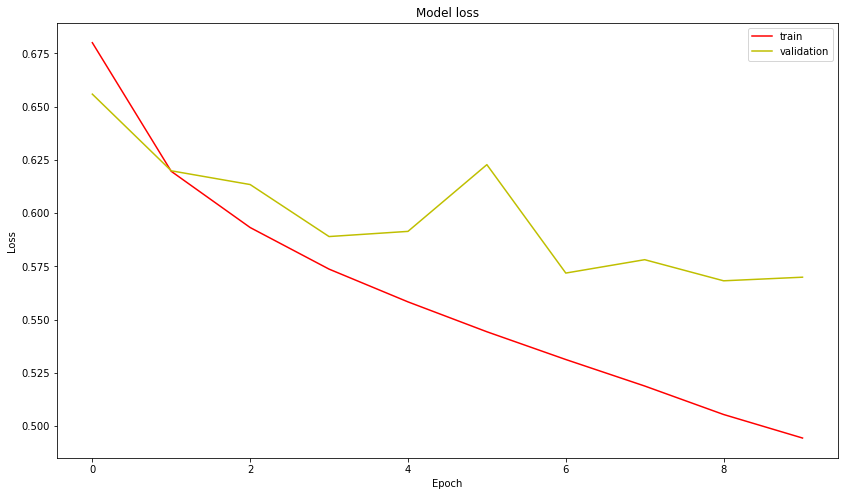

In [16]:
plt.figure(figsize=(14, 8))

plt.plot(history['train_loss'], 'r')
plt.plot(history['val_loss'], 'y')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

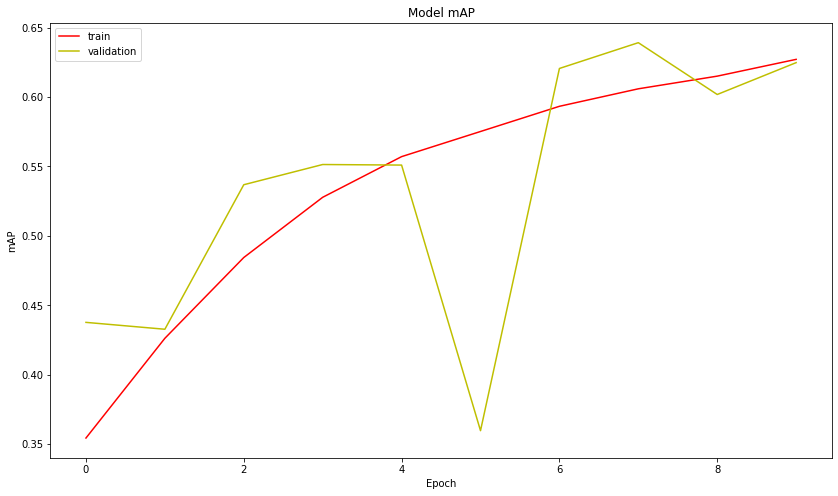

In [17]:
plt.figure(figsize=(14, 8))

plt.plot(history['train_map'], 'r')
plt.plot(history['val_map'], 'y')
plt.title('Model mAP')
plt.ylabel('mAP')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

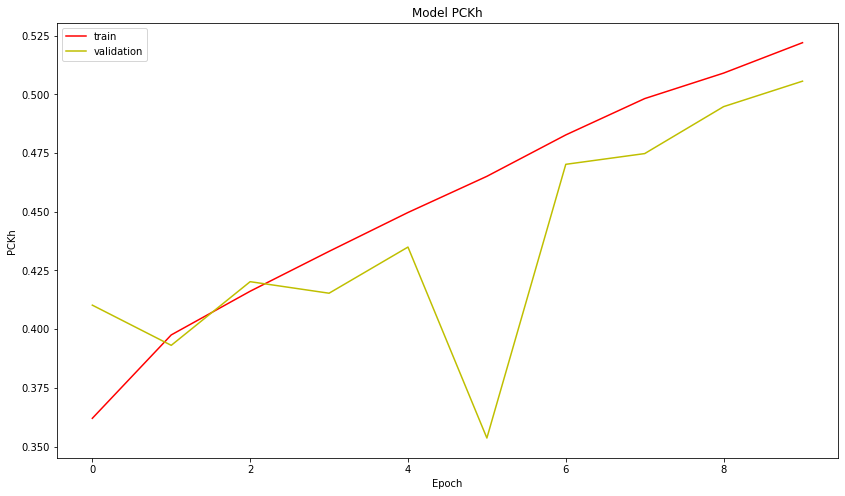

In [18]:
plt.figure(figsize=(14, 8))

plt.plot(history['train_pckh'], 'r')
plt.plot(history['val_pckh'], 'y')
plt.title('Model PCKh')
plt.ylabel('PCKh')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [21]:
with open('history/history_sp_10.json', 'w') as f:
    pd.DataFrame(history).to_json(f)